# Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
- NEXON Open API : https://openapi.nexon.com/ko/game/maplestory/?id=14
- Ï∫êÎ¶≠ÌÑ∞ Ï†ïÎ≥¥ Ï∞∏Í≥† : https://maple.gg/

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import time
import json
import glob
import os
import re
import aiohttp
import asyncio
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from urllib.parse import quote
from aiohttp import ClientSession

## JSON Ï∂îÏ∂ú
- Ï°∞Ìöå Í∏∞Ï§ÄÏùº : 2025-04-15
- ÎåÄÏÉÅ ÏõîÎìú : Ï†ÑÏ≤¥
- ÌéòÏù¥ÏßÄ : 1~5
‚áí ÏßÅÏóÖÎ≥Ñ 1,000Í∞ú Î™ÖÎã® Ï∂îÏ∂ú
- 'ÎåÄÏÉÅ ÌÅ¥ÎûòÏä§ Î¶¨Ïä§Ìä∏' Î∞è Ï†ÄÏû• Í≤ΩÎ°ú Î≥ÄÍ≤ΩÌïòÏó¨ ÌÉÄÏßÅÏóÖ Ï∂îÏ∂ú

In [ ]:
## ÎßàÎ≤ïÏÇ¨ Ï∂îÏ∂ú

# ÎÇ†Ïßú Î∞è API ÌÇ§ ÏÑ§Ï†ï
date = "2025-04-15"
API_KEY = "live_4bb9fe2d9c5f88d6d4d0fae33b021fd47a586db57c1872bf6649cad9965e1621efe8d04e6d233bd35cf2fabdeb93fb0d"
HEADERS = {"x-nxopen-api-key": API_KEY}

# ÎåÄÏÉÅ ÌÅ¥ÎûòÏä§ Î¶¨Ïä§Ìä∏
# ‚úÖ Î∞îÍøîÏÑú ÏÇ¨Ïö©Ìï† Í≤É!
target_classes = [
    "ÎßàÎ≤ïÏÇ¨-ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Î∂à,ÎèÖ)",
    "ÎßàÎ≤ïÏÇ¨-ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Ïç¨,ÏΩú)",
    "ÎßàÎ≤ïÏÇ¨-ÎπÑÏàç",
    "Í∏∞ÏÇ¨Îã®-ÌîåÎ†àÏûÑÏúÑÏûêÎìú",
    "Î†àÏßÄÏä§ÌÉïÏä§-Î∞∞ÌãÄÎ©îÏù¥ÏßÄ",
    "ÏóêÎ∞ò-Ï†ÑÏ≤¥ Ï†ÑÏßÅ",
    "Î£®ÎØ∏ÎÑàÏä§-Ï†ÑÏ≤¥ Ï†ÑÏßÅ",
    "ÏùºÎ¶¨ÏõÄ-Ï†ÑÏ≤¥ Ï†ÑÏßÅ",
    "ÎùºÎùº-Ï†ÑÏ≤¥ Ï†ÑÏßÅ",
    "ÌîÑÎ†åÏ¶à ÏõîÎìú-ÌÇ§ÎÑ§ÏãúÏä§"
]

# character Î∞è user Í¥ÄÎ†® endpoint Î¶¨Ïä§Ìä∏
character_endpoints = [
    "item-equipment", "stat", "hyper-stat", "ability",
    "vmatrix", "hexamatrix", "symbol-equipment",
    "set-effect", "link-skill", "hexamatrix-stat"
]

user_endpoints = [
    "union", "union-raider", "union-artifact", "union-champion"
]

# JSON ÏöîÏ≤≠ Ìï®Ïàò
async def fetch_json(session: ClientSession, url: str, params: dict):
    try:
        async with session.get(url, headers=HEADERS, params=params) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"‚ùå Ïã§Ìå®: {url} | ÏÉÅÌÉúÏΩîÎìú: {response.status}")
    except Exception as e:
        print(f"‚ùå ÏòàÏô∏ Î∞úÏÉù: {url} | {e}")
    return {}

# ocidÎ°ú Ï∫êÎ¶≠ÌÑ∞ ÏÉÅÏÑ∏ Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
async def fetch_character_data(session: ClientSession, character):
    ocid_url = "https://open.api.nexon.com/maplestory/v1/id"
    ocid_params = {
        "character_name": character["nickname"],
        "world_name": character["world"]
    }
    ocid_data = await fetch_json(session, ocid_url, ocid_params)
    ocid = ocid_data.get("ocid")
    if not ocid:
        print(f"‚ùóocid Î™ª Ï∞æÏùå ‚Üí ÎãâÎÑ§ÏûÑ: {character['nickname']} | ÏõîÎìú: {character['world']}")
        return None

    if "-" in character["class"]:
        job, subclass = character["class"].split("-")
    else:
        job = subclass = character["class"]

    if subclass == "Ï†ÑÏ≤¥ Ï†ÑÏßÅ":
        subclass = job

    result = {
        "nickname": character["nickname"],
        "world": character["world"],
        "level": character["level"],
        "rank": character["rank"],
        "job": job,
        "subclass": subclass
    }

    # character Í¥ÄÎ†® Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    for ep in character_endpoints:
        url = f"https://open.api.nexon.com/maplestory/v1/character/{ep}"
        data = await fetch_json(session, url, {"ocid": ocid, "date": date})
        result[ep] = data

    # user Í¥ÄÎ†® Îç∞Ïù¥ÌÑ∞ ÏàòÏßë(Ïú†ÎãàÏò®)
    for ep in user_endpoints:
        url = f"https://open.api.nexon.com/maplestory/v1/user/{ep}"
        data = await fetch_json(session, url, {"ocid": ocid, "date": date})
        result[ep] = data

    return result

# ÌÅ¥ÎûòÏä§Î≥Ñ Îû≠ÌÇπ ÏàòÏßë
async def gather_rankings_for_class(session, class_name):
    character_list = []
    for page in range(1, 6):  # ÌéòÏù¥ÏßÄÎãπ 200Î™Ö * 5ÌéòÏù¥ÏßÄ = Ï¥ù 1,000Î™Ö Ï∂îÏ∂ú
        params = {
            "date": date,
            "class": class_name,
            "page": page
        }
        data = await fetch_json(session, "https://open.api.nexon.com/maplestory/v1/ranking/overall", params)
        if not data or "ranking" not in data:
            break
        for entry in data["ranking"]:
            character_list.append({
                "nickname": entry.get("character_name"),
                "world": entry.get("world_name"),
                "level": entry.get("character_level"),
                "rank": entry.get("ranking"),
                "class": class_name
            })
        await asyncio.sleep(0.1)
    return character_list

# Ï†ÑÏ≤¥ Ïã§Ìñâ Ìï®Ïàò
async def main():
    save_dir = "/content/drive/MyDrive/data/ÎßàÎ≤ïÏÇ¨_statÏ∂îÍ∞Ä" # ‚úÖ Î∞îÍøîÏÑú ÏÇ¨Ïö©Ìï† Í≤É!
    os.makedirs(save_dir, exist_ok=True)

    async with ClientSession() as session:
        for class_name in target_classes:
            print(f"üì• {class_name} ÏàòÏßë ÏãúÏûë")
            character_list = await gather_rankings_for_class(session, class_name)
            results = []
            tasks = [fetch_character_data(session, char) for char in character_list]
            for i in range(0, len(tasks), 50):
                chunk = tasks[i:i + 50]
                chunk_results = await asyncio.gather(*chunk)
                results.extend([r for r in chunk_results if r])
                await asyncio.sleep(0.2)

            df = pd.DataFrame(results)
            safe_class_name = class_name.replace("-", "_")
            df.to_json(f"{save_dir}/{safe_class_name}.json", orient="records", force_ascii=False)
            print(f"‚úÖ Ï†ÄÏû• ÏôÑÎ£å: {safe_class_name}.json")

    return "ÏôÑÎ£å!"

await main()

#### ÌôïÏù∏Ïö©

In [ ]:
# JSON Î∂àÎü¨Ïò§Í∏∞
df = pd.read_json("/content/drive/MyDrive/data/stat·Ñé·ÖÆ·ÑÄ·Ö°/·ÑÜ·Ö°·Ñá·Ö•·Ü∏·Ñâ·Ö°_·Ñá·Öµ·Ñâ·Ö≠·Ü∏.json")

df.head()

In [ ]:
# Ï≤´ Î≤àÏß∏ rowÏùò Ïó¥ Ï†ÑÏ≤¥ Ï∂úÎ†•
print(json.dumps(df['stat'][0], indent=2, ensure_ascii=False))

In [ ]:
# Ï≤´ Î≤àÏß∏ rowÎ•º Í∏∞Ï§ÄÏúºÎ°ú Î™®Îì† Ïª¨Îüº Ï∂úÎ†•
for col in df.columns:
    print(f"\nüü° [{col}] ------------------------------")

    value = df[col][0]

    # dictÎÇò list ÌÉÄÏûÖÏù¥Î©¥ Î≥¥Í∏∞ Ï¢ãÍ≤å JSON Ï†ïÎ†¨ Ï∂úÎ†•
    if isinstance(value, (dict, list)):
        print(json.dumps(value, indent=2, ensure_ascii=False))
    else:
        print(value)

## CSV Î≥ÄÌôò
- ÌååÏùºÎ™Ö Î∞è json Í≤ΩÎ°ú Î≥ÄÍ≤ΩÌïòÏó¨ ÌÉÄÏßÅÏóÖ Ï∂îÏ∂ú

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### item-equipment

In [ ]:
# ‚úÖ Î∞îÍøîÏÑú ÏÇ¨Ïö©Ìï† Í≤É!
job_class = "Î£®ÎØ∏ÎÑàÏä§_Ï†ÑÏ≤¥ Ï†ÑÏßÅ"   # ÌïúÍ∏Ä ÌååÏùºÎ™Ö
job_class_eng = "luminous"         # ÏòÅÎ¨∏ ÌååÏùºÎ™Ö

# JSON ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
with open(f"/content/maple/magician_json/{job_class}.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Ï∫êÎ¶≠ÌÑ∞Î≥Ñ Ïû•ÎπÑ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
rows = []
for char in data:
    base_info = {
        "nickname": char.get("nickname"),
        "world": char.get("world"),
        "level": char.get("level"),
        "job": char.get("job"),
        "subclass": char.get("subclass"),
        # "gender": char.get("item-equipment", {}).get("character_gender"), # Ï∫êÎ¶≠ÌÑ∞ ÏÑ±Î≥Ñ
        # "preset_no": char.get("item-equipment", {}).get("preset_no"), # Ï†ÅÏö© Ï§ëÏù∏ Ïû•ÎπÑ ÌîÑÎ¶¨ÏÖã Î≤àÌò∏
        # Ïòà : Ïπ¥Îç∞ÎÇò Îû≠ÌÇπ 1ÏúÑ Î≥ÑÏôïÏùÄ 4/15 Í∏∞Ï§Ä ÌîÑÎ¶¨ÏÖãÏù¥ 3(Ïúº)Î°ú ÏÑ§Ï†ïÎêòÏñ¥ÏûàÏùå
        # Ïòà : Ïπ¥Îç∞ÎÇò Îû≠ÌÇπ 4ÏúÑ ÏÇ¨Ïä¨ÎÇ´ÏùòÏ†úÎãàÎäî 4/15 Í∏∞Ï§Ä ÌîÑÎ¶¨ÏÖãÏù¥ 2Î°ú ÏÑ§Ï†ïÎêòÏñ¥ÏûàÏùå
    }

    # ÌîÑÎ¶¨ÏÖã ÏÑ§Ï†ï
    preset_keys = [
        "item_equipment_preset_1",
        "item_equipment_preset_2",
        "item_equipment_preset_3"
    ]

    for preset_idx, preset_key in enumerate(preset_keys, start=1):
        items = char.get("item-equipment", {}).get(preset_key, [])
        for item in items:
            row = base_info.copy()
            row["preset_number"] = preset_idx # ÌîÑÎ¶¨ÏÖã Î≤àÌò∏
            row["equipment_part"] = item.get("item_equipment_part") # Ïû•ÎπÑ Î∂ÄÏúÑ Î™Ö
            row["equipment_slot"] = item.get("item_equipment_slot") # Ïû•ÎπÑ Ïä¨Î°Ø ÏúÑÏπò
            row["item_name"] = item.get("item_name") # Ïù¥Î¶Ñ
            # Ïû•ÎπÑ ÏÑ§Î™Ö, Ïû•ÎπÑ Ïô∏Ìòï, Ï†ÑÏö© ÏÑ±Î≥ÑÏùÄ Ï†úÏô∏

            ######################
            # itemTotalOption : Ïû•ÎπÑ ÏµúÏ¢Ö ÏòµÏÖò

            row["str_total"] = item.get("item_total_option", {}).get("str") # ÏµúÏ¢Ö Îä•Î†•Ïπò str
            row["dex_total"] = item.get("item_total_option", {}).get("dex") # ÏµúÏ¢Ö Îä•Î†•Ïπò dex
            row["int_total"] = item.get("item_total_option", {}).get("int") # ÏµúÏ¢Ö Îä•Î†•Ïπò int
            row["luk_total"] = item.get("item_total_option", {}).get("luk") # ÏµúÏ¢Ö Îä•Î†•Ïπò luk
            row["max_hp_total"] = item.get("item_total_option", {}).get("max_hp") # ÏµúÏ¢Ö Îä•Î†•Ïπò max_hp
            row["max_mp_total"] = item.get("item_total_option", {}).get("max_mp") # ÏµúÏ¢Ö Îä•Î†•Ïπò max_mp
            row["attack_power_total"] = item.get("item_total_option", {}).get("attack_power") # ÏµúÏ¢Ö Îä•Î†•Ïπò attack_power
            row["magic_power_total"] = item.get("item_total_option", {}).get("magic_power") # ÏµúÏ¢Ö Îä•Î†•Ïπò magic_power
            row["armor_total"] = item.get("item_total_option", {}).get("armor") # ÏµúÏ¢Ö Îä•Î†•Ïπò armor
            row["speed_total"] = item.get("item_total_option", {}).get("speed") # ÏµúÏ¢Ö Îä•Î†•Ïπò speed
            row["jump_total"] = item.get("item_total_option", {}).get("jump") # ÏµúÏ¢Ö Îä•Î†•Ïπò jump
            row["boss_damage_total"] = item.get("item_total_option", {}).get("boss_damage") # ÏµúÏ¢Ö Îä•Î†•Ïπò boss_damage
            row["ignore_monster_armor_total"] = item.get("item_total_option", {}).get("ignore_monster_armor") # ÏµúÏ¢Ö Îä•Î†•Ïπò ignore_monster_armor
            row["all_stat_total"] = item.get("item_total_option", {}).get("all_stat") # ÏµúÏ¢Ö Îä•Î†•Ïπò all_stat
            row["damage_total"] = item.get("item_total_option", {}).get("damage") # ÏµúÏ¢Ö Îä•Î†•Ïπò damage
            row["equipment_level_decrease_total"] = item.get("item_total_option", {}).get("equipment_level_decrease") # ÏµúÏ¢Ö Îä•Î†•Ïπò equipment_level_decrease
            row["max_hp_rate_total"] = item.get("item_total_option", {}).get("max_hp_rate") # ÏµúÏ¢Ö Îä•Î†•Ïπò max_hp_rate
            row["max_mp_rate_total"] = item.get("item_total_option", {}).get("max_mp_rate") # ÏµúÏ¢Ö Îä•Î†•Ïπò max_mp_rate

            ######################
            # itemBaseOption : Ïû•ÎπÑ Í∏∞Î≥∏ ÏòµÏÖò

            row["str_base"] = item.get("item_base_option", {}).get("str") # Í∏∞Î≥∏ Îä•Î†•Ïπò str
            row["dex_base"] = item.get("item_base_option", {}).get("dex") # Í∏∞Î≥∏ Îä•Î†•Ïπò dex
            row["int_base"] = item.get("item_base_option", {}).get("int") # Í∏∞Î≥∏ Îä•Î†•Ïπò int
            row["luk_base"] = item.get("item_base_option", {}).get("luk") # Í∏∞Î≥∏ Îä•Î†•Ïπò luk
            row["max_hp_base"] = item.get("item_base_option", {}).get("max_hp") # Í∏∞Î≥∏ Îä•Î†•Ïπò max_hp
            row["max_mp_base"] = item.get("item_base_option", {}).get("max_mp") # Í∏∞Î≥∏ Îä•Î†•Ïπò max_mp
            row["attack_power_base"] = item.get("item_base_option", {}).get("attack_power") # Í∏∞Î≥∏ Îä•Î†•Ïπò attack_power
            row["magic_power_base"] = item.get("item_base_option", {}).get("magic_power") # Í∏∞Î≥∏ Îä•Î†•Ïπò magic_power
            row["armor_base"] = item.get("item_base_option", {}).get("armor") # Í∏∞Î≥∏ Îä•Î†•Ïπò armor
            row["speed_base"] = item.get("item_base_option", {}).get("speed") # Í∏∞Î≥∏ Îä•Î†•Ïπò speed
            row["jump_base"] = item.get("item_base_option", {}).get("jump") # Í∏∞Î≥∏ Îä•Î†•Ïπò jump
            row["boss_damage_base"] = item.get("item_base_option", {}).get("boss_damage") # Í∏∞Î≥∏ Îä•Î†•Ïπò bose_damage
            row["ignore_monster_armor_base"] = item.get("item_base_option", {}).get("ignore_monster_armor") # Í∏∞Î≥∏ Îä•Î†•Ïπò ignore_monster_armor
            row["all_stat_base"] = item.get("item_base_option", {}).get("all_stat") # Í∏∞Î≥∏ Îä•Î†•Ïπò all_stat
            row["max_hp_rate_base"] = item.get("item_base_option", {}).get("max_hp_rate") # Í∏∞Î≥∏ Îä•Î†•Ïπò max_hp_rate
            row["max_mp_rate_base"] = item.get("item_base_option", {}).get("max_mp_rate") # Í∏∞Î≥∏ Îä•Î†•Ïπò max_mp_rate
            row["base_equipment_level_base"] = item.get("item_base_option", {}).get("base_equipment_level") # Í∏∞Î≥∏ Îä•Î†•Ïπò base_equipment_level

            ######################
            # Ïû†Ïû¨Îä•Î†• + ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†•

            row["potential_option_grade"] = item.get("potential_option_grade") # Ïû†Ïû¨Îä•Î†• Îì±Í∏â
            row["additional_potential_option_grade"] = item.get("additional_potential_option_grade") # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†• Îì±Í∏â
            # row["potential_option_flag"] = item.get("potential_option_flag")
            row["potential_option_1"] = item.get("potential_option_1") # Ïû†Ïû¨Îä•Î†• 1
            row["potential_option_2"] = item.get("potential_option_2") # Ïû†Ïû¨Îä•Î†• 2
            row["potential_option_3"] = item.get("potential_option_3") # Ïû†Ïû¨Îä•Î†• 3
            # row["additional_potential_option_flag"] = item.get("additional_potential_option_flag")
            row["additional_potential_option_1"] = item.get("additional_potential_option_1") # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†• 1
            row["additional_potential_option_2"] = item.get("additional_potential_option_2") # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†• 2
            row["additional_potential_option_3"] = item.get("additional_potential_option_3") # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†• 3
            row["equipment_level_increase"] = item.get("equipment_level_increase") # Ï∞©Ïö© Î†àÎ≤® Ï¶ùÍ∞Ä

            ######################
            # itemExceptionalOption : Ïû•ÎπÑ ÌäπÎ≥Ñ ÏòµÏÖò

            row["str_exceptional"] = item.get("item_exceptional_option", {}).get("str") # ÌäπÎ≥Ñ Îä•Î†•Ïπò str
            row["dex_exceptional"] = item.get("item_exceptional_option", {}).get("dex") # ÌäπÎ≥Ñ Îä•Î†•Ïπò dex
            row["int_exceptional"] = item.get("item_exceptional_option", {}).get("int") # ÌäπÎ≥Ñ Îä•Î†•Ïπò int
            row["luk_exceptional"] = item.get("item_exceptional_option", {}).get("luk") # ÌäπÎ≥Ñ Îä•Î†•Ïπò luk
            row["max_hp_exceptional"] = item.get("item_exceptional_option", {}).get("max_hp") # ÌäπÎ≥Ñ Îä•Î†•Ïπò max_hp
            row["max_mp_exceptional"] = item.get("item_exceptional_option", {}).get("max_mp") # ÌäπÎ≥Ñ Îä•Î†•Ïπò max_mp
            row["attack_power_exceptional"] = item.get("item_exceptional_option", {}).get("attack_power") # ÌäπÎ≥Ñ Îä•Î†•Ïπò attack_power
            row["magic_power_exceptional"] = item.get("item_exceptional_option", {}).get("magic_power") # ÌäπÎ≥Ñ Îä•Î†•Ïπò magic_power
            row["exceptional_upgrade"] = item.get("item_exceptional_option", {}).get("exceptional_upgrade") # ÏùµÏÖâÏÖîÎÑê Í∞ïÌôî Ï†ÅÏö© ÌöüÏàò

            ######################
            # itemAddOption : Ïû•ÎπÑ Ï∂îÍ∞Ä ÏòµÏÖò

            row["str_add"] = item.get("item_add_option", {}).get("str") # Ï∂îÍ∞Ä Îä•Î†•Ïπò str
            row["dex_add"] = item.get("item_add_option", {}).get("dex") # Ï∂îÍ∞Ä Îä•Î†•Ïπò dex
            row["int_add"] = item.get("item_add_option", {}).get("int") # Ï∂îÍ∞Ä Îä•Î†•Ïπò int
            row["luk_add"] = item.get("item_add_option", {}).get("luk") # Ï∂îÍ∞Ä Îä•Î†•Ïπò luk
            row["max_hp_add"] = item.get("item_add_option", {}).get("max_hp") # Ï∂îÍ∞Ä Îä•Î†•Ïπò max_hp
            row["max_mp_add"] = item.get("item_add_option", {}).get("max_mp") # Ï∂îÍ∞Ä Îä•Î†•Ïπò max_mp
            row["attack_power_add"] = item.get("item_add_option", {}).get("attack_power") # Ï∂îÍ∞Ä Îä•Î†•Ïπò attack_power
            row["magic_power_add"] = item.get("item_add_option", {}).get("magic_power") # Ï∂îÍ∞Ä Îä•Î†•Ïπò magic_power
            row["armor_add"] = item.get("item_add_option", {}).get("armor") # Ï∂îÍ∞Ä Îä•Î†•Ïπò armor
            row["speed_add"] = item.get("item_add_option", {}).get("speed") # Ï∂îÍ∞Ä Îä•Î†•Ïπò speed
            row["jump_add"] = item.get("item_add_option", {}).get("jump") # Ï∂îÍ∞Ä Îä•Î†•Ïπò jump
            row["boss_damage_add"] = item.get("item_add_option", {}).get("boss_damage") # Ï∂îÍ∞Ä Îä•Î†•Ïπò boss_damage
            row["damage_add"] = item.get("item_add_option", {}).get("damage") # Ï∂îÍ∞Ä Îä•Î†•Ïπò damage
            row["all_stat_add"] = item.get("item_add_option", {}).get("all_stat") # Ï∂îÍ∞Ä Îä•Î†•Ïπò all_stat
            row["equipment_level_decrease_add"] = item.get("item_add_option", {}).get("equipment_level_decrease") # Ï∞©Ïö© Î†àÎ≤® Í∞êÏÜå

            ######################
            # itemEtcOption : Ïû•ÎπÑ Í∏∞ÌÉÄ ÏòµÏÖò

            row["str_etc"] = item.get("item_etc_option", {}).get("str") # Í∏∞ÌÉÄ Îä•Î†•Ïπò str
            row["dex_etc"] = item.get("item_etc_option", {}).get("dex") # Í∏∞ÌÉÄ Îä•Î†•Ïπò dex
            row["int_etc"] = item.get("item_etc_option", {}).get("int") # Í∏∞ÌÉÄ Îä•Î†•Ïπò int
            row["luk_etc"] = item.get("item_etc_option", {}).get("luk") # Í∏∞ÌÉÄ Îä•Î†•Ïπò luk
            row["max_hp_etc"] = item.get("item_etc_option", {}).get("max_hp") # Í∏∞ÌÉÄ Îä•Î†•Ïπò max_hp
            row["max_mp_etc"] = item.get("item_etc_option", {}).get("max_mp") # Í∏∞ÌÉÄ Îä•Î†•Ïπò max_mp
            row["attack_power_etc"] = item.get("item_etc_option", {}).get("attack_power") # Í∏∞ÌÉÄ Îä•Î†•Ïπò attack_power
            row["magic_power_etc"] = item.get("item_etc_option", {}).get("magic_power") # Í∏∞ÌÉÄ Îä•Î†•Ïπò magic_power
            row["armor_etc"] = item.get("item_etc_option", {}).get("armor") # Í∏∞ÌÉÄ Îä•Î†•Ïπò armor
            row["speed_etc"] = item.get("item_etc_option", {}).get("speed") # Í∏∞ÌÉÄ Îä•Î†•Ïπò speed
            row["jump_etc"] = item.get("item_etc_option", {}).get("jump") # Í∏∞ÌÉÄ Îä•Î†•Ïπò jump

            ######################
            # itemStarforceOption : Ïû•ÎπÑ Ïä§ÌÉÄÌè¨Ïä§ ÏòµÏÖò

            row["starforce"] = item.get("starforce") # Ïä§ÌÉÄÌè¨Ïä§
            row["starforce_scroll_flag"] = item.get("starforce_scroll_flag") # ÎÜÄÎùºÏö¥ Ïû•ÎπÑ Í∞ïÌôî Ï£ºÎ¨∏ÏÑú ÏÇ¨Ïö© Ïó¨Î∂Ä (0:ÎØ∏ÏÇ¨Ïö©, 1:ÏÇ¨Ïö©)
            row["str_starforce"] = item.get("item_starforce_option", {}).get("str") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò str
            row["dex_starforce"] = item.get("item_starforce_option", {}).get("dex") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò dex
            row["int_starforce"] = item.get("item_starforce_option", {}).get("int") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò int
            row["luk_starforce"] = item.get("item_starforce_option", {}).get("luk") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò luk
            row["max_hp_starforce"] = item.get("item_starforce_option", {}).get("max_hp") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò max_hp
            row["max_mp_starforce"] = item.get("item_starforce_option", {}).get("max_mp") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò max_mp
            row["attack_power_starforce"] = item.get("item_starforce_option", {}).get("attack_power") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò attack_power
            row["magic_power_starforce"] = item.get("item_starforce_option", {}).get("magic_power") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò magic_power
            row["armor_starforce"] = item.get("item_starforce_option", {}).get("armor") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò armor
            row["speed_starforce"] = item.get("item_starforce_option", {}).get("speed") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò speed
            row["jump_starforce"] = item.get("item_starforce_option", {}).get("jump") # Ïä§ÌÉÄÌè¨Ïä§ Îä•Î†•Ïπò jump
            row["special_ring_level"] = item.get("special_ring_level") # ÌäπÏàò Î∞òÏßÄ Î†àÎ≤®
            # row["date_expire"] = item.get("item_starforce_option", {}).get("date_expire") # Ïû•ÎπÑ Ïú†Ìö® Í∏∞Í∞Ñ

            ######################
            # Í∏∞ÌÉÄ

            row["growth_exp"] = item.get("growth_exp") # ÏÑ±Ïû• Í≤ΩÌóòÏπò
            row["growth_level"] = item.get("growth_level") # ÏÑ±Ïû• Î†àÎ≤®
            row["scroll_upgrade"] = item.get("scroll_upgrade") # ÏóÖÍ∑∏Î†àÏù¥Îìú ÌöüÏàò
            row["cuttable_count"] = item.get("cuttable_count") # Í∞ÄÏúÑ ÏÇ¨Ïö© Í∞ÄÎä• ÌöüÏàò (ÍµêÌôò Î∂àÍ∞Ä Ïû•ÎπÑ, Í∞ÄÏúÑ ÌöüÏàòÍ∞Ä ÏóÜÎäî ÍµêÌôò Í∞ÄÎä• Ïû•ÎπÑÎäî 255)
            row["golden_hammer_flag"] = item.get("golden_hammer_flag") # Ìô©Í∏à ÎßùÏπò Ïû¨Î†® Ï†ÅÏö© (1:Ï†ÅÏö©, Ïù¥Ïô∏ ÎØ∏ Ï†ÅÏö©)
            row["scroll_resilience_count"] = item.get("scroll_resilience_count") # Î≥µÍµ¨ Í∞ÄÎä• ÌöüÏàò
            row["scroll_upgradeable_count"] = item.get("scroll_upgradeable_count") # ÏóÖÍ∑∏Î†àÏù¥Îìú Í∞ÄÎä• ÌöüÏàò
            row["soul_name"] = item.get("soul_name") # ÏÜåÏö∏ Î™Ö
            row["soul_option"] = item.get("soul_option") # ÏÜåÏö∏ ÏòµÏÖò


            rows.append(row)

# DataFrame ÏÉùÏÑ±
df = pd.DataFrame(rows)

# CSV Ï†ÄÏû•
df.to_csv(f"{job_class_eng}_equipment.csv", index=False, encoding="utf-8-sig")
print("CSV Ï†ÄÏû• ÏôÑÎ£å!")

----
# Í∞ÄÏÑ§ Í≤ÄÏ†ï Î∞è ÏãúÍ∞ÅÌôî

In [ ]:
# item Îç∞Ïù¥ÌÑ∞ Î™®Îëê Î∂àÎü¨Ïò§Í∏∞

# ÏÉÅÏúÑ Ìè¥Îçî Í≤ΩÎ°ú
root_dir = "/content/drive/MyDrive/data/item" # ÏàòÏ†ï

# ÌïòÏúÑ Î™®Îì† CSV ÌÉêÏÉâ
all_csv_files = glob.glob(os.path.join(root_dir, "*/*.csv"))

df_list = []
for file in all_csv_files:
    df = pd.read_csv(file)
    folder_name = os.path.basename(os.path.dirname(file))
    job_file = os.path.basename(file).replace("_equipment.csv", "") # ÏàòÏ†ï
    df["job_group"] = folder_name
    df_list.append(df)

# Ï†ÑÏ≤¥ ÌÜµÌï©
item_df = pd.concat(df_list, ignore_index=True) # ÏàòÏ†ï

In [ ]:
# Î©îÏù¥ÌîåÏùò Ïû•ÎπÑ ÌîÑÎ¶¨ÏÖãÏùÄ Ï¥ù 3Í∞ú -> Í∞ÄÏû• Ï∂îÍ∞ÄÏòµÏÖòÏù¥ ÎÜíÏùÄ ÌîÑÎ¶¨ÏÖã ÌïòÎÇòÎßå ÏÇ¨Ïö©ÌïòÏó¨ Î∂ÑÏÑù

# ÏßÅÏóÖÎ≥Ñ Ï£ºÏä§ÌÉØ ÎßµÌïë
main_stat_map = {
    "STR": ["ÌûàÏñ¥Î°ú", "ÏïÑÎç∏", "ÏÜåÏö∏ÎßàÏä§ÌÑ∞", "ÏïÑÎûÄ", "Ï†úÎ°ú", "ÌåîÎùºÎîò", "Îã§ÌÅ¨ÎÇòÏù¥Ìä∏", "Ïπ¥Ïù¥Ï†Ä",
            "Îç∞Î™¨Ïä¨Î†àÏù¥Ïñ¥", "ÎØ∏ÌïòÏùº", "Î∏îÎûòÏä§ÌÑ∞", "ÏùÄÏõî", "Î∞îÏù¥Ìçº", "Ïä§Ìä∏ÎùºÏù¥Ïª§", "Ï∫êÎÖºÎßàÏä§ÌÑ∞"],
    "DEX": ["ÏúàÎìúÎ∏åÎ†àÏù¥Ïª§", "Î©îÎ•¥ÏÑ∏Îç∞Ïä§", "Î≥¥Ïö∞ÎßàÏä§ÌÑ∞", "Ìå®Ïä§ÌååÏù∏Îçî", "Ïã†Í∂Å", "Ïπ¥Ïù∏", "ÏôÄÏùºÎìúÌóåÌÑ∞",
            "ÏóîÏ†§Î¶≠Î≤ÑÏä§ÌÑ∞", "Ï∫°Ìã¥", "Î©îÏπ¥Îãâ"],
    "INT": ["ÎπÑÏàç", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Î∂à,ÎèÖ)", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Ïç¨,ÏΩú)", "ÎùºÎùº", "Î∞∞ÌãÄÎ©îÏù¥ÏßÄ", "ÏóêÎ∞ò", "Î£®ÎØ∏ÎÑàÏä§",
            "ÌÇ§ÎÑ§ÏãúÏä§", "ÌîåÎ†àÏûÑÏúÑÏûêÎìú", "ÏùºÎ¶¨ÏõÄ"],
    "LUK": ["ÎÇòÏù¥Ìä∏ÏõåÏª§", "ÏÑÄÎèÑÏñ¥", "ÎÇòÏù¥Ìä∏Î°úÎìú", "ÎìÄÏñºÎ∏îÎ†àÏù¥Îçî", "Ìå¨ÌÖÄ", "Ìò∏ÏòÅ", "ÏπºÎ¶¨", "Ïπ¥Îç∞ÎÇò"],
    "HP": ["Îç∞Î™¨Ïñ¥Î≤§Ï†∏"],
    "ALL": ["Ï†úÎÖº"]
}

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df["main_stat_type"] = item_df.apply(get_main_stat, axis=1)

# Ï∂îÏòµ Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None:
        return 0
    allstat = row["all_stat_add"] * 10
    if stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    elif stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"] + allstat
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df["bonus_stat_total"] = item_df.apply(calculate_bonus_stat, axis=1)

# Ïú†Ï†ÄÎ≥Ñ + Î∂ÄÏúÑÎ≥Ñ Í∞ÄÏû• ÎÜíÏùÄ bonus_stat_totalÏùÑ Í∞ÄÏßÑ ÌîÑÎ¶¨ÏÖãÎßå Ï∂îÏ∂ú
item_df_best = (
    item_df.loc[item_df.groupby(["nickname", "equipment_part"])["bonus_stat_total"].idxmax()]
    .reset_index(drop=True)
)

In [ ]:
item_df_best.info(max_cols=300)

## Í∞ÄÏÑ§ 1
----

Ïï±ÏÜîÎû©Ïä§(Ï§ëÌïòÏúÑÍ∂å Ïû•ÎπÑ)Î•º ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞, ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú(Ï§ëÏÉÅÏúÑÍ∂å), ÏóêÌÖåÎ•¥ÎÑ¨(ÏÉÅÏúÑÍ∂å) Ïû•ÎπÑÏóê ÎπÑÌï¥ Í∞ïÌôî ÏàòÏπò 22ÏÑ±Ïùò Í∞úÏàòÍ∞Ä Îçî ÎßéÏùÑ Í≤ÉÏù¥Îã§.

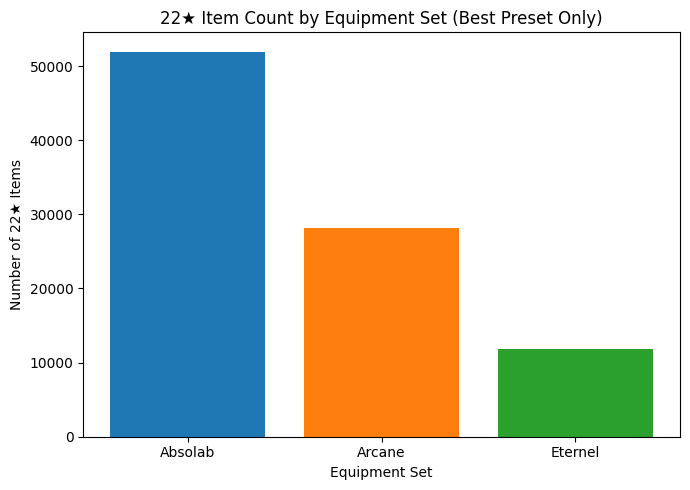

In [ ]:
# Ïû•ÎπÑ ÏÑ∏Ìä∏ Í∑∏Î£π Ï†ïÏùò
def map_equipment_group(name):
    if "Ïï±ÏÜîÎû©Ïä§" in name:
        return "Absolab"
    elif "ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú" in name:
        return "Arcane"
    elif "ÏóêÌÖåÎ•¥ÎÑ¨" in name:
        return "Eternel"
    return None

# ÏÑ∏Ìä∏Î™Ö Îß§Ìïë Î∞è ÌïÑÌÑ∞ÎßÅ
item_df_best["equip_group"] = item_df_best["item_name"].apply(map_equipment_group)
filtered = item_df_best[item_df_best["equip_group"].notnull()].copy()

# 22ÏÑ± Ïó¨Î∂Ä Ïª¨Îüº Ï∂îÍ∞Ä
filtered["is_22star"] = (filtered["starforce"] == 22).astype(int)

# ÏÑ∏Ìä∏Î≥Ñ 22ÏÑ± Ïû•ÎπÑ Í∞úÏàò ÏßëÍ≥Ñ
group_counts = (
    filtered
    .groupby("equip_group")["is_22star"]
    .sum()
    .reindex(["Absolab", "Arcane", "Eternel"], fill_value=0)
)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(7, 5))
bars = plt.bar(group_counts.index, group_counts.values, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

# ÏàòÏπò ÎùºÎ≤® ÌëúÏãú
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f"{int(height):,}",  # ÏâºÌëú Ìè¨Ìï® Ïà´Ïûê ÌëúÏãú
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),
#                  textcoords="offset points",
#                  ha="center", va="bottom", fontsize=9)

plt.title("22‚òÖ Item Count by Equipment Set (Best Preset Only)")
plt.xlabel("Equipment Set")
plt.ylabel("Number of 22‚òÖ Items")
plt.tight_layout()
plt.show()

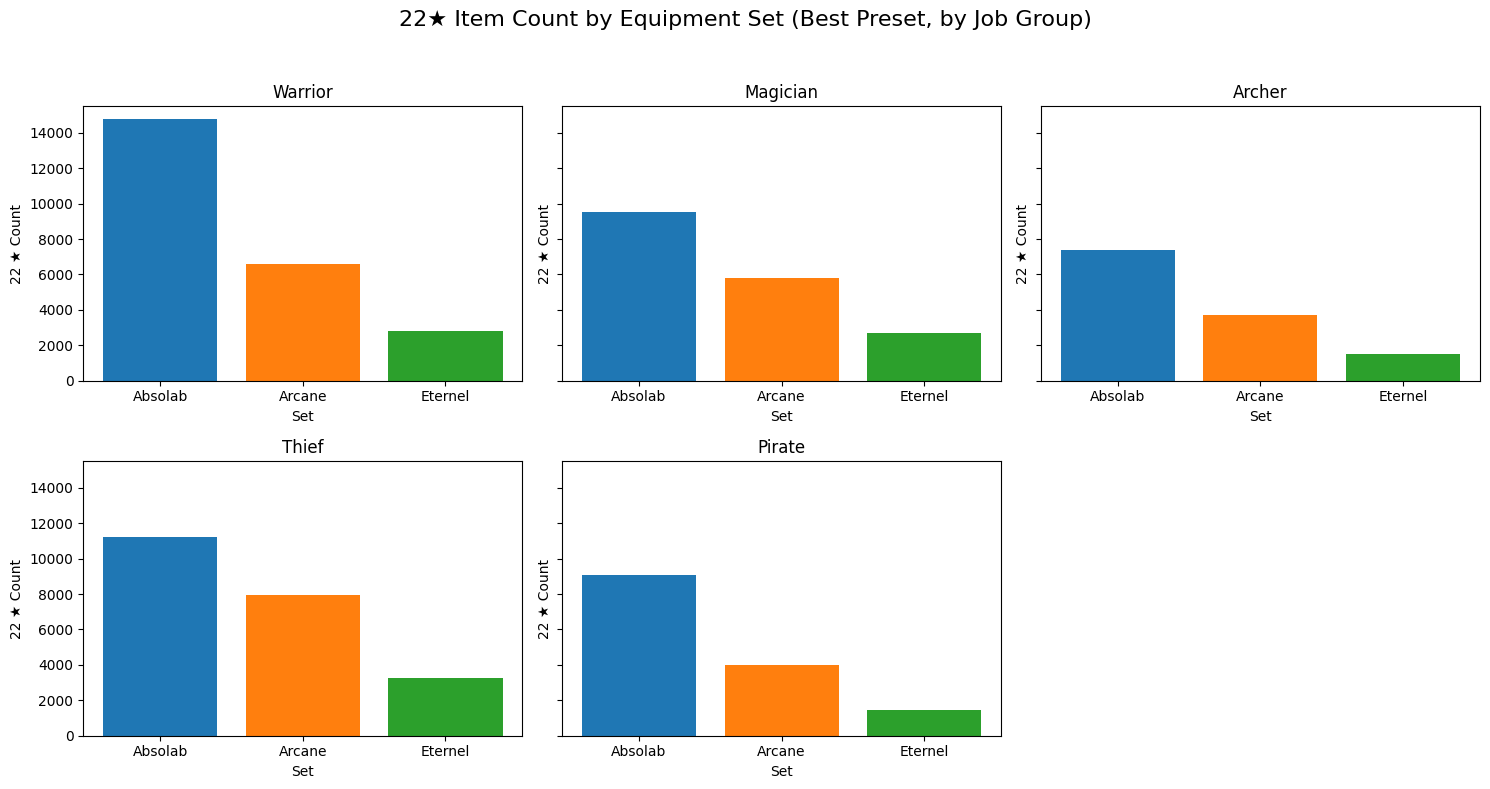

In [ ]:
# ÏßÅÏóÖÍµ∞Î≥ÑÎ°ú ÏÇ¥Ìé¥Î≥¥Í∏∞

# Ïú†ÎãàÏΩîÎìú Ï†ïÍ∑úÌôî + ÏßÅÏóÖÍµ∞ ÏòÅÏñ¥ Îß§Ìïë
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "Ï†ÑÏÇ¨": "Warrior", "ÎßàÎ≤ïÏÇ¨": "Magician", "Í∂ÅÏàò": "Archer", "ÎèÑÏ†Å": "Thief", "Ìï¥Ï†Å": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# Ïû•ÎπÑ ÏÑ∏Ìä∏ Î∂ÑÎ•ò
def map_equipment_group(name):
    if "Ïï±ÏÜîÎû©Ïä§" in name:
        return "Absolab"
    elif "ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú" in name:
        return "Arcane"
    elif "ÏóêÌÖåÎ•¥ÎÑ¨" in name:
        return "Eternel"
    return None

item_df_best["equip_group"] = item_df_best["item_name"].apply(map_equipment_group)
filtered = item_df_best[item_df_best["equip_group"].notnull()].copy()
filtered["is_22star"] = (filtered["starforce"] == 22).astype(int)

# ÏßÅÏóÖÍµ∞ Î¶¨Ïä§Ìä∏
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
colors = {"Absolab": "#1f77b4", "Arcane": "#ff7f0e", "Eternel": "#2ca02c"}

# subplot ÏãúÍ∞ÅÌôî
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for idx, group in enumerate(job_groups):
    ax = axes[idx]
    sub = filtered[filtered["job_group_eng"] == group]
    count = (
        sub.groupby("equip_group")["is_22star"]
        .sum()
        .reindex(["Absolab", "Arcane", "Eternel"], fill_value=0)
    )
    bars = ax.bar(count.index, count.values, color=[colors[k] for k in count.index])

    ax.set_title(group)
    ax.set_xlabel("Set")
    ax.set_ylabel("22 ‚òÖ Count")
    ax.tick_params(axis="x", rotation=0)

    # for bar in bars:
    #     height = bar.get_height()
    #     ax.annotate(f"{int(height):,}",  # ÏâºÌëú ÏûàÎäî Ïà´Ïûê
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 2),
    #                 textcoords="offset points",
    #                 ha="center", va="bottom", fontsize=9)

# Îπà subplot Ï†úÍ±∞
for j in range(len(job_groups), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("22‚òÖ Item Count by Equipment Set (Best Preset, by Job Group)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

ÏãúÍ∞ÅÌôî Í≤∞Í≥º: Ïï±ÏÜîÎû©Ïä§ Ïû•ÎπÑÏóêÏÑú Í∑∏ ÏúóÎã®Í≥ÑÏù∏ ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú, ÏóêÌÖåÎ•¥ÎÑ¨ Ïû•ÎπÑÏóê ÎπÑÌï¥ 22ÏÑ±Ïùò Í∞úÏàòÍ∞Ä Îçî ÎßéÎã§. **(Í∏∞Ï°¥ Í∞ÄÏÑ§
 = TRUE)**
- ÎòêÌïú Î™®Îì† ÏßÅÏóÖÍµ∞ÏóêÏÑú Í∞ôÏùÄ Í≤ΩÌñ•ÏÑ±Ïù¥ Î≥¥ÏòÄÎã§.

### Ï∂îÎ°† ÌÜµÍ≥Ñ

In [ ]:
# Ïû•ÎπÑ Îì±Í∏âÍ≥º Í∞ïÌôî Íµ¨Í∞Ñ(22ÏÑ± vs ÎØ∏Îßå) ÏÇ¨Ïù¥Ïùò ÎèÖÎ¶ΩÏÑ± Ïó¨Î∂Ä Í≤ÄÏ†ï: Ïπ¥Ïù¥Ï†úÍ≥± ÎèÖÎ¶ΩÏÑ± Í≤ÄÏ†ï

# ÍµêÏ∞®Ìëú
crosstab = pd.crosstab(filtered["equip_group"], filtered["is_22star"])

# Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ï
chi2, pval, dof, expected = chi2_contingency(crosstab)

# ÌÅ¨ÎûòÎ®∏Ïùò V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cram√©r's V: {cramers_v:.4f}")

Chi-square: 16879.199, p-value: 0.0000
Cram√©r's V: 0.2820


- Í∑ÄÎ¨¥Í∞ÄÏÑ§(H‚ÇÄ): Ïû•ÎπÑ Îì±Í∏âÍ≥º 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÎäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥Îã§. (Ïû•ÎπÑ Îì±Í∏âÏóê ÏÉÅÍ¥ÄÏóÜÏù¥ 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÍ∞Ä ÎπÑÏä∑Ìï®)
- ÎåÄÎ¶ΩÍ∞ÄÏÑ§(H‚ÇÅ): Ïû•ÎπÑ Îì±Í∏âÍ≥º 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÎäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥ ÏïÑÎãàÎã§. (Ïû•ÎπÑ Îì±Í∏âÏóê Îî∞Îùº 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÍ∞Ä Îã¨ÎùºÏßê)
  - **p-value < Œ±(0.05)Î°ú, ÎåÄÎ¶ΩÍ∞ÄÏÑ§ÏùÑ Ï±ÑÌÉùÌïòÏó¨ Ïû•ÎπÑ Îì±Í∏âÏóê Îî∞Îùº 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÍ∞Ä Îã¨ÎùºÏßÑÎã§Í≥† Ìï† Ïàò ÏûàÎã§.**
  - ÎòêÌïú **Cram√©r‚Äôs V = 0.2820**ÏùÄ **Îëê Î≥ÄÏàò Í∞ÑÏùò Í¥ÄÍ≥Ñ Í∞ïÎèÑÍ∞Ä ÏïΩÌïú ÏàòÏ§ÄÏóêÏÑú Ï§ëÍ∞Ñ ÏàòÏ§ÄÏóê Í∞ÄÍπåÏö¥ Î™ÖÌôïÌïú Í≤ΩÌñ•ÏÑ±ÏùÑ Í∞ÄÏßÑÎã§**Îäî Ï†êÏùÑ Î≥¥Ïó¨Ï£ºÎ©∞,
Ïù¥Îäî **Ïû•ÎπÑ Í∞ïÌôî Ï†ÑÎûµÏóêÏÑú Îì±Í∏âÏóê Îî∞Î•∏ ÎöúÎ†∑Ìïú Í≤ΩÌñ•ÏÑ±Ïù¥ Ïã§ÏßàÏ†ÅÏúºÎ°ú Ï°¥Ïû¨Ìï®**ÏùÑ ÏùòÎØ∏ÌïúÎã§.

In [ ]:
# ÏßÅÏóÖÍµ∞ÎßàÎã§ Ïù¥Îü¨Ìïú Í≤ΩÌñ•Ïù¥ ÏùºÍ¥ÄÎêòÍ≤å ÎÇòÌÉÄÎÇòÎäîÍ∞Ä?: ÏßÅÏóÖÍµ∞Î≥ÑÎ°ú Í∞úÎ≥Ñ Ïπ¥Ïù¥Ï†úÍ≥± ÎèÖÎ¶ΩÏÑ± Í≤ÄÏ†ï
job_groups = filtered["job_group_eng"].unique()

results = []

for job in job_groups:
    subset = filtered[filtered["job_group_eng"] == job]
    table = pd.crosstab(subset["equip_group"], subset["is_22star"])

    if table.shape[0] > 1 and table.shape[1] > 1:  # ÏòàÏô∏ Ï≤òÎ¶¨
        chi2, pval, dof, expected = chi2_contingency(table)

        results.append({
            "job_group": job,
            "chi2": chi2,
            "p_value": pval,
            "significant": pval < 0.05
        })

pd.DataFrame(results)

job_group         chi2  p_value  significant
0    Pirate  4606.490601      0.0         True
1   Warrior  4416.813702      0.0         True
2    Archer  2666.146313      0.0         True
3     Thief  3195.452344      0.0         True
4  Magician  2680.703522      0.0         True

- Í∑ÄÎ¨¥Í∞ÄÏÑ§(H‚ÇÄ): Ïû•ÎπÑ Îì±Í∏âÍ≥º 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÎäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥Îã§. (Ïû•ÎπÑ Îì±Í∏âÏóê ÏÉÅÍ¥ÄÏóÜÏù¥ 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÍ∞Ä ÎπÑÏä∑Ìï®)
- ÎåÄÎ¶ΩÍ∞ÄÏÑ§(H‚ÇÅ): Ïû•ÎπÑ Îì±Í∏âÍ≥º 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÎäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥ ÏïÑÎãàÎã§. (Ïû•ÎπÑ Îì±Í∏âÏóê Îî∞Îùº 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÍ∞Ä Îã¨ÎùºÏßê)
  - **Î™®Îì† ÏßÅÏóÖÍµ∞ÏóêÏÑú p-value < Œ±(0.05)Î°ú, ÎåÄÎ¶ΩÍ∞ÄÏÑ§ÏùÑ Ï±ÑÌÉùÌïòÏó¨ Í∞Å ÏßÅÏóÖÍµ∞ ÎÇ¥ÏóêÏÑú
Ïû•ÎπÑ Îì±Í∏âÍ≥º 22ÏÑ± Í∞ïÌôî Ïó¨Î∂ÄÎäî ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïú†ÏùòÎØ∏ÌïòÍ≤å Í¥ÄÎ†®ÎêòÏñ¥ ÏûàÎã§Í≥† Ìï† Ïàò ÏûàÎã§.**

### **ÏµúÏ¢Ö Ï†ïÎ¶¨**
----
Ïû•ÎπÑ Îì±Í∏âÏù¥ ÎÇÆÏùÑÏàòÎ°ù Ïú†Ï†ÄÎì§Ïù¥ **22ÏÑ± ÏïÑÏù¥ÌÖúÏùÑ Îçî Ï†ÅÍ∑πÏ†ÅÏúºÎ°ú ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÌñ•**Ïù¥ Ï°¥Ïû¨ÌïòÎ©∞,
Ïù¥ Í≤ΩÌñ•ÏùÄ Ï†ÑÏ≤¥ Ïú†Ï†ÄÎäî Î¨ºÎ°†, **Î™®Îì† ÏßÅÏóÖÍµ∞ÏóêÏÑú ÏùºÍ¥ÄÎêòÍ≤å ÌôïÏù∏**ÎêòÏóàÎã§.

ÌäπÌûà Ïï±ÏÜîÎû©Ïä§ Ïû•ÎπÑÏùò Í≤ΩÏö∞, **Í∞ïÌôî ÎπÑÏö© ÎåÄÎπÑ Ìö®Ïú®, Ï†ëÍ∑ºÏÑ±, Í∞ïÌôî ÎÇúÏù¥ÎèÑ** Îì± Îã§ÏñëÌïú ÏöîÏù∏ÏùÑ Í≥†Î†§Ìïú
**Ï†ÑÎûµÏ†Å ÏÑ†ÌÉùÏùò Í≤∞Í≥ºÎ°ú 22ÏÑ± ÎπÑÏú®Ïù¥ Ïú†ÏùòÎØ∏ÌïòÍ≤å ÎÜíÍ≤å ÎÇòÌÉÄÎÇú Í≤É**ÏúºÎ°ú Ìï¥ÏÑùÌï† Ïàò ÏûàÎã§.

Í≤∞Í≥ºÏ†ÅÏúºÎ°ú, **Ïû•ÎπÑ Í∞ïÌôî Ï†ÑÎûµÏóêÏÑú ‚ÄòÏû•ÎπÑ Îì±Í∏â‚ÄôÏùÄ Ïã§ÏßàÏ†ÅÏúºÎ°ú Îß§Ïö∞ Ï§ëÏöîÌïú ÏòÅÌñ• ÏöîÏù∏**ÏûÑÏù¥ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Îí∑Î∞õÏπ®ÎêòÏóàÎã§.

## Í∞ÄÏÑ§ 2
----

ÏïÑÏù¥ÌÖúÏù¥ Í≥†Í∞ÄÏùºÏàòÎ°ù Ïû†Ïû¨Îä•Î†•Í≥º ÏóêÎîîÏÖîÎÑêÏùò Îì±Í∏âÏù¥ Îëò Îã§ Î†àÏ†ÑÎìúÎ¶¨Ïù∏ ÎπÑÏú®ÏùÄ ÎÇÆÏùÑÍ≤ÉÏù¥Îã§.

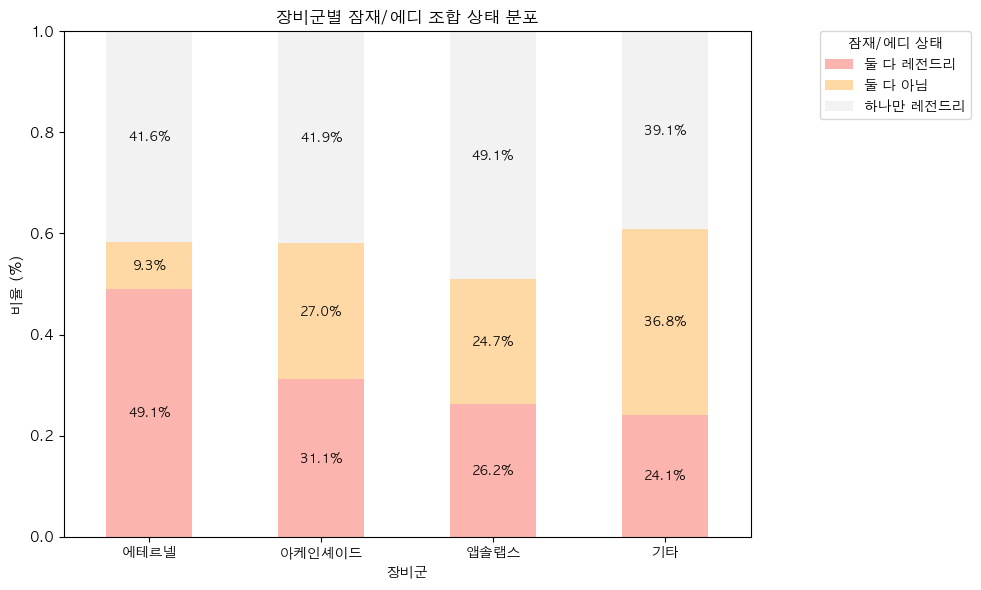

In [ ]:
# ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv("data/item_equipment/merged/total_item_merged.csv")

# Ïû•ÎπÑÍµ∞ Î∂ÑÎ•ò Ìï®Ïàò
def categorize_item(name):
    if 'Ïï±ÏÜîÎû©Ïä§' in name:
        return 'Ïï±ÏÜîÎû©Ïä§'
    elif 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú' in name:
        return 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú'
    elif 'ÏóêÌÖåÎ•¥ÎÑ¨' in name:
        return 'ÏóêÌÖåÎ•¥ÎÑ¨'
    else:
        return 'Í∏∞ÌÉÄ'

df['Ïû•ÎπÑÍµ∞'] = df['item_name'].apply(categorize_item)

# Ïû†Ïû¨/ÏóêÎîî Ï°∞Ìï© ÏÉÅÌÉú Íµ¨Î∂Ñ
def categorize_potential(row):
    pot = row['potential_option_grade']
    add = row['additional_potential_option_grade']
    if pot == 'Î†àÏ†ÑÎìúÎ¶¨' and add == 'Î†àÏ†ÑÎìúÎ¶¨':
        return 'Îëò Îã§ Î†àÏ†ÑÎìúÎ¶¨'
    elif pot == 'Î†àÏ†ÑÎìúÎ¶¨' or add == 'Î†àÏ†ÑÎìúÎ¶¨':
        return 'ÌïòÎÇòÎßå Î†àÏ†ÑÎìúÎ¶¨'
    else:
        return 'Îëò Îã§ ÏïÑÎãò'

df['Ïû†Ïû¨ÏÉÅÌÉú'] = df.apply(categorize_potential, axis=1)

# Ïû•ÎπÑÍµ∞ ÏàúÏÑú Í≥†Ï†ï
order = ['ÏóêÌÖåÎ•¥ÎÑ¨', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú', 'Ïï±ÏÜîÎû©Ïä§', 'Í∏∞ÌÉÄ']
df['Ïû•ÎπÑÍµ∞'] = pd.Categorical(df['Ïû•ÎπÑÍµ∞'], categories=order, ordered=True)

# ÍµêÏ∞®Ìëú ÎπÑÏú® Í≥ÑÏÇ∞
status_ratio = df.groupby(['Ïû•ÎπÑÍµ∞', 'Ïû†Ïû¨ÏÉÅÌÉú'], observed=False).size().unstack().fillna(0)
status_ratio = status_ratio.div(status_ratio.sum(axis=1), axis=0)  # ÎπÑÏú®Î°ú Î≥ÄÌôò

# ÎàÑÏ†Å ÎßâÎåÄÍ∑∏ÎûòÌîÑ
ax = status_ratio.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Pastel1')
plt.title('Ïû•ÎπÑÍµ∞Î≥Ñ Ïû†Ïû¨/ÏóêÎîî Ï°∞Ìï© ÏÉÅÌÉú Î∂ÑÌè¨')
plt.ylabel('ÎπÑÏú® (%)')
plt.ylim(0, 1)
plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Ïû†Ïû¨/ÏóêÎîî ÏÉÅÌÉú', loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0.)
plt.tight_layout()

# ÏàòÏπò ÎùºÎ≤® Ï∂îÍ∞Ä
for i, (index, row) in enumerate(status_ratio.iterrows()):
    cum_sum = 0
    for category in status_ratio.columns:
        value = row[category]
        if value > 0.02:  # 2% Ïù¥ÏÉÅÏùº ÎïåÎßå ÌëúÏãú
            ax.text(
                i, cum_sum + value / 2,
                f'{value*100:.1f}%',
                ha='center', va='center', fontsize=9, color='black'
            )
        cum_sum += value

plt.show()

### Ï∂îÎ°† ÌÜµÍ≥Ñ

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# ÍµêÏ∞®Ìëú ÏÉùÏÑ± (Ïû•ÎπÑÍµ∞ vs Ïû†Ïû¨ÏÉÅÌÉú)
contingency_table = pd.crosstab(df['Ïû•ÎπÑÍµ∞'], df['Ïû†Ïû¨ÏÉÅÌÉú'])

# Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ï ÏàòÌñâ
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cram√©r's V Í≥ÑÏÇ∞
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# Ï∂úÎ†•
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("Cram√©r's V:", cramers_v)

# Ìï¥ÏÑù
alpha = 0.05
if p < alpha:
    print("Í∑ÄÎ¨¥Í∞ÄÏÑ§ Í∏∞Í∞Å: Ïû•ÎπÑÍµ∞Í≥º Ïû†Ïû¨/ÏóêÎîî Ï°∞Ìï© ÏÉÅÌÉúÎäî ÎèÖÎ¶ΩÏù¥ ÏïÑÎãò ‚Üí ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏûàÏùå.")
else:
    print("Í∑ÄÎ¨¥Í∞ÄÏÑ§ Ï±ÑÌÉù: Ïû•ÎπÑÍµ∞Í≥º Ïû†Ïû¨/ÏóêÎîî Ï°∞Ìï© ÏÉÅÌÉúÎäî ÎèÖÎ¶ΩÏûÑ ‚Üí ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏóÜÏùå.")

Chi-square statistic: 75903.93090995013
Degrees of freedom: 6
P-value: 0.0
Cram√©r's V: 0.10901068206905731
Í∑ÄÎ¨¥Í∞ÄÏÑ§ Í∏∞Í∞Å: Ïû•ÎπÑÍµ∞Í≥º Ïû†Ïû¨/ÏóêÎîî Ï°∞Ìï© ÏÉÅÌÉúÎäî ÎèÖÎ¶ΩÏù¥ ÏïÑÎãò ‚Üí ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏûàÏùå.


### ÏµúÏ¢Ö Ï†ïÎ¶¨
----
Ìï¥ÏÑù Î∞è Í≤∞Í≥º
- Ìï¥ÏÑù : Í∞Å Î∞©Ïñ¥Íµ¨ ÏÑ∏Ìä∏ÏôÄ Ïû†Ïû¨/ÏóêÎîî ÏÉÅÌÉú Í∞ÑÏùò Ï∞®Ïù¥Î•º ÏãúÍ∞ÅÌôîÌïú Í≤∞Í≥º, Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ïÏóêÏÑú Ïú†ÏùòÎØ∏Ìïú Ï∞®Ïù¥(p-value < 0.05)Îäî ÏûàÏóàÏßÄÎßå, Ìö®Í≥ºÌÅ¨Í∏∞(Cram√©r's V = 0.109)Îäî Îß§Ïö∞ ÏûëÏïÑ Í∞ÄÍ≤©ÎåÄÏôÄ ÏòµÏÖòÍ∞ÑÏùò Í¥ÄÍ≥ÑÏùò ÌÅ¨Í∏∞Îäî ÎØ∏ÎØ∏Ìï®

- Í≤∞Í≥º : ÏïÑÏù¥ÌÖúÏù¥ Í≥†Í∞ÄÏùºÏàòÎ°ù Ïû†Ïû¨Îä•Î†•Í≥º ÏóêÎîîÏÖîÎÑêÏùò Îì±Í∏âÏù¥ Îëò Îã§ Î†àÏ†ÑÎìúÎ¶¨Ïù∏ ÎπÑÏú®ÏùÄ ÎÜíÏßÄÎßå, Í∑∏ Í¥ÄÍ≥ÑÏùò ÌÅ¨Í∏∞(ÏÉÅÍ¥ÄÏÑ±)Îäî Îß§Ïö∞ ÏûëÏùå

## Í∞ÄÏÑ§ 3
----

ÎßéÏùÄ Ïú†Ï†ÄÎì§Ïù¥ ÏïÑÏù¥ÌÖú Î†àÎ≤®Î≥Ñ 'ÏµúÏÜå ÏàòÏ§Ä'Ïóê Ìï¥ÎãπÌïòÎäî Í∏â Ïù¥ÏÉÅÏùò Ï∂îÍ∞ÄÏòµÏÖòÏùÑ ÏÇ¨Ïö©ÌïòÍ≥† ÏûàÏùÑ Í≤ÉÏù¥Îã§.

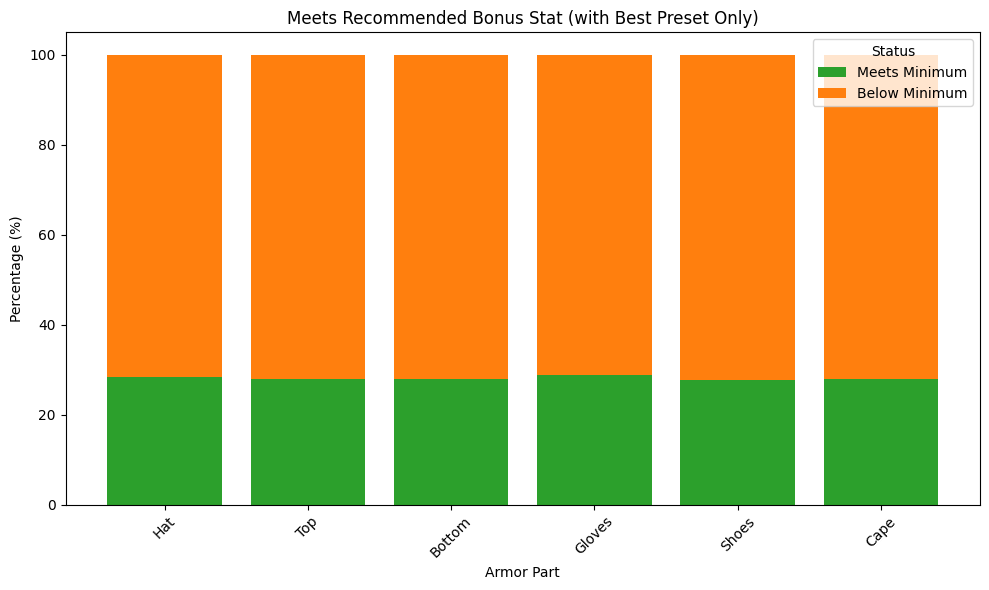

In [ ]:
# Î∞©Ïñ¥Íµ¨ Î∂ÄÏúÑÎ≥Ñ 'Íµ≠ÎØºÏ∂îÏòµ' ÏàòÏπò Ï∂©Ï°± Ïó¨Î∂Ä ÌôïÏù∏

# Î∞©Ïñ¥Íµ¨ Î∂ÄÏúÑÎ≥Ñ ÎßµÌïë
armor_name_map = {
    "Î™®Ïûê": "Hat", "ÏÉÅÏùò": "Top", "ÌïòÏùò": "Bottom",
    "Ïû•Í∞ë": "Gloves", "Ïã†Î∞ú": "Shoes", "ÎßùÌÜ†": "Cape" # Ïñ¥Íπ®Ïû•ÏãùÏùò Í≤ΩÏö∞ Ï∂îÏòµÏù¥ Î∂ôÏßÄ ÏïäÏïÑ Ï†úÏô∏
}
armor_order = ["Hat", "Top", "Bottom", "Gloves", "Shoes", "Cape"]

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df_best["main_stat_type"] = item_df_best.apply(get_main_stat, axis=1)

def get_minimum_threshold(level, stat_type):
    if stat_type == "HP":
        return level * 15
    elif stat_type == "ALL":
        if level >= 250:
            return 330
        elif level >= 200:
            return 280
        elif level >= 160:
            return 240
        elif level >= 150:
            return 230
        elif level >= 140:
            return 220
    else:
        if level >= 250:
            return 160
        elif level >= 200:
            return 140
        elif level >= 160:
            return 120
        elif level >= 140:
            return 110
    return None

def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None:
        return None
    allstat = row["all_stat_add"] * (20 if stat == "ALL" else 10)
    if stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"]
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    elif stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df_best["bonus_stat_total"] = item_df_best.apply(calculate_bonus_stat, axis=1)
item_df_best["recommended_min"] = item_df_best.apply(
    lambda row: get_minimum_threshold(row["base_equipment_level_base"], row["main_stat_type"]), axis=1
)
item_df_best["meets_minimum"] = item_df_best["bonus_stat_total"] >= item_df_best["recommended_min"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(armor_name_map)

filtered = item_df_best[item_df_best["equipment_part_eng"].isin(armor_order)]
part_group = filtered.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex(armor_order)

# ÏãúÍ∞ÅÌôî
colors = {True: "#2ca02c", False: "#ff7f0e"}
bottom = None
plt.figure(figsize=(10, 6))
for label in [True, False]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="Meets Minimum" if label else "Below Minimum",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Meets Recommended Bonus Stat (with Best Preset Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Armor Part")
plt.xticks(rotation=45)
plt.legend(title="Status")
plt.tight_layout()
plt.show()

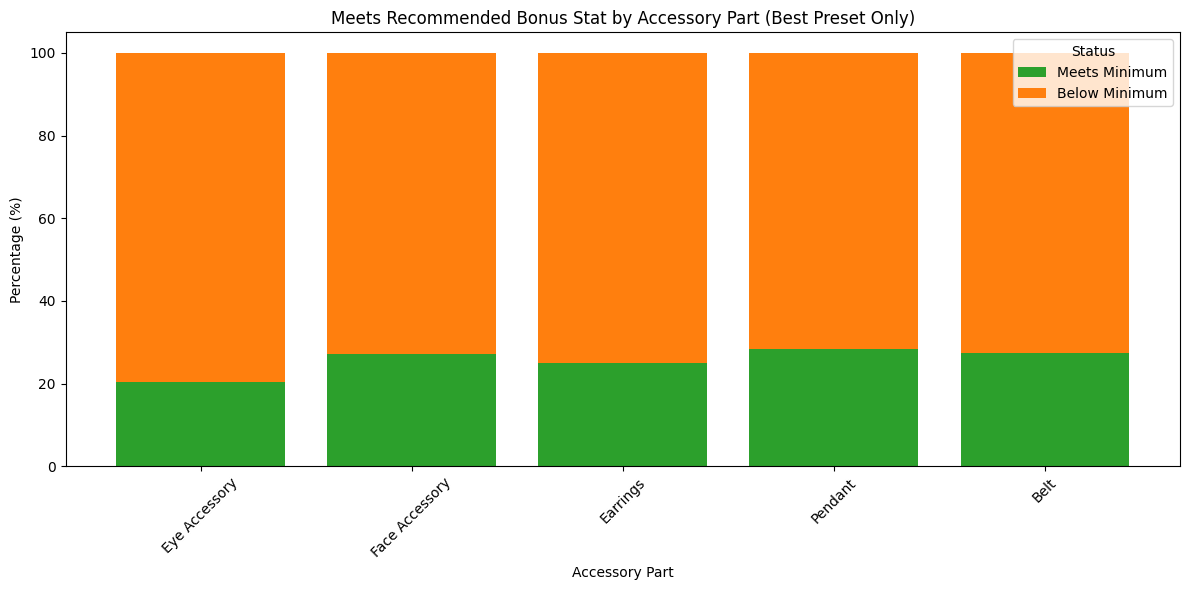

In [ ]:
# Ïû•Ïã†Íµ¨ Î∂ÄÏúÑÎ≥Ñ 'Íµ≠ÎØºÏ∂îÏòµ' ÏàòÏπò Ï∂©Ï°± Ïó¨Î∂Ä ÌôïÏù∏

# Ïû•Ïã†Íµ¨ Ïù¥Î¶Ñ Îß§Ìïë
accessory_name_map = {
    "ÎààÏû•Ïãù": "Eye Accessory", "ÏñºÍµ¥Ïû•Ïãù": "Face Accessory", "Î≤®Ìä∏": "Belt",
    "ÌéúÎçòÌä∏": "Pendant", "Í∑ÄÍ≥†Î¶¨": "Earrings"
}
accessory_order = [accessory_name_map[k] for k in ["ÎààÏû•Ïãù", "ÏñºÍµ¥Ïû•Ïãù", "Í∑ÄÍ≥†Î¶¨", "ÌéúÎçòÌä∏", "Î≤®Ìä∏"]]

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df_best["main_stat_type"] = item_df_best.apply(get_main_stat, axis=1)

def get_minimum_threshold(level, stat_type):
    if stat_type == "HP":
        return level * 15
    elif stat_type == "ALL":
        if level >= 250: return 330
        elif level >= 200: return 280
        elif level >= 160: return 240
        elif level >= 150: return 230
        elif level >= 140: return 220
    else:
        if level >= 250: return 160
        elif level >= 200: return 140
        elif level >= 160: return 120
        elif level >= 140: return 110
    return None

def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None: return None
    allstat = row["all_stat_add"] * (20 if stat == "ALL" else 10)
    if stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"] + allstat
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    elif stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df_best["bonus_stat_total"] = item_df_best.apply(calculate_bonus_stat, axis=1)
item_df_best["recommended_min"] = item_df_best.apply(
    lambda row: get_minimum_threshold(row["base_equipment_level_base"], row["main_stat_type"]), axis=1
)
item_df_best["meets_minimum"] = item_df_best["bonus_stat_total"] >= item_df_best["recommended_min"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(accessory_name_map)

filtered = item_df_best[item_df_best["equipment_part_eng"].isin(accessory_order)]
part_group = filtered.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
part_group.columns = part_group.columns.astype(str)

# ÎàÑÎùΩÎêú Ïó¥ Ï∂îÍ∞Ä (Î¨∏ÏûêÏó¥Î°ú Ï≤¥ÌÅ¨)
for col in ["True", "False"]:
    if col not in part_group.columns:
        part_group[col] = 0

# ÏàúÏÑú Í≥†Ï†ï
part_group = part_group[["True", "False"]]

# ÎπÑÏú® Í≥ÑÏÇ∞
percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex(accessory_order)

# ÏãúÍ∞ÅÌôî
colors = {"True": "#2ca02c", "False": "#ff7f0e"}
bottom = None

plt.figure(figsize=(12, 6))
for label in ["True", "False"]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="Meets Minimum" if label == "True" else "Below Minimum",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Meets Recommended Bonus Stat by Accessory Part (Best Preset Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Accessory Part")
plt.xticks(rotation=45)
plt.legend(title="Status")
plt.tight_layout()
plt.show()

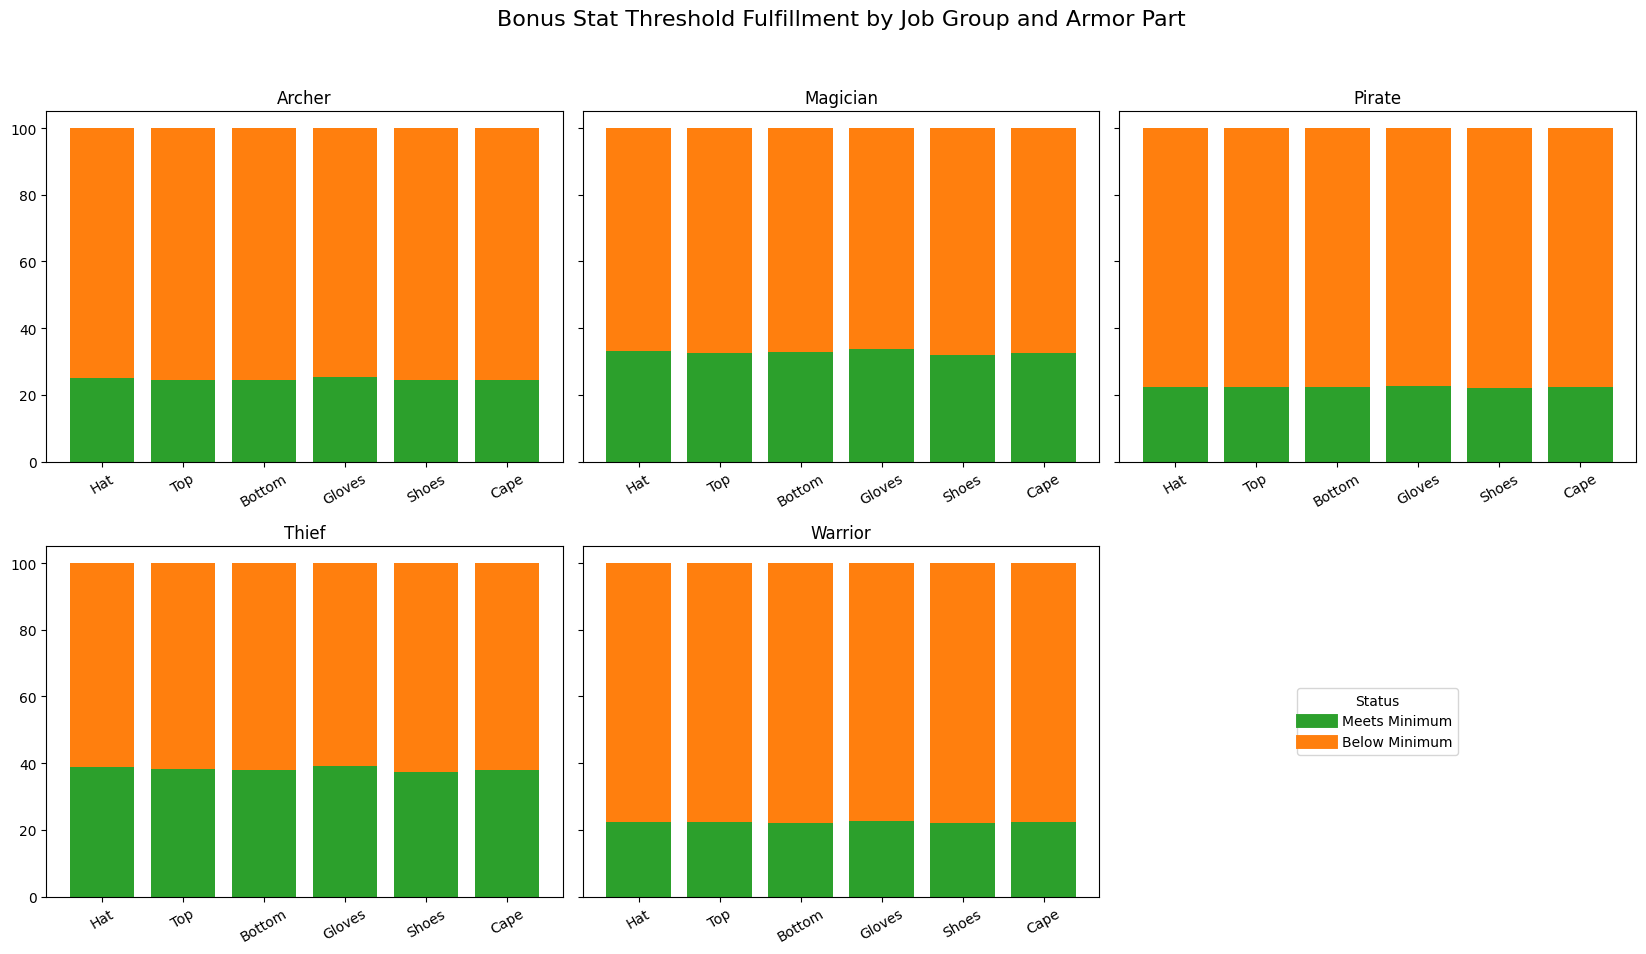

In [ ]:
# Î∞©Ïñ¥Íµ¨ Î∂ÄÏúÑÎ≥Ñ 'Íµ≠ÎØºÏ∂îÏòµ' ÏàòÏπò Ï∂©Ï°± Ïó¨Î∂Ä ÌôïÏù∏(ÏßÅÏóÖÍµ∞Î≥ÑÎ°ú ÏÇ¥Ìé¥Î≥¥Í∏∞)

# ÌïúÍ∏Ä Î¨∏ÏûêÏó¥Ïóê Ïú†ÎãàÏΩîÎìú Ï†ïÍ∑úÌôî Ï†ÅÏö©
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# ÏßÅÏóÖÍµ∞ Îß§Ìïë
job_group_map = {
    "Ï†ÑÏÇ¨": "Warrior",
    "ÎßàÎ≤ïÏÇ¨": "Magician",
    "Í∂ÅÏàò": "Archer",
    "ÎèÑÏ†Å": "Thief",
    "Ìï¥Ï†Å": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(job_group_map)

# Î∞©Ïñ¥Íµ¨ Î∂ÄÏúÑÎ≥Ñ ÎßµÌïë
armor_name_map = {
    "Î™®Ïûê": "Hat", "ÏÉÅÏùò": "Top", "ÌïòÏùò": "Bottom",
    "Ïû•Í∞ë": "Gloves", "Ïã†Î∞ú": "Shoes", "ÎßùÌÜ†": "Cape" # Ïñ¥Íπ®Ïû•ÏãùÏùò Í≤ΩÏö∞ Ï∂îÏòµÏù¥ Î∂ôÏßÄ ÏïäÏïÑ Ï†úÏô∏
}
armor_order = ["Hat", "Top", "Bottom", "Gloves", "Shoes", "Cape"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(armor_name_map)

# Ïú†Ìö®Ìïú Î∞©Ïñ¥Íµ¨ Î∂ÄÏúÑÎßå ÌïÑÌÑ∞ÎßÅ
filtered = item_df_best[
    item_df_best["equipment_part_eng"].isin(armor_order) &
    item_df_best["job_group_eng"].notna()
]

# ÏßÅÏóÖÍµ∞ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
job_groups = sorted(filtered["job_group_eng"].unique())

# subplot Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharey=True)
axes = axes.flatten()

colors = {True: "#2ca02c", False: "#ff7f0e"}

# Î∂àÌïÑÏöîÌïú subplot Ïù∏Îç±Ïä§ Ï∂îÏ†ÅÏö©
plotted_indices = []

# ÏßÅÏóÖÍµ∞Î≥Ñ subplot Í∑∏Î¶¨Í∏∞
for i, group in enumerate(job_groups):
    ax = axes[i]
    plotted_indices.append(i)

    subset = filtered[filtered["job_group_eng"] == group]
    part_group = subset.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
    part_group.columns = part_group.columns.astype(bool)

    percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex(armor_order)

    bottom = None
    for label in [True, False]:
        ax.bar(
            percent_df.index,
            percent_df[label],
            bottom=bottom,
            label="Meets Minimum" if label else "Below Minimum",
            color=colors[label]
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_title(group)
    ax.set_xticks(range(len(percent_df.index)))
    ax.set_xticklabels(percent_df.index, rotation=30)

# Îπà subplotÏóê Î≤îÎ°Ä ÎÑ£Í∏∞
for j in range(len(axes)):
    if j not in plotted_indices:
        axes[j].axis("off")  # Ï∂ï Í∫ºÏ£ºÍ≥†
        axes[j].legend(
            handles=[
                plt.Line2D([0], [0], color=colors[True], lw=10, label="Meets Minimum"),
                plt.Line2D([0], [0], color=colors[False], lw=10, label="Below Minimum")
            ],
            title="Status",
            loc='center'
        )

# Ï†ÑÏ≤¥ Ï†úÎ™© Îì± ÏÑ§Ï†ï
fig.suptitle("Bonus Stat Threshold Fulfillment by Job Group and Armor Part", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
plt.show()

In [ ]:
# Ïû•Ïã†Íµ¨ Î∂ÄÏúÑÎ≥Ñ 'Íµ≠ÎØºÏ∂îÏòµ' ÏàòÏπò Ï∂©Ï°± Ïó¨Î∂Ä ÌôïÏù∏(ÏßÅÏóÖÍµ∞Î≥ÑÎ°ú ÏÇ¥Ìé¥Î≥¥Í∏∞)

import unicodedata
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ÌïúÍ∏Ä Î¨∏ÏûêÏó¥Ïóê Ïú†ÎãàÏΩîÎìú Ï†ïÍ∑úÌôî Ï†ÅÏö©
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# ÏßÅÏóÖÍµ∞ Îß§Ìïë
job_group_map = {
    "Ï†ÑÏÇ¨": "Warrior",
    "ÎßàÎ≤ïÏÇ¨": "Magician",
    "Í∂ÅÏàò": "Archer",
    "ÎèÑÏ†Å": "Thief",
    "Ìï¥Ï†Å": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(job_group_map)

# Ïû•Ïã†Íµ¨ Î∂ÄÏúÑ Ïù¥Î¶Ñ Îß§Ìïë
accessory_name_map = {
    "ÎààÏû•Ïãù": "Eye Accessory",
    "ÏñºÍµ¥Ïû•Ïãù": "Face Accessory",
    "Î≤®Ìä∏": "Belt",
    "ÌéúÎçòÌä∏": "Pendant",
    "Í∑ÄÍ≥†Î¶¨": "Earrings"
}
accessory_order = [accessory_name_map[k] for k in ["ÎààÏû•Ïãù", "ÏñºÍµ¥Ïû•Ïãù", "Í∑ÄÍ≥†Î¶¨", "ÌéúÎçòÌä∏", "Î≤®Ìä∏"]]

# Ïû•Ïã†Íµ¨ Î∂ÄÏúÑ Îß§Ìïë
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(accessory_name_map)

# Ïú†Ìö®Ìïú Ïû•Ïã†Íµ¨ Î∂ÄÏúÑÎßå ÌïÑÌÑ∞ÎßÅ
filtered = item_df_best[
    item_df_best["equipment_part_eng"].isin(accessory_order) &
    item_df_best["job_group_eng"].notna()
]

# ÏßÅÏóÖÍµ∞ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
job_groups = sorted(filtered["job_group_eng"].unique())

# subplot Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharey=True)
axes = axes.flatten()

colors = {True: "#2ca02c", False: "#ff7f0e"}
plotted_indices = []

# ÏßÅÏóÖÍµ∞Î≥Ñ subplot Í∑∏Î¶¨Í∏∞
for i, group in enumerate(job_groups):
    ax = axes[i]
    plotted_indices.append(i)

    subset = filtered[filtered["job_group_eng"] == group]
    part_group = subset.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
    part_group.columns = part_group.columns.astype(bool)

    percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex(accessory_order)

    bottom = None
    for label in [True, False]:
        ax.bar(
            percent_df.index,
            percent_df[label],
            bottom=bottom,
            label="Meets Minimum" if label else "Below Minimum",
            color=colors[label]
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_title(group)
    ax.set_xticks(range(len(percent_df.index)))
    ax.set_xticklabels(percent_df.index, rotation=30)

# Îπà subplotÏóê Î≤îÎ°Ä ÎÑ£Í∏∞
for j in range(len(axes)):
    if j not in plotted_indices:
        axes[j].axis("off")
        axes[j].legend(
            handles=[
                mlines.Line2D([0], [0], color=colors[True], lw=10, label="Meets Minimum"),
                mlines.Line2D([0], [0], color=colors[False], lw=10, label="Below Minimum")
            ],
            title="Status",
            loc='center'
        )

# Ï†ÑÏ≤¥ Ï†úÎ™© ÏÑ§Ï†ï
fig.suptitle("Bonus Stat Threshold Fulfillment by Job Group and Accessory Part", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
plt.show()

ÏãúÍ∞ÅÌôî Í≤∞Í≥º: Ï∂îÍ∞ÄÏòµÏÖòÏùò 'ÏµúÏÜå ÏàòÏ§Ä'ÏùÑ Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§ÄÏúºÎ°ú ÎßûÏ∑ÑÏùÑ Îïå, Î∞©Ïñ¥Íµ¨ÏôÄ Ïû•Ïã†Íµ¨ Î™®Îëê ÎßéÏùÄ Ïú†Ï†ÄÎì§Ïù¥ Í∑∏ Í∏∞Ï§ÄÏùÑ ÎÑòÏßÄ Î™ªÌñàÎã§. **(Í∏∞Ï°¥ Í∞ÄÏÑ§ = FALSE)**
  - Ïù¥Îü¨Ìïú Í≤ΩÌñ•ÏÑ±ÏùÄ Î™®Îì† ÏßÅÏóÖÍµ∞ÏóêÏÑú Í≥µÌÜµÏ†ÅÏúºÎ°ú Î≥¥ÏòÄÎã§.

### Ï∂îÎ°† ÌÜµÍ≥Ñ

In [ ]:
item_df_best["equipment_part_eng"].unique()

array(['Earrings', nan, 'Eye Accessory', 'Belt', 'Face Accessory',
       'Pendant'], dtype=object)

In [ ]:
# Ï†ÑÏ≤¥ Ïú†Ï†Ä Í∏∞Ï§Ä(Î∞©Ïñ¥Íµ¨): Ïπ¥Ïù¥Ï†úÍ≥± Ï†ÅÌï©ÎèÑ Í≤ÄÏ†ï

# Í¥ÄÏ∏°Í∞í
armor_counts = filtered["meets_minimum"].value_counts().to_dict()
armor_observed = [armor_counts.get(True, 0), armor_counts.get(False, 0)]

# Í∏∞ÎåÄÍ∞í Í≥ÑÏÇ∞ Î∞è Í≤ÄÏ†ï
armor_expected = [sum(armor_observed) / 2] * 2
armor_chi2, armor_pval = chisquare(f_obs=armor_observed, f_exp=armor_expected)

print(f"Chi-square: {armor_chi2:.3f}, p-value: {armor_pval:.4f}")

Chi-square: 50706.229, p-value: 0.0000


- Í∑ÄÎ¨¥Í∞ÄÏÑ§(H‚ÇÄ): Ï†ÑÏ≤¥ Ïú†Ï†Ä Ï§ë Î∞©Ïñ¥Íµ¨ÏóêÏÑú 'Íµ≠ÎØºÏ∂îÏòµ' Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±Ìïú Ïú†Ï†ÄÏôÄ Ï∂©Ï°±ÌïòÏßÄ Î™ªÌïú Ïú†Ï†ÄÏùò ÎπÑÏú®ÏùÄ ÎèôÏùºÌïòÎã§.
- ÎåÄÎ¶ΩÍ∞ÄÏÑ§(H‚ÇÅ): Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÏßÄ Î™ªÌïú Ïú†Ï†ÄÍ∞Ä Ïú†ÏùòÎØ∏ÌïòÍ≤å ÎßéÎã§.
  - **p-value < Œ±(0.05)Î°ú, ÎåÄÎ¶ΩÍ∞ÄÏÑ§ÏùÑ Ï±ÑÌÉùÌïòÏó¨ Ï†ÑÏ≤¥ Ïú†Ï†Ä Ï§ë Î∞©Ïñ¥Íµ¨ÏóêÏÑú Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÏßÄ Î™ªÌïú Ïú†Ï†ÄÍ∞Ä Ïú†ÏùòÎØ∏ÌïòÍ≤å ÎßéÎã§Í≥† Ìï† Ïàò ÏûàÎã§.**

In [ ]:
# Ï†ÑÏ≤¥ Ïú†Ï†Ä Í∏∞Ï§Ä(Ïû•Ïã†Íµ¨): Ïπ¥Ïù¥Ï†úÍ≥± Ï†ÅÌï©ÎèÑ Í≤ÄÏ†ï

accessory_valid = item_df_best[
    item_df_best["equipment_part_eng"].isin(accessory_order) &
    item_df_best["meets_minimum"].isin([True, False])
]

# Í¥ÄÏ∏°Í∞í
accessory_counts = accessory_valid["meets_minimum"].value_counts().to_dict()
accessory_observed = [accessory_counts.get(True, 0), accessory_counts.get(False, 0)]

# Í∏∞ÎåÄÍ∞í Í≥ÑÏÇ∞ Î∞è Í≤ÄÏ†ï
accessory_expected = [sum(accessory_observed) / 2] * 2
accessory_chi2, accessory_pval = chisquare(f_obs=accessory_observed, f_exp=accessory_expected)

print(f"Chi-square: {accessory_chi2:.3f}, p-value: {accessory_pval:.4f}")

Chi-square: 52527.605, p-value: 0.0000


- Í∑ÄÎ¨¥Í∞ÄÏÑ§(H‚ÇÄ): Ï†ÑÏ≤¥ Ïú†Ï†Ä Ï§ë Ïû•Ïã†Íµ¨ÏóêÏÑú 'Íµ≠ÎØºÏ∂îÏòµ' Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±Ìïú Ïú†Ï†ÄÏôÄ Ï∂©Ï°±ÌïòÏßÄ Î™ªÌïú Ïú†Ï†ÄÏùò ÎπÑÏú®ÏùÄ ÎèôÏùºÌïòÎã§.
- ÎåÄÎ¶ΩÍ∞ÄÏÑ§(H‚ÇÅ): Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÏßÄ Î™ªÌïú Ïú†Ï†ÄÍ∞Ä Ïú†ÏùòÎØ∏ÌïòÍ≤å ÎßéÎã§.
  - **p-value < Œ±(0.05)Î°ú, ÎåÄÎ¶ΩÍ∞ÄÏÑ§ÏùÑ Ï±ÑÌÉùÌïòÏó¨ Ï†ÑÏ≤¥ Ïú†Ï†Ä Ï§ë Ïû•Ïã†Íµ¨ÏóêÏÑú Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÏßÄ Î™ªÌïú Ïú†Ï†ÄÍ∞Ä Ïú†ÏùòÎØ∏ÌïòÍ≤å ÎßéÎã§Í≥† Ìï† Ïàò ÏûàÎã§.**

In [ ]:
# ÏßÅÏóÖÍµ∞Í≥º Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂ÄÏùò Í¥ÄÎ†®ÏÑ± Í≤ÄÏ†ï(Î∞©Ïñ¥Íµ¨): Ïπ¥Ïù¥Ï†úÍ≥± ÎèÖÎ¶ΩÏÑ± Í≤ÄÏ†ï

# ÍµêÏ∞®Ìëú (ÏßÅÏóÖÍµ∞ vs Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂Ä)
crosstab = pd.crosstab(
    filtered["job_group_eng"],
    filtered["meets_minimum"]
)

# Ïπ¥Ïù¥Ï†úÍ≥± ÎèÖÎ¶ΩÏÑ± Í≤ÄÏ†ï
chi2, pval, dof, expected = chi2_contingency(crosstab)

# ÌÅ¨ÎûòÎ®∏Ïùò V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cram√©r‚Äôs V: {cramers_v:.4f}")

Chi-square: 5444.529, p-value: 0.0000
Cram√©r‚Äôs V: 0.1434


- Í∑ÄÎ¨¥Í∞ÄÏÑ§(H‚ÇÄ): ÏßÅÏóÖÍµ∞Í≥º Î∞©Ïñ¥Íµ¨Ïùò 'Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂Ä'Îäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥Îã§. (Ïñ¥Îñ§ ÏßÅÏóÖÏù¥Îì† Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÎäî ÎπÑÏú®Ïù¥ ÎπÑÏä∑)
- ÎåÄÎ¶ΩÍ∞ÄÏÑ§(H‚ÇÅ): ÏßÅÏóÖÍµ∞Í≥º Î∞©Ïñ¥Íµ¨Ïùò 'Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂Ä'Îäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥ ÏïÑÎãàÎã§. (ÏßÅÏóÖÍµ∞Ïóê Îî∞Îùº Í∏∞Ï§Ä Ï∂©Ï°± ÎπÑÏú®Ïù¥ Îã§Î¶Ñ)
  - **p-value < Œ±(0.05)Î°ú, ÎåÄÎ¶ΩÍ∞ÄÏÑ§ÏùÑ Ï±ÑÌÉùÌïòÏó¨ ÏßÅÏóÖÍµ∞Ïóê Îî∞Îùº Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÎäî ÎπÑÏú®Ïù¥ ÏÑúÎ°ú Îã§Î•¥Îã§Îäî ÏÇ¨Ïã§Ïù¥ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÏûÖÏ¶ùÎêòÏóàÎã§Í≥† Ìï† Ïàò ÏûàÎã§.**
  - Í∑∏Îü¨ÎÇò **Cram√©r‚Äôs V = 0.1434**Î°ú, **Í∞ïÌïú ÏÉÅÍ¥ÄÍπåÏßÄÎäî ÏïÑÎãàÎ©∞
ÏßÅÏóÖÍµ∞Í≥º Î¨¥Í¥ÄÌïòÍ≤å ÎπÑÏä∑Ìïú ÏÑ∏ÌåÖ Ï†ÑÎûµÏùÑ Í≥µÏú†ÌïòÎäî Ïú†Ï†ÄÎì§ÎèÑ Îã§Ïàò Ï°¥Ïû¨Ìï®ÏùÑ ÏãúÏÇ¨**ÌïúÎã§.

In [ ]:
# ÏßÅÏóÖÍµ∞Í≥º Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂ÄÏùò Í¥ÄÎ†®ÏÑ± Í≤ÄÏ†ï(Ïû•Ïã†Íµ¨): Ïπ¥Ïù¥Ï†úÍ≥± ÎèÖÎ¶ΩÏÑ± Í≤ÄÏ†ï

# ÍµêÏ∞®Ìëú (ÏßÅÏóÖÍµ∞ vs Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂Ä)
accessory_crosstab = pd.crosstab(
    accessory_valid["job_group_eng"],
    accessory_valid["meets_minimum"]
)

# Ïπ¥Ïù¥Ï†úÍ≥± ÎèÖÎ¶ΩÏÑ± Í≤ÄÏ†ï
accessory_chi2, accessory_pval, accessory_dof, accessory_expected = chi2_contingency(accessory_crosstab)

# ÌÅ¨ÎûòÎ®∏Ïùò V Í≥ÑÏÇ∞
accessory_n = accessory_crosstab.to_numpy().sum()
accessory_min_dim = min(accessory_crosstab.shape) - 1
accessory_cramers_v = np.sqrt(accessory_chi2 / (accessory_n * accessory_min_dim))

print(f"Chi-square: {accessory_chi2:.3f}, p-value: {accessory_pval:.4f}")
print(f"Cram√©r‚Äôs V: {accessory_cramers_v:.4f}")

Chi-square: 3809.819, p-value: 0.0000
Cram√©r‚Äôs V: 0.1310


- Í∑ÄÎ¨¥Í∞ÄÏÑ§(H‚ÇÄ): ÏßÅÏóÖÍµ∞Í≥º Ïû•Ïã†Íµ¨Ïùò 'Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂Ä'Îäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥Îã§. (Ïñ¥Îñ§ ÏßÅÏóÖÏù¥Îì† Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÎäî ÎπÑÏú®Ïù¥ ÎπÑÏä∑)
- ÎåÄÎ¶ΩÍ∞ÄÏÑ§(H‚ÇÅ): ÏßÅÏóÖÍµ∞Í≥º Ïû•Ïã†Íµ¨Ïùò 'Íµ≠ÎØºÏ∂îÏòµ Í∏∞Ï§Ä Ï∂©Ï°± Ïó¨Î∂Ä'Îäî ÏÑúÎ°ú ÎèÖÎ¶ΩÏù¥ ÏïÑÎãàÎã§. (ÏßÅÏóÖÍµ∞Ïóê Îî∞Îùº Í∏∞Ï§Ä Ï∂©Ï°± ÎπÑÏú®Ïù¥ Îã§Î¶Ñ)
  - **p-value < Œ±(0.05)Î°ú, ÎåÄÎ¶ΩÍ∞ÄÏÑ§ÏùÑ Ï±ÑÌÉùÌïòÏó¨ ÏßÅÏóÖÍµ∞Ïóê Îî∞Îùº Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÎäî ÎπÑÏú®Ïù¥ ÏÑúÎ°ú Îã§Î•¥Îã§Îäî ÏÇ¨Ïã§Ïù¥ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÏûÖÏ¶ùÎêòÏóàÎã§Í≥† Ìï† Ïàò ÏûàÎã§.**
  - Í∑∏Îü¨ÎÇò **Cram√©r‚Äôs V = 0.1310**ÏúºÎ°ú Í¥ÄÎ†®ÏÑ±ÏùÄ **Í∞ïÌïòÏßÄ ÏïäÏúºÎ©∞,
Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú Ïú†Ï†ÄÎì§ÏùÄ ÏßÅÏóÖÍµ∞Í≥º Î¨¥Í¥ÄÌïòÍ≤å Ïú†ÏÇ¨Ìïú Ïû•Ïã†Íµ¨ ÏÑ∏ÌåÖÏùÑ ÌïòÍ≥† ÏûàÎäî Í≤ΩÌñ•Ïù¥ Í∞ïÌïòÎã§.**

### **ÏµúÏ¢Ö Ï†ïÎ¶¨**
----
Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ïú†Ï†ÄÎì§ÏùÄ ÏïÑÏù¥ÌÖúÏùò Ï∂îÍ∞ÄÏòµÏÖòÏóêÏÑú Í∏∞ÎåÄÎêòÎäî 'Íµ≠ÎØºÏ∂îÏòµ' Í∏∞Ï§ÄÏùÑ Ï∂©Ï°±ÌïòÏßÄ Î™ªÌïòÍ≥† ÏûàÎäî Í≤ΩÌñ•Ïù¥ Í∞ïÌïòÎ©∞, Ïù¥ Í≤ΩÌñ•ÏùÄ Î∞©Ïñ¥Íµ¨ÏôÄ Ïû•Ïã†Íµ¨ Î™®ÎëêÏóêÏÑú ÏùºÍ¥ÄÎêòÍ≤å ÎÇòÌÉÄÎÇúÎã§.

ÏßÅÏóÖÍµ∞Ïóê Îî∞Îùº Ïñ¥Îäê Ï†ïÎèÑÏùò Ï∞®Ïù¥Îäî Ï°¥Ïû¨ÌïòÏßÄÎßå, Í∑∏ ÏòÅÌñ•Î†•ÏùÄ ÌÅ¨ÏßÄ ÏïäÏúºÎ©∞,
ÎåÄÎ∂ÄÎ∂ÑÏùò Ïú†Ï†ÄÎì§Ïù¥ ÏßÅÏóÖÍµ∞ÏùÑ Î∂àÎ¨∏ÌïòÍ≥† Ïú†ÏÇ¨Ìïú ÏàòÏ§ÄÏùò ÏÑ∏ÌåÖ Ï†ÑÎûµÏùÑ Îî∞Î•¥Í≥† ÏûàÎã§Îäî Ï†êÏóêÏÑú **'Í∏∞Ï§Ä ÎØ∏ÎßåÏùò Ï∂îÍ∞ÄÏòµÏÖò ÏÇ¨Ïö©'Ïù¥ Î≥¥Ìé∏Ï†Å ÌòÑÏã§ÏûÑÏù¥ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÏûÖÏ¶ùÎêòÏóàÎã§**Í≥† Î≥º Ïàò ÏûàÎã§.

-----
# Ï†ÑÏ≤òÎ¶¨

- item.csv

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/data/preprocessing/item.csv", low_memory=False)

In [ ]:
# Ï†ÑÏ≤¥ ÏπºÎüºÏóê ÎåÄÌïú Ï†ïÎ≥¥ ÌôïÏù∏ -> 113 columns
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 113 columns):
 #    Column                             Non-Null Count    Dtype  
---   ------                             --------------    -----  
 0    nickname                           1063724 non-null  object 
 1    world                              1063724 non-null  object 
 2    level                              1063724 non-null  int64  
 3    job                                1063724 non-null  object 
 4    subclass                           1063724 non-null  object 
 5    preset_number                      1063724 non-null  int64  
 6    equipment_part                     1063724 non-null  object 
 7    equipment_slot                     1063724 non-null  object 
 8    item_name                          1063724 non-null  object 
 9    str_total                          1063724 non-null  int64  
 10   dex_total                          1063724 non-null  int64  
 11   int_total

## (1) Î∂àÌïÑÏöîÌïú ÏπºÎüº Ï†úÍ±∞

In [ ]:
# Î∂àÌïÑÏöîÌïú ÏπºÎüº ÎìúÎûç: Ïû•ÎπÑÏùò Í∏∞Î≥∏ Îä•Î†•Ïπò Ï†ïÎ≥¥
cols_to_drop = [
    "str_base", "dex_base", "int_base", "luk_base",
    "max_hp_base", "max_mp_base",
    "attack_power_base", "magic_power_base", "armor_base",
    "speed_base", "jump_base",
    "boss_damage_base", "ignore_monster_armor_base",
    "all_stat_base", "max_hp_rate_base", "max_mp_rate_base",
    "base_equipment_level_base"
]

df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
df.info() # 96 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 96 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   nickname                           1063724 non-null  object 
 1   world                              1063724 non-null  object 
 2   level                              1063724 non-null  int64  
 3   job                                1063724 non-null  object 
 4   subclass                           1063724 non-null  object 
 5   preset_number                      1063724 non-null  int64  
 6   equipment_part                     1063724 non-null  object 
 7   equipment_slot                     1063724 non-null  object 
 8   item_name                          1063724 non-null  object 
 9   str_total                          1063724 non-null  int64  
 10  dex_total                          1063724 non-null  int64  
 11  int_total               

### Ïû•ÎπÑ ÏµúÏ¢Ö ÏòµÏÖò
----
Ï†ÑÎûµ: Ï£ºÏä§ÌÉØÏóê ÎßûÏßÄ ÏïäÎäî Îä•Î†•Ïπò ÏπºÎüº Ï†úÍ±∞ ÌõÑ ÌïòÎÇòÏùò Ïó¥Î°ú ÌÜµÏùº

In [ ]:
# ÏßÅÏóÖÎ≥Ñ Ï£ºÏä§ÌÉØ Í∏∞Ï§Ä Ïó¥ ÏÇ≠Ï†ú ÏΩîÎìú
# 1. Ï£ºÏä§ÌÉØÏóê ÎßûÏßÄ ÏïäÎäî Îä•Î†•Ïπò ÏπºÎüº Ï†úÍ±∞
# 2. INT ÏßÅÏóÖÏùÄ attack_power_total Ï†úÍ±∞, ÎπÑ INT ÏßÅÏóÖÏùÄ magic_power_total Ï†úÍ±∞
# 3. Í≥µÌÜµÏ†ÅÏúºÎ°ú Ï†úÍ±∞Ìï† Ïª¨Îüº: armor, speed, jump, equipment_level_decrease, max_hp_rate, max_mp_rate
# 4. Î≥¥Ï°¥ Ïª¨Îüº: boss_damage_total, ignore_monster_armor_total, all_stat_total, damage_total

# Ï£ºÏöî Ïä§ÌÉØ Í¥ÄÎ†® Ïó¥Îßå Îî∞Î°ú Ï†ïÏùò
stat_related_cols = [
    "str_total", "dex_total", "int_total", "luk_total",
    "max_hp_total", "max_mp_total",
    "attack_power_total", "magic_power_total",
    "armor_total", "speed_total", "jump_total",
    "equipment_level_decrease_total", "max_hp_rate_total", "max_mp_rate_total",
    "boss_damage_total", "ignore_monster_armor_total", "all_stat_total", "damage_total"
]

# 2. ÏßÅÏóÖÎ≥Ñ Ï£ºÏä§ÌÉØ Îß§Ìïë
main_stat_map = {
    "STR": ["ÌûàÏñ¥Î°ú", "ÏïÑÎç∏", "ÏÜåÏö∏ÎßàÏä§ÌÑ∞", "ÏïÑÎûÄ", "Ï†úÎ°ú", "ÌåîÎùºÎîò", "Îã§ÌÅ¨ÎÇòÏù¥Ìä∏", "Ïπ¥Ïù¥Ï†Ä",
            "Îç∞Î™¨Ïä¨Î†àÏù¥Ïñ¥", "ÎØ∏ÌïòÏùº", "Î∏îÎûòÏä§ÌÑ∞", "ÏùÄÏõî", "Î∞îÏù¥Ìçº", "Ïä§Ìä∏ÎùºÏù¥Ïª§", "Ï∫êÎÖºÎßàÏä§ÌÑ∞", "ÏïÑÌÅ¨"],
    "DEX": ["ÏúàÎìúÎ∏åÎ†àÏù¥Ïª§", "Î©îÎ•¥ÏÑ∏Îç∞Ïä§", "Î≥¥Ïö∞ÎßàÏä§ÌÑ∞", "Ìå®Ïä§ÌååÏù∏Îçî", "Ïã†Í∂Å", "Ïπ¥Ïù∏", "ÏôÄÏùºÎìúÌóåÌÑ∞",
            "ÏóîÏ†§Î¶≠Î≤ÑÏä§ÌÑ∞", "Ï∫°Ìã¥", "Î©îÏπ¥Îãâ"],
    "INT": ["ÎπÑÏàç", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Î∂à,ÎèÖ)", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Ïç¨,ÏΩú)", "ÎùºÎùº", "Î∞∞ÌãÄÎ©îÏù¥ÏßÄ", "ÏóêÎ∞ò", "Î£®ÎØ∏ÎÑàÏä§",
            "ÌÇ§ÎÑ§ÏãúÏä§", "ÌîåÎ†àÏûÑÏúÑÏûêÎìú", "ÏùºÎ¶¨ÏõÄ"],
    "LUK": ["ÎÇòÏù¥Ìä∏ÏõåÏª§", "ÏÑÄÎèÑÏñ¥", "ÎÇòÏù¥Ìä∏Î°úÎìú", "ÎìÄÏñºÎ∏îÎ†àÏù¥Îçî", "Ìå¨ÌÖÄ", "Ìò∏ÏòÅ", "ÏπºÎ¶¨", "Ïπ¥Îç∞ÎÇò"],
    "HP": ["Îç∞Î™¨Ïñ¥Î≤§Ï†∏"],
    "STR_DEX_LUK": ["Ï†úÎÖº"]
}
job_to_main_stat = {job: stat for stat, jobs in main_stat_map.items() for job in jobs}
df["main_stat_type"] = df["subclass"].map(job_to_main_stat)

# 3. Ïó¥Î≥ÑÎ°ú ÏßÅÏóÖ Ï°∞Í±¥ Í∏∞Î∞ò Í≤∞Ï∏° Ï≤òÎ¶¨
# Í≥µÌÜµ Ï†úÍ±∞ ÎåÄÏÉÅ
global_drop_cols = [
    "armor_total", "speed_total", "jump_total",
    "equipment_level_decrease_total", "max_hp_rate_total", "max_mp_rate_total"
]
for col in global_drop_cols:
    if col in df.columns:
        df.loc[:, col] = pd.NA

# Ï£ºÏä§ÌÉØÎ≥ÑÎ°ú Ïú†ÏßÄ Ï°∞Í±¥ Ï≤òÎ¶¨
if "str_total" in df.columns:
    df.loc[~df["main_stat_type"].isin(["STR", "STR_DEX_LUK"]), "str_total"] = pd.NA
if "dex_total" in df.columns:
    df.loc[~df["main_stat_type"].isin(["DEX", "STR_DEX_LUK"]), "dex_total"] = pd.NA
if "int_total" in df.columns:
    df.loc[df["main_stat_type"] != "INT", "int_total"] = pd.NA
if "luk_total" in df.columns:
    df.loc[~df["main_stat_type"].isin(["LUK", "STR_DEX_LUK"]), "luk_total"] = pd.NA
if "max_hp_total" in df.columns:
    df.loc[df["main_stat_type"] != "HP", "max_hp_total"] = pd.NA
if "max_mp_total" in df.columns:
    df.loc[:, "max_mp_total"] = pd.NA  # Ìï≠ÏÉÅ Ï†úÍ±∞ ÎåÄÏÉÅ

# Í≥µÍ≤©Î†•/ÎßàÎ†• Ï≤òÎ¶¨
if "attack_power_total" in df.columns:
    df.loc[df["main_stat_type"] == "INT", "attack_power_total"] = pd.NA
if "magic_power_total" in df.columns:
    df.loc[df["main_stat_type"] != "INT", "magic_power_total"] = pd.NA

<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = pd.NA
<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = pd.NA
<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = pd.NA
<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible w

In [ ]:
# str_total, dex_total, int_total, luk_total, max_hp_totalÏùÑ ÌâÅÏ≥êÏÑú mainstat_totalÏù¥ÎùºÎäî ÌïòÎÇòÏùò Ïó¥Î°ú ÎßåÎì§Í∏∞

import numpy as np

# Ï†úÎÖº ÏßÅÏóÖ Í∏∞Ï§ÄÏúºÎ°ú 3Ïä§ÌÉØ Ìï©ÏÇ∞ Ï†ÅÏö©
main_stats = df["subclass"]

# Ï†úÎÖº Ïó¨Î∂Ä
is_zenon = main_stats == "Ï†úÎÖº"
non_zenon = ~is_zenon

# Í∞Å Ïó¥ ÌÉÄÏûÖ Ï†ïÎ¶¨
cols_to_merge = ["str_total", "dex_total", "int_total", "luk_total", "max_hp_total"]
for col in cols_to_merge:
    if col in df.columns:
        df[col] = df[col].astype("float64")

# 1. Ï†úÎÖºÏùÄ str + dex + luk Ìï©ÏÇ∞
df["mainstat_total"] = np.nan
df.loc[is_zenon, "mainstat_total"] = df.loc[is_zenon, ["str_total", "dex_total", "luk_total"]].sum(axis=1, skipna=True)

# 2. Í∑∏ Ïô∏Îäî Í∏∞Ï°¥Ï≤òÎüº Ïö∞ÏÑ†ÏàúÏúÑ Í∏∞Î∞ò bfill
df.loc[non_zenon, "mainstat_total"] = df.loc[non_zenon, cols_to_merge].bfill(axis=1).iloc[:, 0]

# 3. Ï†ïÎ¶¨ ÌõÑ ÌïÑÏöî ÏóÜÎäî Ïó¥ Ï†úÍ±∞
cols_to_drop = [
    "str_total", "dex_total", "int_total", "luk_total", "preset_number", "max_mp_total", "max_hp_total",
    "armor_total", "speed_total", "jump_total"
]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [ ]:
# attack_power_totalÍ≥º magic_power_totalÏùÑ ÌïòÎÇòÏùò Ïó¥ power_totalÎ°ú ÌÜµÌï©

# ÏàòÏπòÌòï Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨Î•º ÏúÑÌï¥ float64Î°ú Î≥ÄÌôò
df["attack_power_total"] = df["attack_power_total"].astype("float64")
df["magic_power_total"] = df["magic_power_total"].astype("float64")

# Îëê Ïó¥ Ï§ë Í≤∞Ï∏°Ïù¥ ÏïÑÎãå Í∞íÏùÑ ÏÑ†ÌÉù
df["power_total"] = df[["attack_power_total", "magic_power_total"]].bfill(axis=1).iloc[:, 0]

# Í∏∞Ï°¥ Ïó¥ ÏÇ≠Ï†ú
df.drop(columns=["attack_power_total", "magic_power_total"], inplace=True)

# Î∂àÌïÑÏöîÌïú Ïó¥ Ìïú Î≤à Îçî ÎìúÎ°≠
cols_to_drop = ["equipment_level_decrease_total", "max_hp_rate_total", "max_mp_rate_total"]
df.drop(columns=cols_to_drop, inplace=True)

### Ïû•ÎπÑ Ïû†Ïû¨Îä•Î†• + ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†•
----
Ï†ÑÎûµ:
- Ïû†Ïû¨Îä•Î†•: S-FÎì±Í∏â Ï§ë S-B Îì±Í∏âÏóê Ìï¥ÎãπÌïòÎäî ÏòµÏÖòÎßå ÎÇ®Í≤®ÎëêÍ≥†, ÎÇòÎ®∏ÏßÄ ÏòµÏÖòÏùÄ 'Í∏∞ÌÉÄ'Î°ú Î∂ÑÎ•ò

In [ ]:
# Î©îÎ™®Î¶¨ Ìö®Ïú®ÏùÑ ÏúÑÌï¥ Î≤°ÌÑ∞Ìôî Î∞©ÏãùÏúºÎ°ú Îì±Í∏â Î∂ÑÎ•ò Ï≤òÎ¶¨(Ïû†Ïû¨Îä•Î†•)

# step 1: S~B ÌÇ§ÏõåÎìú Ï†ïÏùò
grade_keywords = {
    "S": [
        "Î≥¥Ïä§ Î™¨Ïä§ÌÑ∞ Í≥µÍ≤© Ïãú Îç∞ÎØ∏ÏßÄ", "Í≥µÍ≤©Î†• : +%", "ÎßàÎ†• : +%", "Ïò¨Ïä§ÌÉØ : +%", "Î™¨Ïä§ÌÑ∞ Î∞©Ïñ¥Ïú® Î¨¥Ïãú",
        "Î™®Îì† Ïä§ÌÇ¨Ïùò Ïû¨ÏÇ¨Ïö© ÎåÄÍ∏∞ÏãúÍ∞Ñ", "ÏïÑÏù¥ÌÖú ÎìúÎ°≠Î•†", "Î©îÏÜå ÌöçÎìùÎüâ"
    ],
    "A": [
        "ÌÅ¨Î¶¨Ìã∞Ïª¨ Îç∞ÎØ∏ÏßÄ"
    ],
    "B": [
        "Í≥µÍ≤©Î†• : +32", "ÎßàÎ†• : +32", "ÌÅ¨Î¶¨Ìã∞Ïª¨ ÌôïÎ•† :"
    ]
}

# step 2: Îã®Ïùº Ïä§ÌÉØ % Ìå®ÌÑ¥
stat_keywords = ["STR : +", "DEX : +", "INT : +", "LUK : +"]

# step 3: ÏßÅÏóÖÎ≥Ñ ÏòàÏô∏ Ï°∞Í±¥ Ï≤òÎ¶¨Ïö© ÏÇ¨Ï†Ñ
job_special = {
    "Ïì∏ÎßåÌïú ÌïòÏù¥Ìçº Î∞îÎîî": {
        "S": {"Îç∞Î™¨Ïñ¥Î≤§Ï†∏", "Ï†úÎÖº"},
        "B": {"ÎπÑÏàç"}
    }
}

# step 4: Î≤°ÌÑ∞Ìôî Î∞©ÏãùÏúºÎ°ú Ïó¥Î≥Ñ Îì±Í∏â Ï≤òÎ¶¨
def grade_vectorized(df, colname, subclass_col="subclass"):
    out = np.full(len(df), "Í∏∞ÌÉÄ", dtype=object)

    # ÏßÅÏóÖÎ≥Ñ ÌäπÏàò ÏòµÏÖò Ïö∞ÏÑ† Ï≤òÎ¶¨
    if "Ïì∏ÎßåÌïú ÌïòÏù¥Ìçº Î∞îÎîî" in df[colname].astype(str).values.tolist():
        for grade, jobset in job_special["Ïì∏ÎßåÌïú ÌïòÏù¥Ìçº Î∞îÎîî"].items():
            mask = df[colname].str.contains("Ïì∏ÎßåÌïú ÌïòÏù¥Ìçº Î∞îÎîî", na=False) & df[subclass_col].isin(jobset)
            out[mask] = grade

    # Îã®Ïùº Ïä§ÌÉØ % Ï¶ùÍ∞ÄÎäî S
    for stat in stat_keywords:
        mask = df[colname].str.contains(stat, na=False) & df[colname].str.contains("%", na=False)
        out[mask] = "S"

    # ÏùºÎ∞ò ÌÇ§ÏõåÎìú Ï≤òÎ¶¨
    for grade, patterns in grade_keywords.items():
        for pat in patterns:
            mask = df[colname].str.contains(pat, na=False) & (out == "Í∏∞ÌÉÄ")
            out[mask] = grade

    return out

# ÎåÄÏÉÅ Ïó¥
potential_cols = [
    "potential_option_1", "potential_option_2", "potential_option_3",
]

# Îì±Í∏âÌôî Ïó¥ ÏÉùÏÑ±
for col in potential_cols:
    df[f"{col}_grade"] = grade_vectorized(df, col)

# ÏöîÏïΩ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
df["main_pot_grade_summary"] = df[[
    "potential_option_1_grade", "potential_option_2_grade", "potential_option_3_grade"
]].values.tolist()

In [ ]:
# Î©îÎ™®Î¶¨ Ìö®Ïú®ÏùÑ ÏúÑÌï¥ Î≤°ÌÑ∞Ìôî Î∞©ÏãùÏúºÎ°ú Îì±Í∏â Î∂ÑÎ•ò Ï≤òÎ¶¨(ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†•)

# (1) ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†•ÏóêÏÑú S~BÎ°ú Ïù∏Ï†ïÎêòÎäî ÌÇ§ÏõåÎìú Ï†ïÏùò
add_potential_grade_keywords = {
    "S": [
        "Í≥µÍ≤©Î†• : +%", "ÎßàÎ†• : +%", "ÌÅ¨Î¶¨Ìã∞Ïª¨ Îç∞ÎØ∏ÏßÄ", "Ïû¨ÏÇ¨Ïö© ÎåÄÍ∏∞ÏãúÍ∞Ñ Í∞êÏÜå",
        "Ï∫êÎ¶≠ÌÑ∞ Í∏∞Ï§Ä 9Î†àÎ≤® Îãπ.*\+2",  # Ï†ïÍ∑úÌëúÌòÑÏãù: +2 Ï°∞Í±¥
    ],
    "A": [
        "Î≥¥Ïä§ Î™¨Ïä§ÌÑ∞ Í≥µÍ≤© Ïãú Îç∞ÎØ∏ÏßÄ", "Îç∞ÎØ∏ÏßÄ : +%", "Ïò¨Ïä§ÌÉØ : +%", "Ïû¨ÏÇ¨Ïö© ÎåÄÍ∏∞ÏãúÍ∞Ñ Í∞êÏÜå",
        "HP : +%", "MP : +%", "Ï∫êÎ¶≠ÌÑ∞ Í∏∞Ï§Ä 9Î†àÎ≤® Îãπ.*\+1"
    ],
    "B": [
        "ÌÅ¨Î¶¨Ìã∞Ïª¨ ÌôïÎ•†", "Í≥µÍ≤©Î†• : \+32", "ÎßàÎ†• : \+32", "STR : \+32", "DEX : \+32", "INT : \+32", "LUK : \+32",
        "Í≥µÍ≤©Î†• : \+\d+", "ÎßàÎ†• : \+\d+", "STR : \+\d+", "DEX : \+\d+", "INT : \+\d+", "LUK : \+\d+"
    ]
}

# (2) ÏßÅÏóÖ ÏòàÏô∏ Ï≤òÎ¶¨: Îã®Ïùº Ïä§ÌÉØ % Ï¶ùÍ∞Ä (Ï†úÎÖº Ï†úÏô∏, Î¨¥Í∏∞ Ï†úÏô∏Îäî ÏÉùÎûµ)
def is_stat_percent_option(opt):
    return any(f"{stat} : +" in opt and "%" in opt for stat in ["STR", "DEX", "INT", "LUK"])

# (3) ÏßÅÏóÖ ÏòàÏô∏ Ï≤òÎ¶¨: HP/MP % Ï¶ùÍ∞ÄÎäî Îç∞Î≤§Ï†∏Îßå Ïù∏Ï†ï
def is_hpmp_percent_option(opt):
    return ("HP : +%" in opt or "MP : +%" in opt)

# (4) Îì±Í∏â Î∂ÑÎ•ò Ìï®Ïàò (Î≤°ÌÑ∞Ìôî Î∞©ÏãùÏö©)
def add_grade_vectorized(df, colname):
    out = np.full(len(df), "Í∏∞ÌÉÄ", dtype=object)

    # 1. Îã®Ïùº Ïä§ÌÉØ % Ï¶ùÍ∞Ä: Ï†úÎÖºÏùÄ Ï†úÏô∏
    stat_mask = df[colname].str.contains("STR : +%", na=False) | \
                df[colname].str.contains("DEX : +%", na=False) | \
                df[colname].str.contains("INT : +%", na=False) | \
                df[colname].str.contains("LUK : +%", na=False)
    stat_mask &= (df["subclass"] != "Ï†úÎÖº")
    out[stat_mask] = "S"

    # 2. HP/MP % Ï¶ùÍ∞Ä ‚Üí Îç∞Î™¨Ïñ¥Î≤§Ï†∏Îßå Ïù∏Ï†ï
    hpmp_mask = df[colname].str.contains("HP : +%", na=False) | df[colname].str.contains("MP : +%", na=False)
    hpmp_mask &= df["subclass"] == "Îç∞Î™¨Ïñ¥Î≤§Ï†∏"
    out[hpmp_mask] = "S"

    # 3. ÌÇ§ÏõåÎìú Í∏∞Î∞ò ÏùºÎ∞ò Îì±Í∏âÌôî
    for grade, patterns in add_potential_grade_keywords.items():
        for pat in patterns:
            mask = df[colname].str.contains(pat, na=False, regex=True) & (out == "Í∏∞ÌÉÄ")
            out[mask] = grade

    return out

# ÎåÄÏÉÅ: ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†• Ïó¥
add_pot_cols = [
    "additional_potential_option_1", "additional_potential_option_2", "additional_potential_option_3"
]

# ÏóêÎîîÏÖîÎÑê Îì±Í∏âÌôî Ïó¥ ÏÉùÏÑ±
for col in add_pot_cols:
    df[f"{col}_grade"] = add_grade_vectorized(df, col)

# ÏóêÎîîÏÖîÎÑê ÏöîÏïΩ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
df["add_pot_grade_summary"] = df[[
    "additional_potential_option_1_grade",
    "additional_potential_option_2_grade",
    "additional_potential_option_3_grade"
]].values.tolist()

In [ ]:
# Ïì∏Î™® ÏóÜÎäî Ïó¥ Ï†úÍ±∞
cols_to_drop = [
    "potential_option_1", "potential_option_2", "potential_option_3",
    "additional_potential_option_1", "additional_potential_option_2", "additional_potential_option_3",
    "equipment_level_increase"
]

df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [ ]:
df.info() # 84 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 84 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### Ïû•ÎπÑ ÌäπÎ≥Ñ ÏòµÏÖò(ÏùµÏÖâÏÖîÎÑê Í∞ïÌôî)

In [ ]:
# ÏùµÏÖâÏÖîÎÑê Í∞ïÌôîÏùò Í≤ΩÏö∞, ÏµúÏÉÅÏúÑ Ïª®ÌÖêÏ∏†Î•º ÎèÑÏ†ÑÌï† Ïàò ÏûàÎäî Ï¥àÍ≥†Ïä§Ìéô Ïú†Ï†ÄÎì§Îßå Ïù¥Ïö© Í∞ÄÎä•Ìïú Ïª®ÌÖêÏ∏†
# 1. Îî∞ÎùºÏÑú, ['exceptional_upgrade']Ïó¥Ïóê ÎåÄÌï¥ 0.0 = False, 1.0 = TrueÎ°ú Î∞îÍæ∏Í≥†(ÏùµÏÖâÏÖîÎÑê Í∞ïÌôî ÌñàÎäîÏßÄ ÏïàÌñàÎäîÏßÄ Ï†ïÎèÑÎßå Î≥¥Î†§Í≥†)
# 2. ÎÇòÎ®∏ÏßÄ Ïó¥Îì§ÏùÄ Î™®Îëê ÎìúÎ°≠

# 0.0 ‚Üí False, 1.0 ‚Üí True Î≥ÄÌôò
df["exceptional_upgrade"] = df["exceptional_upgrade"] == 1.0

# ÎÇòÎ®∏ÏßÄ ÏùµÏÖâÏÖîÎÑê ÏòµÏÖò ÎìúÎ°≠
exceptional_cols_to_drop = [
    "str_exceptional", "dex_exceptional", "int_exceptional", "luk_exceptional",
    "max_hp_exceptional", "max_mp_exceptional",
    "attack_power_exceptional", "magic_power_exceptional"
]
df.drop(columns=[col for col in exceptional_cols_to_drop if col in df.columns], inplace=True)

In [ ]:
df.info() # 76 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 76 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### Ïû•ÎπÑ Ï∂îÍ∞Ä ÏòµÏÖò

In [ ]:
# ÏßÅÏóÖÎ≥Ñ Ï£ºÏä§ÌÉØ Í∏∞Ï§Ä Ïó¥ ÏÇ≠Ï†ú ÏΩîÎìú
# 1. Ï£ºÏä§ÌÉØÏóê ÎßûÏßÄ ÏïäÎäî Îä•Î†•Ïπò ÏπºÎüº Ï†úÍ±∞
# 2. INT ÏßÅÏóÖÏùÄ attack_power_total Ï†úÍ±∞, ÎπÑ INT ÏßÅÏóÖÏùÄ magic_power_total Ï†úÍ±∞
# 3. Í≥µÌÜµÏ†ÅÏúºÎ°ú Ï†úÍ±∞Ìï† Ïª¨Îüº: armor, speed, jump, equipment_level_decrease, max_hp_rate, max_mp_rate
# 4. Î≥¥Ï°¥ Ïª¨Îüº: boss_damage_total, ignore_monster_armor_total, all_stat_total, damage_total

# Ï£ºÏä§ÌÉØ Í∏∞Î∞ò Î≤°ÌÑ∞Ìôî Ï≤òÎ¶¨
def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:

            return stat
    return None

main_stats = df["subclass"].map(get_main_stat)

# Ï£ºÏä§ÌÉØÏù¥ ÏïÑÎãå Í≤ΩÏö∞Îßå NaN Ï≤òÎ¶¨
for stat_key, col in zip(["STR", "DEX", "INT", "LUK"],
                         ["str_add", "dex_add", "int_add", "luk_add"]):
    mask = ~((main_stats == stat_key) | ((main_stats == "STR,DEX,LUK") & (stat_key in ["STR", "DEX", "LUK"])))
    df.loc[mask, col] = np.nan

# HP Ïä§ÌÉØ ÏòàÏô∏ Ï≤òÎ¶¨: max_hp_add Ïú†ÏßÄ Ïó¨Î∂Ä
mask_hp = ~((main_stats == "HP") | ((main_stats == "STR,DEX,LUK")))
df.loc[mask_hp, "max_hp_add"] = np.nan

# attack/magic ÌååÏõå Ï†úÍ±∞ Ï°∞Í±¥
df.loc[main_stats == "INT", "attack_power_add"] = np.nan
df.loc[(main_stats != "INT") & (main_stats != "STR,DEX,LUK"), "magic_power_add"] = np.nan

# Í≥µÌÜµ Ï†úÍ±∞ ÎåÄÏÉÅ (HP Í¥ÄÎ†® Ï†úÏô∏)
df.drop(columns=[
    "armor_add", "speed_add", "jump_add", "equipment_level_decrease_add", "max_mp_add"
], inplace=True)

In [ ]:
# str_add, dex_add, int_add, luk_add, max_hp_addÎ•º ÌâÅÏ≥êÏÑú mainstat_addÎùºÎäî ÌïòÎÇòÏùò Ïó¥Î°ú ÎßåÎì§Í∏∞
# attack_power_addÏôÄ magic_power_addÎ•º ÌïòÎÇòÏùò Ïó¥ power_addÎ°ú ÌÜµÌï©

# Ï†úÎÖº Ïó¨Î∂Ä ÎßàÏä§ÌÇπ
is_zenon = df["subclass"] == "Ï†úÎÖº"
non_zenon = ~is_zenon

# 1. Ï†úÎÖº: str + dex + luk Ìï©ÏÇ∞
df["mainstat_add"] = np.nan
df.loc[is_zenon, "mainstat_add"] = df.loc[is_zenon, ["str_add", "dex_add", "luk_add"]].sum(axis=1, skipna=True)

# 2. ÎπÑÏ†úÎÖº: Ïö∞ÏÑ†ÏàúÏúÑ bfill Î∞©Ïãù
df.loc[non_zenon, "mainstat_add"] = df.loc[non_zenon, ["str_add", "dex_add", "int_add", "luk_add", "max_hp_add"]].bfill(axis=1).iloc[:, 0]

# 3. power_add ÌÜµÌï©
df["power_add"] = df[["attack_power_add", "magic_power_add"]].bfill(axis=1).iloc[:, 0]

# ÏõêÎ≥∏ Ïó¥ Ï†úÍ±∞
df.drop(columns=[
    "str_add", "dex_add", "int_add", "luk_add", "max_hp_add",
    "attack_power_add", "magic_power_add"
], inplace=True)

In [ ]:
df.info() # 66 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 66 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### Ïû•ÎπÑ Í∏∞ÌÉÄ ÏòµÏÖò(Ï£ºÎ¨∏ÏÑú Í∞ïÌôî)

In [ ]:
# Ï£ºÏä§ÌÉØ Îß§Ìïë Í∑∏ÎåÄÎ°ú Ïû¨ÏÇ¨Ïö©
main_stat_map = {
    "STR": ["ÌûàÏñ¥Î°ú", "ÏïÑÎç∏", "ÏÜåÏö∏ÎßàÏä§ÌÑ∞", "ÏïÑÎûÄ", "Ï†úÎ°ú", "ÌåîÎùºÎîò", "Îã§ÌÅ¨ÎÇòÏù¥Ìä∏", "Ïπ¥Ïù¥Ï†Ä",
            "Îç∞Î™¨Ïä¨Î†àÏù¥Ïñ¥", "ÎØ∏ÌïòÏùº", "Î∏îÎûòÏä§ÌÑ∞", "ÏùÄÏõî", "Î∞îÏù¥Ìçº", "Ïä§Ìä∏ÎùºÏù¥Ïª§", "Ï∫êÎÖºÎßàÏä§ÌÑ∞", "ÏïÑÌÅ¨"],
    "DEX": ["ÏúàÎìúÎ∏åÎ†àÏù¥Ïª§", "Î©îÎ•¥ÏÑ∏Îç∞Ïä§", "Î≥¥Ïö∞ÎßàÏä§ÌÑ∞", "Ìå®Ïä§ÌååÏù∏Îçî", "Ïã†Í∂Å", "Ïπ¥Ïù∏", "ÏôÄÏùºÎìúÌóåÌÑ∞",
            "ÏóîÏ†§Î¶≠Î≤ÑÏä§ÌÑ∞", "Ï∫°Ìã¥", "Î©îÏπ¥Îãâ"],
    "INT": ["ÎπÑÏàç", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Î∂à,ÎèÖ)", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Ïç¨,ÏΩú)", "ÎùºÎùº", "Î∞∞ÌãÄÎ©îÏù¥ÏßÄ", "ÏóêÎ∞ò", "Î£®ÎØ∏ÎÑàÏä§",
            "ÌÇ§ÎÑ§ÏãúÏä§", "ÌîåÎ†àÏûÑÏúÑÏûêÎìú", "ÏùºÎ¶¨ÏõÄ"],
    "LUK": ["ÎÇòÏù¥Ìä∏ÏõåÏª§", "ÏÑÄÎèÑÏñ¥", "ÎÇòÏù¥Ìä∏Î°úÎìú", "ÎìÄÏñºÎ∏îÎ†àÏù¥Îçî", "Ìå¨ÌÖÄ", "Ìò∏ÏòÅ", "ÏπºÎ¶¨", "Ïπ¥Îç∞ÎÇò"],
    "HP": ["Îç∞Î™¨Ïñ¥Î≤§Ï†∏"],
    "STR,DEX,LUK": ["Ï†úÎÖº"]
}

# Ï£ºÏä§ÌÉØ Ï∂îÏ∂ú
def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:
            return stat
    return None

main_stats = df["subclass"].map(get_main_stat)

# Ï£ºÏä§ÌÉØÎ≥Ñ Ï†úÏô∏Ìï† Ïó¥: STR~LUK
for stat_key, col in zip(["STR", "DEX", "INT", "LUK"],
                         ["str_etc", "dex_etc", "int_etc", "luk_etc"]):
    mask = ~((main_stats == stat_key) | ((main_stats == "STR,DEX,LUK") & (stat_key in ["STR", "DEX", "LUK"])))
    df.loc[mask, col] = np.nan

# max_hp_etc Ï≤òÎ¶¨: HP Ï£ºÏä§ÌÉØÏù∏ Í≤ΩÏö∞Îßå Ïú†ÏßÄ
mask_max_hp = main_stats != "HP"
df.loc[mask_max_hp, "max_hp_etc"] = np.nan

# Í≥µÌÜµÏ†ÅÏúºÎ°ú Ï†úÍ±∞Ìï† Ïó¥
df.drop(columns=[
    "max_mp_etc", "armor_etc", "speed_etc", "jump_etc"
], inplace=True)

In [ ]:
# str_add, dex_add, int_add, luk_add, max_hp_addÎ•º ÌâÅÏ≥êÏÑú mainstat_addÎùºÎäî ÌïòÎÇòÏùò Ïó¥Î°ú ÎßåÎì§Í∏∞
# attack_power_addÏôÄ magic_power_addÎ•º ÌïòÎÇòÏùò Ïó¥ power_addÎ°ú ÌÜµÌï©

# Ï†úÎÖºÎßå ÌäπÏàò Ï≤òÎ¶¨: STR/DEX/LUK 3Í∞úÎ•º ÎçîÌïú Í∞íÏúºÎ°ú mainstat_etc Íµ¨ÏÑ±

# Î≤°ÌÑ∞ Í∏∞Î∞ò Ï≤òÎ¶¨
mainstat_etc = np.full(len(df), np.nan)
is_zenon = df["subclass"] == "Ï†úÎÖº"

# Ï†úÎÖºÏùÄ STR + DEX + LUK ÎçîÌï¥ÏÑú ÎÑ£Í∏∞
mainstat_etc[is_zenon] = df.loc[is_zenon, ["str_etc", "dex_etc", "luk_etc"]].sum(axis=1, skipna=True)

# ÎÇòÎ®∏ÏßÄ ÏßÅÏóÖÍµ∞ÏùÄ Ïö∞ÏÑ†ÏàúÏúÑ Ï±ÑÏö∞Í∏∞ (str ‚Üí dex ‚Üí int ‚Üí luk ‚Üí max_hp)
non_zenon = ~is_zenon
mainstat_etc[non_zenon] = df.loc[non_zenon, ["str_etc", "dex_etc", "int_etc", "luk_etc", "max_hp_etc"]].bfill(axis=1).iloc[:, 0]

# power_etc ÌÜµÌï© (attack or magic power)
df["mainstat_etc"] = mainstat_etc
df["power_etc"] = df[["attack_power_etc", "magic_power_etc"]].bfill(axis=1).iloc[:, 0]

# ÏõêÎ≥∏ Ïó¥ ÎìúÎ°≠
df.drop(columns=[
    "str_etc", "dex_etc", "int_etc", "luk_etc", "max_hp_etc",
    "attack_power_etc", "magic_power_etc"
], inplace=True)

In [ ]:
df.info() # 57 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 57 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### Ïû•ÎπÑ Ïä§ÌÉÄÌè¨Ïä§ ÏòµÏÖò

In [ ]:
# Ï£ºÏä§ÌÉØ Îßµ Ïû¨ÌôúÏö©
main_stat_map = {
    "STR": ["ÌûàÏñ¥Î°ú", "ÏïÑÎç∏", "ÏÜåÏö∏ÎßàÏä§ÌÑ∞", "ÏïÑÎûÄ", "Ï†úÎ°ú", "ÌåîÎùºÎîò", "Îã§ÌÅ¨ÎÇòÏù¥Ìä∏", "Ïπ¥Ïù¥Ï†Ä",
            "Îç∞Î™¨Ïä¨Î†àÏù¥Ïñ¥", "ÎØ∏ÌïòÏùº", "Î∏îÎûòÏä§ÌÑ∞", "ÏùÄÏõî", "Î∞îÏù¥Ìçº", "Ïä§Ìä∏ÎùºÏù¥Ïª§", "Ï∫êÎÖºÎßàÏä§ÌÑ∞", "ÏïÑÌÅ¨"],
    "DEX": ["ÏúàÎìúÎ∏åÎ†àÏù¥Ïª§", "Î©îÎ•¥ÏÑ∏Îç∞Ïä§", "Î≥¥Ïö∞ÎßàÏä§ÌÑ∞", "Ìå®Ïä§ÌååÏù∏Îçî", "Ïã†Í∂Å", "Ïπ¥Ïù∏", "ÏôÄÏùºÎìúÌóåÌÑ∞",
            "ÏóîÏ†§Î¶≠Î≤ÑÏä§ÌÑ∞", "Ï∫°Ìã¥", "Î©îÏπ¥Îãâ"],
    "INT": ["ÎπÑÏàç", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Î∂à,ÎèÖ)", "ÏïÑÌÅ¨Î©îÏù¥ÏßÄ(Ïç¨,ÏΩú)", "ÎùºÎùº", "Î∞∞ÌãÄÎ©îÏù¥ÏßÄ", "ÏóêÎ∞ò", "Î£®ÎØ∏ÎÑàÏä§",
            "ÌÇ§ÎÑ§ÏãúÏä§", "ÌîåÎ†àÏûÑÏúÑÏûêÎìú", "ÏùºÎ¶¨ÏõÄ"],
    "LUK": ["ÎÇòÏù¥Ìä∏ÏõåÏª§", "ÏÑÄÎèÑÏñ¥", "ÎÇòÏù¥Ìä∏Î°úÎìú", "ÎìÄÏñºÎ∏îÎ†àÏù¥Îçî", "Ìå¨ÌÖÄ", "Ìò∏ÏòÅ", "ÏπºÎ¶¨", "Ïπ¥Îç∞ÎÇò"],
    "HP": ["Îç∞Î™¨Ïñ¥Î≤§Ï†∏"],
    "STR,DEX,LUK": ["Ï†úÎÖº"]
}

def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:
            return stat
    return None

main_stats = df["subclass"].map(get_main_stat)

# Ï£ºÏä§ÌÉØ ÌïÑÎìúÎ≥Ñ Ï†úÍ±∞
for stat_key, col in zip(["STR", "DEX", "INT", "LUK"],
                         ["str_starforce", "dex_starforce", "int_starforce", "luk_starforce"]):
    mask = ~((main_stats == stat_key) | ((main_stats == "STR,DEX,LUK") & (stat_key in ["STR", "DEX", "LUK"])))
    df.loc[mask, col] = np.nan

# HP Ï£ºÏä§ÌÉØÏù∏ Í≤ΩÏö∞Îßå max_hp Ïú†ÏßÄ
df.loc[main_stats != "HP", "max_hp_starforce"] = np.nan

# Í≥µÌÜµ Ï†úÍ±∞ ÎåÄÏÉÅ
drop_cols = ["max_mp_starforce", "armor_starforce", "speed_starforce", "jump_starforce"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [ ]:
# Ï†úÎÖº Ïó¨Î∂Ä ÎßàÏä§ÌÇπ
is_zenon = df["subclass"] == "Ï†úÎÖº"
non_zenon = ~is_zenon

# 1. Ï†úÎÖº: STR + DEX + LUK Ìï©ÏÇ∞
df["mainstat_starforce"] = np.nan
df.loc[is_zenon, "mainstat_starforce"] = df.loc[is_zenon, ["str_starforce", "dex_starforce", "luk_starforce"]].sum(axis=1, skipna=True)

# 2. Í∑∏ Ïô∏Îäî Ïö∞ÏÑ†ÏàúÏúÑ Í∏∞Î∞ò bfill Î∞©Ïãù
df.loc[non_zenon, "mainstat_starforce"] = df.loc[non_zenon, ["str_starforce", "dex_starforce", "int_starforce", "luk_starforce", "max_hp_starforce"]].bfill(axis=1).iloc[:, 0]

# 3. Í≥µÍ≤©Î†•/ÎßàÎ†• ÌÜµÌï©
df["power_starforce"] = df[["attack_power_starforce", "magic_power_starforce"]].bfill(axis=1).iloc[:, 0]

# 4. ÏõêÎ≥∏ Ïó¥ Ï†úÍ±∞
df.drop(columns=[
    "str_starforce", "dex_starforce", "int_starforce", "luk_starforce", "max_hp_starforce",
    "attack_power_starforce", "magic_power_starforce"
], inplace=True)

In [ ]:
df.info() # 48 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 48 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### Í∏∞ÌÉÄ

In [ ]:
# Í∏∞ÌÉÄ Î∂àÌïÑÏöîÌïú ÏòµÏÖòÎèÑ ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú ÎìúÎ°≠!
cols_to_drop = [
    "world",
    "level",
    "job",
    "equipment_part",
    "growth_exp",
    "growth_level",
    "scroll_upgrade",
    "cuttable_count",
    "golden_hammer_flag",
    "scroll_resilience_count",
    "scroll_upgradeable_count",
    "soul_name",
    "soul_option"
]

# Ïã§Ï†ú Ï°¥Ïû¨ÌïòÎäî Ïó¥Îßå ÌïÑÌÑ∞ÎßÅ ÌõÑ ÏÇ≠Ï†ú
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [ ]:
df.info() # ÏµúÏ¢Ö ÏπºÎüº Í∞úÏàò: 35Í∞ú

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 35 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   subclass                             1063724 non-null  object 
 2   equipment_slot                       1063724 non-null  object 
 3   item_name                            1063724 non-null  object 
 4   boss_damage_total                    1063724 non-null  int64  
 5   ignore_monster_armor_total           1063724 non-null  int64  
 6   all_stat_total                       1063724 non-null  int64  
 7   damage_total                         1063724 non-null  int64  
 8   potential_option_grade               882109 non-null   object 
 9   additional_potential_option_grade    858435 non-null   object 
 10  exceptional_upgrade                  1063724 non-null  bool   
 11

In [ ]:
df['equipment_slot'].unique()

array(['Î™®Ïûê', 'ÏÉÅÏùò', 'ÌïòÏùò', 'Ïã†Î∞ú', 'Ïû•Í∞ë', 'ÎßùÌÜ†', 'Î≥¥Ï°∞Î¨¥Í∏∞', 'Î¨¥Í∏∞', 'ÌõàÏû•', 'Î≤®Ìä∏',
       'Ïñ¥Íπ®Ïû•Ïãù', 'Ìè¨Ïºì ÏïÑÏù¥ÌÖú', 'Í∏∞Í≥Ñ Ïã¨Ïû•', 'Î±ÉÏßÄ', 'Ïó†Î∏îÎ†ò', 'ÏñºÍµ¥Ïû•Ïãù', 'ÎààÏû•Ïãù', 'Í∑ÄÍ≥†Î¶¨',
       'Î∞òÏßÄ1', 'Î∞òÏßÄ2', 'Î∞òÏßÄ3', 'Î∞òÏßÄ4', 'ÌéúÎçòÌä∏', 'ÌéúÎçòÌä∏2'], dtype=object)

In [ ]:
df['equipment_part'].unique() # Î¨¥Í∏∞ Ï¢ÖÎ•òÎ•º ÏÉÅÏÑ∏Ìûà Íµ¨Î∂ÑÌï† ÌïÑÏöîÎäî ÏóÜÏùå. Ï†úÍ±∞ ÏôÑÎ£å

array(['Î™®Ïûê', 'ÏÉÅÏùò', 'ÌïòÏùò', 'Ïã†Î∞ú', 'Ïû•Í∞ë', 'ÎßùÌÜ†', 'Î¨¥Í∏∞ Ï†ÑÏÜ°Ïû•Ïπò', 'Ï≤¥Ïù∏', 'ÌõàÏû•', 'Î≤®Ìä∏',
       'Ïñ¥Íπ®Ïû•Ïãù', 'Ìè¨Ïºì ÏïÑÏù¥ÌÖú', 'Í∏∞Í≥Ñ Ïã¨Ïû•', 'Î±ÉÏßÄ', 'Ïó†Î∏îÎ†ò', 'ÏñºÍµ¥Ïû•Ïãù', 'ÎààÏû•Ïãù', 'Í∑ÄÍ≥†Î¶¨', 'Î∞òÏßÄ',
       'ÌéúÎçòÌä∏', 'ÌïúÎ≤åÏò∑', 'Î∏îÎ†àÏù¥Îìú', 'Îã®Í≤Ä', 'ÏÑ†Ï∂î', 'Î∂ÄÏ±Ñ', 'Ìó•Ïä§ÏãúÏª§', 'Ï∞®ÌÅ¨Îûå', 'ÏïÑÎåÄ', 'Î∂ÄÏ†Å',
       'ÌïúÏÜêÎëîÍ∏∞', 'Î≥¥ÏÑù', 'ÎëêÏÜêÎëîÍ∏∞', 'Ïπ¥Îìú', 'ÏºÄÏù∏', 'Î∞©Ìå®', 'Îã®Í≤ÄÏö© Í≤ÄÏßë', 'ÌïúÏÜêÍ≤Ä', 'Ïª®Ìä∏Î°§Îü¨',
       'ÏóêÎÑàÏßÄÏÜåÎìú', 'ÌôîÏÇ¥ÍπÉ', 'Ìôú', 'ÌôúÍ≥®Î¨¥', 'ÏÑùÍ∂Å', 'Î†êÎ¶≠', 'ÏóêÏù∏ÏÖòÌä∏ Î≥¥Ïö∞', 'ÌôîÏÇ¥Ï¥â', 'ÎßàÎ≤ïÌôîÏÇ¥',
       'ÎìÄÏñº Î≥¥Ïö∞Í±¥', 'Ïõ®Ìè∞ Î≤®Ìä∏', 'Î∏åÎ†àÏä§ ÏäàÌÑ∞', 'ÏÜåÏö∏Ïã§Îìú', 'ÎëêÏÜêÍ≤Ä', 'Ìè¨Ïä§Ïã§Îìú', 'ÌïúÏÜêÎèÑÎÅº',
       'Îç∞Ïä§ÌéòÎùºÎèÑ', 'Ïû•ÏïΩ', 'Í±¥ÌãÄÎ†õ Î¶¨Î≥ºÎ≤Ñ', 'Î∏åÎ†àÏù¥Ïä¨Î¶ø', 'ÌäúÎÑà', 'Î¨¥Í≤åÏ∂î', 'Ìè¥Ïïî', 'Ïá†ÏÇ¨Ïä¨', 'Ï∞Ω',
       'Î°úÏûêÎ¶¨Ïò§', 'Î©îÎã¨', 'ÎëêÏÜêÎèÑÎÅº', 'ÎåÄÍ≤Ä', 'ÌÉúÎèÑ', 'Ïö©Ïùò Ï†ïÏàò', 'ÎÑàÌÅ¥', 'Îß§Í∑

In [ ]:
# Ï†ÄÏû•
save_path = "/content/drive/MyDrive/item_preprocessed.csv" # Ï†ÄÏû• Í≤ΩÎ°ú ÏàòÏ†ïÌï¥Ï£ºÏÑ∏Ïöî
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"CSV Ï†ÄÏû• ÏôÑÎ£å: {save_path}")

CSV Ï†ÄÏû• ÏôÑÎ£å: /content/drive/MyDrive/item_preprocessed.csv


## (2) Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/item_preprocessed.csv')

In [ ]:
df.isna().sum()

# Í≤∞Ï∏°Ïπò ÏûàÎäî ÏπºÎüº Í∞úÏàò Ï¥ù 2Í∞ú

nickname                                    0
subclass                                    0
equipment_slot                              0
item_name                                   0
boss_damage_total                           0
ignore_monster_armor_total                  0
all_stat_total                              0
damage_total                                0
potential_option_grade                 181615
additional_potential_option_grade      205289
exceptional_upgrade                         0
boss_damage_add                             0
damage_add                                  0
all_stat_add                                0
starforce                                   0
starforce_scroll_flag                       0
special_ring_level                          0
main_stat_type                              0
bonus_stat_total                            0
mainstat_total                              0
power_total                                 0
potential_option_1_grade                    0
potential_option_2_grade                    0
potential_option_3_grade                    0
main_pot_grade_summary                      0
additional_potential_option_1_grade         0
additional_potential_option_2_grade         0
additional_potential_option_3_grade         0
add_pot_grade_summary                       0
mainstat_add                                0
power_add                                   0
mainstat_etc                                0
power_etc                                   0
mainstat_starforce                          0
power_starforce                             0
dtype: int64

### Ïû†Ïû¨Îä•Î†•
- potential_option_grade: 181615

In [ ]:
df['potential_option_grade'].value_counts(dropna=False)

potential_option_grade
Î†àÏ†ÑÎìúÎ¶¨    685517
NaN     181615
Ïú†ÎãàÌÅ¨     151589
ÏóêÌîΩ       43172
Î†àÏñ¥        1831
Name: count, dtype: int64

In [ ]:
# ÏïÑÏù¥ÌÖúÏùò Ïû†Ïû¨Îä•Î†•, ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†•ÏóêÏÑú Í≤∞Ï∏°Ïπò Îã§Ïàò Î∞úÍ≤¨
# Î®ºÏ†Ä Ïû†Ïû¨Îä•Î†•Ïù¥ Î∂ôÏùÑ Ïàò ÏóÜÎäî ÏïÑÏù¥ÌÖú Í±∏Îü¨ÎÇ¥Í∏∞

df_null = df[df['potential_option_grade'].isna()]
df_null['equipment_slot'].value_counts()

equipment_slot
Î±ÉÏßÄ        45848
Ìè¨Ïºì ÏïÑÏù¥ÌÖú    45837
ÌõàÏû•        45619
Î∞òÏßÄ1       31545
Î∞òÏßÄ4        1893
ÌéúÎçòÌä∏2       1881
ÌéúÎçòÌä∏        1476
Î∞òÏßÄ2         988
Î∞òÏßÄ3         741
Î™®Ïûê          689
ÏÉÅÏùò          620
ÌïòÏùò          606
Ïã†Î∞ú          559
Ïû•Í∞ë          538
ÎßùÌÜ†          511
Ïñ¥Íπ®Ïû•Ïãù        481
Î≤®Ìä∏          396
Î≥¥Ï°∞Î¨¥Í∏∞        369
ÏñºÍµ¥Ïû•Ïãù        249
Í∑ÄÍ≥†Î¶¨         245
ÎààÏû•Ïãù         234
Î¨¥Í∏∞          213
Í∏∞Í≥Ñ Ïã¨Ïû•        68
Ïó†Î∏îÎ†ò           9
Name: count, dtype: int64

In [ ]:
# Ïû†Ïû¨ÏòµÏÖòÏù¥ ÏïÑÏòà Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäî Ïû•ÎπÑ Î∂ÄÏúÑ Î™©Î°ù
non_potential_slots = ['Ìè¨Ïºì ÏïÑÏù¥ÌÖú', 'Î±ÉÏßÄ', 'ÌõàÏû•']

# Ìï¥Îãπ Î∂ÄÏúÑÏóê ÎåÄÌï¥ 'potential_option_grade'Í∞Ä Í≤∞Ï∏°ÏπòÏù∏ Í≤ΩÏö∞ 'None'ÏúºÎ°ú ÎåÄÏ≤¥
df.loc[
    (df['equipment_slot'].isin(non_potential_slots)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'None'

In [ ]:
# Ïû†Ïû¨ÏòµÏÖòÏù¥ Î∂ôÏùÑ Ïàò ÏóÜÎäî 'ÌäπÏàò Îä•Î†• Î∞òÏßÄ' + Í∏∞ÌÉÄ Î∞òÏßÄ Ï¢ÖÎ•ò Íµ¨Î∂ÑÌïòÍ∏∞

# (1) Î∞òÏßÄ1
df_null[df_null['equipment_slot']=='Î∞òÏßÄ1']['item_name'].value_counts()

item_name
Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ           17836
Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ             9665
Ïõ®Ìè∞ÌçºÌîÑ - IÎßÅ           1351
Ïõ®Ìè∞ÌçºÌîÑ - DÎßÅ            884
Ïõ®Ìè∞ÌçºÌîÑ - SÎßÅ            790
Ïõ®Ìè∞ÌçºÌîÑ - LÎßÅ            299
Ïñ¥ÎπÑÏä§ ÌóåÌÑ∞Ïä§ ÎßÅ            183
Î¶¨Ïä§ÌÅ¨ÌÖåÏù¥Ïª§ ÎßÅ             143
ÎßÅ Ïò§Î∏å Ïç∏               123
Ïñ¥ÎìúÎ≤§Ï≤ò Îî•Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ       91
Ï±åÎ¶∞Ï†ÄÏä§ Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ          89
Ï±åÎ¶∞Ï†ÄÏä§ Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ         44
ÌÅ¨Î¶¨Îç∞ÎØ∏ÏßÄ ÎßÅ               18
ÌÅ¨ÎùºÏù¥ÏãúÏä§ - HMÎßÅ            9
ÏñºÌã∞Î©îÏù¥Îç§ ÎßÅ                4
Î†àÎ≤®ÌçºÌîÑ - DÎßÅ              4
ÌÉÄÏõåÏù∏Ìó®Ïä§ ÎßÅ                2
Î¶¨Î∞ã ÎßÅ                   2
Ìó¨Ïä§Ïª∑ ÎßÅ                  2
Ïñ¥ÎìúÎ≤§Ï≤ò Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ         1
ÌôîÏù¥Ìä∏ ÏóîÏ†§Î¶≠ Î∏îÎ†àÏä§            1
Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ                1
ÏóîÏ†§Î¶≠ Î∏îÎ†àÏä§                1
SSÍ∏â ÎßàÏä§ÌÑ∞ Ï•¨ÏñºÎßÅ            1
Î†àÎ≤®ÌçºÌîÑ - IÎßÅ              1
Name: count, dtype: int64

In [ ]:
# (2) Î∞òÏßÄ2
df_null[df_null['equipment_slot']=='Î∞òÏßÄ2']['item_name'].value_counts()

item_name
Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ            408
Ïñ¥ÎìúÎ≤§Ï≤ò Îî•Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ    267
Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ           161
Ïõ®Ìè∞ÌçºÌîÑ - IÎßÅ           40
Ïñ¥ÎπÑÏä§ ÌóåÌÑ∞Ïä§ ÎßÅ           33
Ïõ®Ìè∞ÌçºÌîÑ - DÎßÅ           20
Ïõ®Ìè∞ÌçºÌîÑ - SÎßÅ           15
Ï±åÎ¶∞Ï†ÄÏä§ Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ        12
Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ             8
Ïõ®Ìè∞ÌçºÌîÑ - LÎßÅ            7
Ïó¨Î™ÖÏùò Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ         5
Ï±åÎ¶∞Ï†ÄÏä§ Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ        4
Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ              2
Ïã§Î≤ÑÎ∏îÎùºÏç∏ ÎßÅ              1
Í≥†Í∑ÄÌïú Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ          1
SSÍ∏â ÎßàÏä§ÌÑ∞ Ï•¨ÏñºÎßÅ          1
Í±∞ÎåÄÌïú Í≥µÌè¨               1
ÎùºÏù¥Ïßï Ïç¨ ÎßÅ              1
Ïñ¥ÎìúÎ≤§Ï≤ò Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ       1
Name: count, dtype: int64

In [ ]:
# (3) Î∞òÏßÄ3
df_null[df_null['equipment_slot']=='Î∞òÏßÄ3']['item_name'].value_counts()

item_name
Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ            269
Ïñ¥ÎìúÎ≤§Ï≤ò Îî•Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ    236
Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ           124
Ïñ¥ÎπÑÏä§ ÌóåÌÑ∞Ïä§ ÎßÅ           33
Ïõ®Ìè∞ÌçºÌîÑ - IÎßÅ           22
Ïõ®Ìè∞ÌçºÌîÑ - DÎßÅ           15
Ï±åÎ¶∞Ï†ÄÏä§ Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ        10
Ïõ®Ìè∞ÌçºÌîÑ - SÎßÅ            7
Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ             4
Ï±åÎ¶∞Ï†ÄÏä§ Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ        2
ÎßàÏù¥Ïä§ÌÑ∞ÎßÅ                2
Ïõ®Ìè∞ÌçºÌîÑ - LÎßÅ            2
Ïã§Î≤ÑÎ∏îÎùºÏç∏ ÎßÅ              2
Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ              2
Ïó¨Î™ÖÏùò Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ         1
ÌûàÏñ¥Î°úÏ¶à ÌîÑÎ†àÏÖîÏä§ ÎßÅ          1
Îã§ÌÅ¨ Ïñ¥ÎìúÎ≤§Ï≤ò ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ       1
Î™®ÌóòÍ∞ÄÏùò Îß§ÏßÅÏª¨ ÎßÅ           1
ÏóêÌîºÎÑ§ÏïÑÏùò Î∞òÏßÄ             1
Í≥†Í∑ÄÌïú Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ          1
Îã§ÌÅ¨ ÏóîÏ†§Î¶≠ Î∏îÎ†àÏä§           1
ÎÇ†Î†µÌïú Î∞±Î∞úÎ∞±Ï§ëÏùò ÎßÅ‚Ö†         1
Í±∞ÎåÄÌïú Í≥µÌè¨               1
ÎßÅ Ïò§Î∏å Ïç∏               1
ÎÇ†ÏåòÎèåÏù¥Ïùò ÎßÅ‚Ö¢             1
Name: count, dtype: int64

In [ ]:
# (4) Î∞òÏßÄ4
df_null[df_null['equipment_slot']=='Î∞òÏßÄ4']['item_name'].value_counts()

item_name
Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ            931
Ïñ¥ÎìúÎ≤§Ï≤ò Îî•Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ    374
Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ           320
Ïñ¥ÎπÑÏä§ ÌóåÌÑ∞Ïä§ ÎßÅ           94
Ïõ®Ìè∞ÌçºÌîÑ - IÎßÅ           48
Ï±åÎ¶∞Ï†ÄÏä§ Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ        37
Ïõ®Ìè∞ÌçºÌîÑ - DÎßÅ           29
Ïõ®Ìè∞ÌçºÌîÑ - LÎßÅ           12
Ïõ®Ìè∞ÌçºÌîÑ - SÎßÅ           12
Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ            11
Ïó¨Î™ÖÏùò Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ         5
Ïã§Î≤ÑÎ∏îÎùºÏç∏ ÎßÅ              4
Îã§ÌÅ¨ Ïñ¥ÎìúÎ≤§Ï≤ò ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ       2
Îã§ÌÅ¨ ÏóîÏ†§Î¶≠ Î∏îÎ†àÏä§           2
Ï±åÎ¶∞Ï†ÄÏä§ Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ        2
Îß§ÏßÄÏÖòÎßÅ                 2
Î¶¨Ïä§ÌÅ¨ÌÖåÏù¥Ïª§ ÎßÅ             2
Ïñ¥ÎìúÎ≤§Ï≤ò Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ       1
Î†àÎ≤®ÌçºÌîÑ - DÎßÅ            1
ÌÉÄÏõåÏù∏Ìó®Ïä§ ÎßÅ              1
10Ï£ºÎÖÑ Î∏îÎûô Î©îÏù¥ÌîåÎßÅ         1
Î™®ÌóòÍ∞ÄÏùò Îß§ÏßÅÏª¨ ÎßÅ           1
Í±∞ÎåÄÌïú Í≥µÌè¨               1
Name: count, dtype: int64

In [ ]:
# 1. Ïû†Ïû¨ÏòµÏÖòÏù¥ Î∂ÄÏó¨ÎêòÏßÄ ÏïäÎäî Î∞òÏßÄ Ïù¥Î¶Ñ Î™©Î°ù
non_potential_rings = [
    # ÏãúÎìúÎßÅ (ÌäπÏàò Îä•Î†• Î∞òÏßÄ)
    "Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ", "Î¶¨Ïä§ÌÅ¨ÌÖåÏù¥Ïª§ ÎßÅ", "ÌÅ¨ÎùºÏù¥ÏãúÏä§ - HMÎßÅ", "Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ",
    "Ïõ®Ìè∞ÌçºÌîÑ - SÎßÅ", "Ïõ®Ìè∞ÌçºÌîÑ - DÎßÅ", "Ïõ®Ìè∞ÌçºÌîÑ - IÎßÅ", "Ïõ®Ìè∞ÌçºÌîÑ - LÎßÅ",
    "Î†àÎ≤®ÌçºÌîÑ - SÎßÅ", "Î†àÎ≤®ÌçºÌîÑ - DÎßÅ", "Î†àÎ≤®ÌçºÌîÑ - IÎßÅ", "Î†àÎ≤®ÌçºÌîÑ - LÎßÅ",
    "ÎßÅ Ïò§Î∏å Ïç∏", "ÎìÄÎùºÎπåÎ¶¨Ìã∞ ÎßÅ", "ÏñºÌã∞Î©îÏù¥Îç§ ÎßÅ", "ÌÅ¨Î¶¨Îç∞ÎØ∏ÏßÄ ÎßÅ",
    "ÌÅ¨ÎùºÏù¥ÏãúÏä§ - HÎßÅ", "ÌÅ¨ÎùºÏù¥ÏãúÏä§ - MÎßÅ", "ÌÅ¨Î¶¨ÎîîÌéúÏä§ ÎßÅ", "Ïä§ÏúÑÌîÑÌä∏ ÎßÅ",
    "Ìó¨Ïä§Ïª∑ ÎßÅ", "ÎßàÎÇòÏª∑ ÎßÅ", "Î¶¨Î∞ã ÎßÅ", "Ïã§ÎìúÏä§ÏôÄÌîÑ ÎßÅ",
    "ÌÅ¨Î¶¨Ïâ¨ÌîÑÌä∏ ÎßÅ", "Ïä§ÌÉ†Ïä§Ïâ¨ÌîÑÌä∏ ÎßÅ", "ÌÉÄÏõåÏù∏Ìó®Ïä§ ÎßÅ", "Ïò§Î≤ÑÌå®Ïä§ ÎßÅ",
    "Î¶¨ÌîåÎ†âÌã∞Î∏å ÎßÅ", "Î≤ÑÎì†Î¶¨ÌîÑÌä∏ ÎßÅ", "Î¶¨Ïª§Î≤ÑÎîîÌéúÏä§ ÎßÅ", "Î¶¨Ïª§Î≤ÑÏä§ÌÉ†Ïä§ ÎßÅ",
    "Ï±åÎ¶∞Ï†ÄÏä§ Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ", "Ï±åÎ¶∞Ï†ÄÏä§ Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ",

    # ÏùºÎ∞ò Ïù¥Î≤§Ìä∏/Í∏∞ÌÉÄ Î∞òÏßÄ
    "ÎßÅ Ïò§Î∏å ÌéòÏñ¥Î¶¨ÌÄ∏", "Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ", "ÌîåÎûòÌã∞ÎÑò ÌÅ¨Î°úÏä§ ÎßÅ",
    "Î∏åÎ°†Ï¶à ÌÅ¨Î°úÏä§ ÎßÅ", "Ïã§Î≤Ñ ÌÅ¨Î°úÏä§ ÎßÅ", "Í≥®Îìú ÌÅ¨Î°úÏä§ ÎßÅ",
    "ÏóîÏ†§Î¶≠ Î∏îÎ†àÏä§", "Îã§ÌÅ¨ ÏóîÏ†§Î¶≠ Î∏îÎ†àÏä§", "ÌôîÏù¥Ìä∏ ÏóîÏ†§Î¶≠ Î∏îÎ†àÏä§",
    "ÏãúÍ∑∏ÎÑàÏä§Ïùò ÏΩîÌûàÎàÑÎ•¥", "Ïï±ÏÜîÎ£®Ìä∏ ÎßÅ", "ÌçºÏä§Ìä∏ ÎßÅ",
    "Ïò§Î°úÎùº ÎßÅ", "Ïò§ÎãâÏä§ ÎßÅ", "Ïñ¥ÎπÑÏä§ ÌóåÌÑ∞Ïä§ ÎßÅ",
    "Ïñ¥ÎìúÎ≤§Ï≤ò ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ", "Îã§ÌÅ¨ Ïñ¥ÎìúÎ≤§Ï≤ò ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ",
    "Ïñ¥ÎìúÎ≤§Ï≤ò Îî•Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ", "Ïñ¥ÎìúÎ≤§Ï≤ò Îã§ÌÅ¨ ÌÅ¨Î¶¨Ìã∞Ïª¨ ÎßÅ",
    "ÏóêÌîºÎÑ§ÏïÑÏùò Î∞òÏßÄ", "Î™®ÌóòÍ∞ÄÏùò Îß§ÏßÅÏª¨ ÎßÅ", "ÎÇ†Î†µÌïú Î∞±Î∞úÎ∞±Ï§ëÏùò ÎßÅ‚Ö†",
    "ÎÇ†ÏåòÎèåÏù¥Ïùò ÎßÅ‚Ö¢", "Îß§ÏßÄÏÖòÎßÅ"
]

# 2. Î∞òÏßÄ Î∂ÄÏúÑÎ°ú Ï†úÌïú
ring_slots = ['Î∞òÏßÄ1', 'Î∞òÏßÄ2', 'Î∞òÏßÄ3', 'Î∞òÏßÄ4']

# 3. Ìï¥Îãπ Ï°∞Í±¥Ïóê Ìï¥ÎãπÌïòÎäî Ïû•ÎπÑÏóê ÎåÄÌï¥ Ïû†Ïû¨ÏòµÏÖò Í¥ÄÎ†® Í≤∞Ï∏°Ïπò 'None'ÏúºÎ°ú ÎåÄÏ≤¥
potential_cols = ['potential_option_grade']

for col in potential_cols:
    df.loc[
        (df['equipment_slot'].isin(ring_slots)) &
        (df['item_name'].isin(non_potential_rings)) &
        (df[col].isna()),
        col
    ] = 'None'

In [ ]:
# Î™á Í∞úÎÇò Ï±ÑÏõåÏ°åÎäîÏßÄ ÌôïÏù∏
df_null = df[df['potential_option_grade'].isna()]
df_null['equipment_slot'].value_counts()

# Î∞òÏßÄ1: 31174 -> 1
# Î∞òÏßÄ2: 986 -> 18
# Î∞òÏßÄ3: 740 -> 12
# Î∞òÏßÄ4: 1889 -> 22

equipment_slot
ÌéúÎçòÌä∏2     1881
ÌéúÎçòÌä∏      1476
Î™®Ïûê        689
ÏÉÅÏùò        620
ÌïòÏùò        606
Ïã†Î∞ú        559
Ïû•Í∞ë        538
ÎßùÌÜ†        511
Ïñ¥Íπ®Ïû•Ïãù      481
Î≤®Ìä∏        396
Î≥¥Ï°∞Î¨¥Í∏∞      369
ÏñºÍµ¥Ïû•Ïãù      249
Í∑ÄÍ≥†Î¶¨       245
ÎààÏû•Ïãù       234
Î¨¥Í∏∞        213
Í∏∞Í≥Ñ Ïã¨Ïû•      68
Î∞òÏßÄ4        22
Î∞òÏßÄ2        18
Î∞òÏßÄ3        12
Ïó†Î∏îÎ†ò         9
Î∞òÏßÄ1         1
Name: count, dtype: int64

In [ ]:
# ÎÇ®ÏùÄ Î∞òÏßÄ ÌôïÏù∏

# Î∞òÏßÄ1
df_null[df_null['equipment_slot']=='Î∞òÏßÄ1']['item_name'].value_counts()

item_name
SSÍ∏â ÎßàÏä§ÌÑ∞ Ï•¨ÏñºÎßÅ    1
Name: count, dtype: int64

In [ ]:
# Î∞òÏßÄ2
df_null[df_null['equipment_slot']=='Î∞òÏßÄ2']['item_name'].value_counts()

item_name
Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ        8
Ïó¨Î™ÖÏùò Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ    5
Ïã§Î≤ÑÎ∏îÎùºÏç∏ ÎßÅ         1
Í≥†Í∑ÄÌïú Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ     1
SSÍ∏â ÎßàÏä§ÌÑ∞ Ï•¨ÏñºÎßÅ     1
Í±∞ÎåÄÌïú Í≥µÌè¨          1
ÎùºÏù¥Ïßï Ïç¨ ÎßÅ         1
Name: count, dtype: int64

In [ ]:
# Î∞òÏßÄ3
df_null[df_null['equipment_slot']=='Î∞òÏßÄ3']['item_name'].value_counts()

item_name
Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ        4
ÎßàÏù¥Ïä§ÌÑ∞ÎßÅ           2
Ïã§Î≤ÑÎ∏îÎùºÏç∏ ÎßÅ         2
ÌûàÏñ¥Î°úÏ¶à ÌîÑÎ†àÏÖîÏä§ ÎßÅ     1
Ïó¨Î™ÖÏùò Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ    1
Í≥†Í∑ÄÌïú Ïù¥ÌîºÏïÑÏùò Î∞òÏßÄ     1
Í±∞ÎåÄÌïú Í≥µÌè¨          1
Name: count, dtype: int64

In [ ]:
# Î∞òÏßÄ4
df_null[df_null['equipment_slot']=='Î∞òÏßÄ4']['item_name'].value_counts()

item_name
Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ        11
Ïó¨Î™ÖÏùò Í∞ÄÎîîÏñ∏ ÏóîÏ†§ ÎßÅ     5
Ïã§Î≤ÑÎ∏îÎùºÏç∏ ÎßÅ          4
10Ï£ºÎÖÑ Î∏îÎûô Î©îÏù¥ÌîåÎßÅ     1
Í±∞ÎåÄÌïú Í≥µÌè¨           1
Name: count, dtype: int64

In [ ]:
# Ïû†Ïû¨Îä•Î†• Í≤∞Ï∏°ÏπòÏù∏ Ïï†Îì§ Ï§ë, Î∞òÏßÄ Ïä¨Î°Ø 1~4 Ï§ë ÌïòÎÇòÎùºÎèÑ Ìè¨Ìï®Îêú Ï∫êÎ¶≠ÌÑ∞ Ï∂îÏ∂ú
ring_null_users = df[
    (df['potential_option_grade'].isna()) &
    (df['equipment_slot'].isin(['Î∞òÏßÄ1', 'Î∞òÏßÄ2', 'Î∞òÏßÄ3', 'Î∞òÏßÄ4']))
]['nickname'].unique()

slot_counts_df = df[df['nickname'].isin(ring_null_users)] \
    .groupby('nickname')['equipment_slot'] \
    .nunique() \
    .reset_index(name='slot_count') \
    .sort_values(by='slot_count', ascending=False) \
    .reset_index(drop=True)

slot_counts_df

nickname  slot_count
0      1979WH          24
1         ÎûòÎÇòÎØº          24
2          Îü¨Ìï≠          24
3         ÍπÄÏùÄÏûë          24
4          ÎèôÎù∞          24
5         ÏòõÎÇ†Í≥°          24
6          ÏúÑÏûº          24
7          Ï†ïÏöî          24
8          Ï¥àÎÅà          24
9      Ïπ¥ÎùºÎùºÏïåÎûÑÎ¶¨          24
10      ÏßÄÎ¶¨ÎäîÌååÎèÑ          24
11     ÏπòÏ¶àÎ≤ÑÍ±∞ÏùòÍøà          24
12         Ï†ÄÎµà          24
13      Ïö©Í∞ÄÎ¶¨78          24
14         ÏãúÏãú          24
15        ÏûÑÏÜåÍ∏à          24
16         ÏûòÏûê          24
17         Î¥ÑÌÅê          24
18        ÎÑ§Ïù¥ÏÇ¥          23
19       Îî¥Îî¥ÎûúÎìú          23
20        Í≥ΩÍ∞ëÏ∂ú          23
21     ÏßÄÏ°¥Ï†úÎ°úÏú†Ï∞¨          23
22     Îã§ÎûåÏ•êÎ∞∞Í≥†Ìå°          23
23         ÎèôÎ∞∞          23
24       Ï†úÏ£ºÏãúÏû•          23
25     Ìù¨ÏÇ∞Ïù¥ÏôÄÏ∂§ÏùÑ          23
26        Î∏åÎùºÎ≥¥          22
27         Ï±ÖÏûê          22
28     ÏÉÅÍµ¨ÎäîÎ™ªÎßêÎ†§          22
29     Shanic          22
30         Î∞îÎ¶ø          22
31     ÎèÑÎ°úÎèÑÎèåÎèåÎèå          21
32         ÏúºÎéÖ          21
33        Î°§ÎÖ∏Ïûº          21
34      DANA7          20
35         Í≥∞Í∑∏          20
36         Í≤¨Ìïô          20
37         ÎπàÎ™®          20
38         ÏæåÏî∏          20
39       Ïû¨ÌõàÎ≥ÄÍ∏∞          20
40     Ìò∏Ïï†ÏïµÌò∏Ïó¨Ïóâ          19
41         ÎåÄÏò§          19
42      Î≤îÏπòÍ∏∞ÏÜåÎÖÑ          18
43         Ìì®ÎÇ¥          18
44         ÍøçÎîî          17
45         ÌïòÍº¨          17
46  HanRiverA          16
47         ÎÇòÏúº          11
48         ÌÉúÎÖÑ          11
49         Î≥ÑÏüÅ          11
50        ÏπòÌä∏ÌÇ§          11
51       Ïú†ÏùºÎ¶¨Ïä§           9

In [ ]:
# Îã®ÏàúÌûà Î∞òÏßÄÏóê Ïû†Ïû¨Îä•Î†•ÏùÑ Î∂ÄÏó¨ÌïòÏßÄ ÏïäÏïòÎã§, ÏïÑÏù¥ÌÖú Ïä¨Î°Ø Î™á Í∞úÍ∞Ä ÎπàÎã§Îäî Ïù¥Ïú†Î°ú
# ÌäπÏ†ï Ïú†Ï†ÄÎ•º ÎπÑÌôúÏÑ±Ìôî Ïú†Ï†ÄÎùºÍ≥† ÌåêÎã®ÌïòÍ∏∞ Ïñ¥Î†§Ïõ†Ïùå..

# Îî∞ÎùºÏÑú Ïû†Ïû¨Îä•Î†•ÏùÑ Î∂ôÏùº Ïàò ÏûàÎäî Î∞òÏßÄÏûÑÏóêÎèÑ Î∂ôÏù¥ÏßÄ ÏïäÏùÄ ÏïÑÏù¥ÌÖúÎì§Ïóê ÎåÄÌï¥ÏÑúÎäî 'Not Granted'Î°ú Í≤∞Ï∏°ÏπòÎ•º Ï±ÑÏö∏ ÏòàÏ†ï

# Ïû†Ïû¨Îä•Î†•ÏùÑ Î∂ôÏùº Ïàò ÏûàÎäî Î∞òÏßÄ Ïä¨Î°Ø Î¶¨Ïä§Ìä∏
potential_rings = ['Î∞òÏßÄ1', 'Î∞òÏßÄ2', 'Î∞òÏßÄ3', 'Î∞òÏßÄ4']

# Ìï¥Îãπ Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî Í≤ΩÏö∞ÏóêÎßå 'Not Granted'Î°ú Ï±ÑÏõÄ
df.loc[
    (df['equipment_slot'].isin(potential_rings)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'Not Granted'

In [ ]:
df.isna().sum()

nickname                                    0
subclass                                    0
equipment_slot                              0
item_name                                   0
boss_damage_total                           0
ignore_monster_armor_total                  0
all_stat_total                              0
damage_total                                0
potential_option_grade                   9144
additional_potential_option_grade      205289
exceptional_upgrade                         0
boss_damage_add                             0
damage_add                                  0
all_stat_add                                0
starforce                                   0
starforce_scroll_flag                       0
special_ring_level                          0
main_stat_type                              0
bonus_stat_total                            0
mainstat_total                              0
power_total                                 0
potential_option_1_grade                    0
potential_option_2_grade                    0
potential_option_3_grade                    0
main_pot_grade_summary                      0
additional_potential_option_1_grade         0
additional_potential_option_2_grade         0
additional_potential_option_3_grade         0
add_pot_grade_summary                       0
mainstat_add                                0
power_add                                   0
mainstat_etc                                0
power_etc                                   0
mainstat_starforce                          0
power_starforce                             0
dtype: int64

In [ ]:
df_null = df[df['potential_option_grade'].isna()]
df_null['equipment_slot'].value_counts()

equipment_slot
ÌéúÎçòÌä∏2     1881
ÌéúÎçòÌä∏      1476
Î™®Ïûê        689
ÏÉÅÏùò        620
ÌïòÏùò        606
Ïã†Î∞ú        559
Ïû•Í∞ë        538
ÎßùÌÜ†        511
Ïñ¥Íπ®Ïû•Ïãù      481
Î≤®Ìä∏        396
Î≥¥Ï°∞Î¨¥Í∏∞      369
ÏñºÍµ¥Ïû•Ïãù      249
Í∑ÄÍ≥†Î¶¨       245
ÎààÏû•Ïãù       234
Î¨¥Í∏∞        213
Í∏∞Í≥Ñ Ïã¨Ïû•      68
Ïó†Î∏îÎ†ò         9
Name: count, dtype: int64

In [ ]:
df_null[df_null['equipment_slot']=='ÌéúÎçòÌä∏2']['item_name'].value_counts()

item_name
Ï†ïÎ†πÏùò ÌéúÎçòÌä∏         806
Ï§ÄÎπÑÎêú Ï†ïÎ†πÏùò ÌéúÎçòÌä∏     562
Í∑∏Î¶¨Îìú ÌéúÎçòÌä∏         370
Îß§Ïª§ÎÑ§Ïù¥ÌÑ∞ ÌéúÎçòÌä∏        82
Ïä§ÌéòÏÖú Ï†ïÎ†πÏùò ÌéúÎçòÌä∏      45
Îç∞Ïù¥Î∏åÎ†àÏù¥ÌÅ¨ ÌéúÎçòÌä∏        6
ÍµêÏñëÏù∏Ïùò ÌéúÎçòÌä∏          2
ÌòºÌÖåÏùºÏùò Î™©Í±∏Ïù¥          2
ÏÇ¨ÎûëÏùò Ï°±ÏáÑ            1
10Ï£ºÎÖÑ Î∏îÎûô ÌéúÎçòÌä∏       1
Ïù¥ÌîºÏïÑÏùò Î™©Í±∏Ïù¥          1
10Ï£ºÎÖÑ ÌôîÏù¥Ìä∏ ÌéúÎçòÌä∏      1
ÎèÑÎØ∏ÎÑ§Ïù¥ÌÑ∞ ÌéúÎçòÌä∏         1
Î≤†Ïñ¥Ïä§ Í∑∏Î¶∞ ÌéúÎçòÌä∏        1
Name: count, dtype: int64

In [ ]:
# Î™®Îì† Ï¢ÖÎ•òÏùò ÏïÑÏù¥ÌÖúÏóê ÎåÄÌï¥ Ïù¥Î†áÍ≤å ÏùºÏùºÏù¥ Ïû†Ïû¨Îä•Î†•Ïù¥ Î∂ôÎäî ÏïÑÏù¥ÌÖúÏù∏ÏßÄ ÏïÑÎãåÏßÄ ÌôïÏù∏ÌïòÍ∏∞ Ïñ¥Î†µÎã§Í≥† ÌåêÎã®
# Ïû†Ïû¨Í∞Ä 'Ìïú Î≤àÎèÑ' Î∂ôÏùÄ Ï†Å ÏóÜÎäî ÏïÑÏù¥ÌÖú Î™©Î°ùÏùÑ Ï∂îÏ∂úÌïòÍ≥†, Í∑∏ Ï†ïÎ≥¥Î•º Í∏∞Î∞òÏúºÎ°ú Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
# Ïû†Ïû¨Í∞Ä 'Ìïú Î≤àÎèÑ' Î∂ôÏùÄ Ï†Å ÏóÜÏùå = 'None' / Î∂ôÏùÑ Ïàò ÏûàÎäîÎç∞ÎèÑ Î∂ôÏù¥ÏßÄ ÏïäÏïòÏùå = 'Not Granted'Î°ú Ï≤òÎ¶¨

# Í∞Å item_nameÎ≥ÑÎ°ú Ïû†Ïû¨Îä•Î†• Îì±Í∏âÏù¥ Ï°¥Ïû¨Ìïú Ï†Å ÏûàÎäîÏßÄ ÌôïÏù∏
item_potential_check = df.groupby('item_name')['potential_option_grade'] \
    .apply(lambda x: x.notna().sum()) \
    .reset_index(name='count_with_potential')

# 0Ïù¥Î©¥ Ïû†Ïû¨ Î∂ôÏùÄ ÏÇ¨Î°ÄÍ∞Ä Ìïú Î≤àÎèÑ ÏóÜÏùå ‚Üí Ïû†Ïû¨ Î∂àÍ∞ÄÎä• or Î∂ÄÏó¨ Ïïà Ìï®
no_potential_items = item_potential_check[item_potential_check['count_with_potential'] == 0]
no_potential_items['item_name'].unique()

array(['10Ï£ºÎÖÑ Î∏îÎûô ÏäàÌä∏', '10Ï£ºÎÖÑ ÌôîÏù¥Ìä∏ ÏπòÌÅ¥', '10Ï£ºÎÖÑ ÌôîÏù¥Ìä∏ ÌéúÎçòÌä∏', 'DÎ≤†Ïù¥ÏßÅ Ïõ®Ìè∞ Î≤®Ìä∏', 'Í∞ÄÎãàÏñ¥',
       'Í∞ÄÏ£Ω ÏÉåÎì§', 'Í∞ÄÏ£Ω Ìï∏ÎìúÎ∞±', 'Í∞àÏÉâ ÎèÑÎ°úÏãú Íµ¨Îëê', 'Í∞ïÏù∏Ìï®ÏùòÏÉ§Ïù¥ÎãàÎ°úÏñÑÏàÑÎçî', 'Í∞úÎü∞Îìú ÌîºÏä§ÌÜ®', 'Í≤Ä',
       'Í≥°Í¥≠Ïù¥', 'Íµ¨Î¶Ñ Î°úÎ∏å', 'Íµ∞Î∞§Ïû•Ïàò Î™®Ïûê', 'Í∑∏Î¶∞ ÏïÑÎ•¥ÎÇòÌñá', 'Í∑∏Î¶∞ ÏïÑÎ≤®Î¶∞', 'Í∑∏Î¶∞ ÏïÑÎ≤®Î¶∞ ÏπòÎßà',
       'Í∑∏Î¶∞ ÌïòÎìúÎûòÎçî Î∂ÄÏ∏†', 'Í∏çÏßÄÏùò ÏÜåÏö∏Ïã§Îìú', 'ÎÇ°ÏùÄ Í∏ÄÎùºÎîîÏö∞Ïä§', 'ÎÖ∏Î∞î Î¶¨Ïπ¥Ïò® Î∂ÄÏ∏†', 'ÎÖ∏Î∞î ÌûàÏïÑÎç∞Ïä§ Î≤®Ìä∏',
       'ÎèºÏßÄÏπòÍ∏∞ ÎßâÎåÄ', 'ÎìúÎùºÏπ¥Ï¶à Íµ∞Ìôî', 'ÎìúÎùºÏπ¥Ï¶à Ï†úÎ≥µ', 'ÎìúÎûòÍ≥§ ÌçºÌîå Ïä¨Î†àÎ∏å', 'ÎìúÎûòÍ≥§ÌÖåÏùº Î©îÏù¥ÏßÄÏºÄÏù¥ÌîÑ',
       'ÎùºÏù¥Ïßï Ïç¨ ÌéòÏù¥Ïä§ÌéòÏù∏ÌåÖ', 'ÎùºÏù¥Ìä∏ Ïò§Î∏å', 'ÎùºÏ¶êÎ¶¨ 7Ìòï', 'ÎùºÌîºÏä§ 7Ìòï', 'Î†àÎìú ÏïÑÏù¥Ï††', 'Î†àÏù¥Î∏êÌòº Ï∞®ÌÅ¨Îûå',
       'Î†àÏù¥Î∏êÌòº Ï≤¥Ïù¥ÏÑúÌñá', 'Î°úÏñÑ Î∞ò Î†àÏò® Î©îÏù¥ÏßÄÎ∂ÄÏ∏†', 'Î£®ÎîîÎ∏åÎ¶¨ÏóÑ ÏºÄÏù¥ÌîÑ', 'ÎßàÎÖ∏ ÏÑ†Ï∂î', 'ÎßàÏßÄ Ïπ¥Î•¥Ìä∏',
       'ÎßêÎûëÎßêÎûëÌïú

In [ ]:
# Ïû†Ïû¨ ÏóÜÎäî ÏïÑÏù¥ÌÖú Ïù¥Î¶ÑÎì§
no_potential_item_list = no_potential_items['item_name'].tolist()

# Ìï¥Îãπ ÏïÑÏù¥ÌÖúÏùò Ïû†Ïû¨ Í≤∞Ï∏°Ïπò ‚Üí 'None'
df.loc[
    (df['item_name'].isin(no_potential_item_list)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'None'

# Î∞òÎåÄÎ°ú, Ïû†Ïû¨Îäî Í∞ÄÎä•ÌïúÎç∞ Ïïà Î∂ôÏù∏ Ïï†Îì§ ‚Üí 'Not Granted'
df.loc[
    (~df['item_name'].isin(no_potential_item_list)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'Not Granted'

In [ ]:
df.isna().sum()

nickname                                    0
subclass                                    0
equipment_slot                              0
item_name                                   0
boss_damage_total                           0
ignore_monster_armor_total                  0
all_stat_total                              0
damage_total                                0
potential_option_grade                      0
additional_potential_option_grade      205289
exceptional_upgrade                         0
boss_damage_add                             0
damage_add                                  0
all_stat_add                                0
starforce                                   0
starforce_scroll_flag                       0
special_ring_level                          0
main_stat_type                              0
bonus_stat_total                            0
mainstat_total                              0
power_total                                 0
potential_option_1_grade                    0
potential_option_2_grade                    0
potential_option_3_grade                    0
main_pot_grade_summary                      0
additional_potential_option_1_grade         0
additional_potential_option_2_grade         0
additional_potential_option_3_grade         0
add_pot_grade_summary                       0
mainstat_add                                0
power_add                                   0
mainstat_etc                                0
power_etc                                   0
mainstat_starforce                          0
power_starforce                             0
dtype: int64

### ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†•
- additional_potential_option_grade: 205289

In [ ]:
# ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨Îä•Î†•Ïóê ÎåÄÌï¥ÏÑúÎèÑ ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú ÏßÑÌñâ!

# additional Ïû†Ïû¨Í∞Ä Ï°¥Ïû¨Ìïú Ï†ÅÏù¥ ÏûàÎäî ÏïÑÏù¥ÌÖúÎßå Ï≤¥ÌÅ¨
add_potential_check = df.groupby('item_name')['additional_potential_option_grade'] \
    .apply(lambda x: x.notna().sum()) \
    .reset_index(name='count_with_additional')

# ÏóêÎîîÏÖîÎÑêÏù¥ Îã® Ìïú Î≤àÎèÑ ÏóÜÏóàÎçò ÏïÑÏù¥ÌÖúÎì§
no_add_potential_items = add_potential_check[add_potential_check['count_with_additional'] == 0]

# Î¶¨Ïä§Ìä∏Î°ú Ï∂îÏ∂ú
no_add_potential_item_list = no_add_potential_items['item_name'].tolist()
no_add_potential_item_list

['10Ï£ºÎÖÑ Î∏îÎûô ÏäàÌä∏',
 '10Ï£ºÎÖÑ ÌôîÏù¥Ìä∏ ÏπòÌÅ¥',
 '10Ï£ºÎÖÑ ÌôîÏù¥Ìä∏ ÌéúÎçòÌä∏',
 '2022 Ïã∏Ï†ÑÍ∑Ä Í≥®Îìú',
 '2024 Ïã∏Ï†ÑÍ∑Ä Í≥®Îìú',
 '2024 Ïã∏Ï†ÑÍ∑Ä Î†àÏ†ÑÎìú',
 'BLACK',
 'Black Heaven Lover',
 'DAVE THE DIVER',
 'DREAMER',
 'DÎ≤†Ïù¥ÏßÅ Ïõ®Ìè∞ Î≤®Ìä∏',
 'HYPER BURNING',
 'HYPER BURNING MAX',
 'MILESTONE',
 'NEW AGE',
 'NEXT',
 'RED Í∏∞ÎÖê Ïö©ÏÇ¨Ïùò Î±ÉÏßÄ',
 'T-boyÏùò Î™®ÎãàÌÑ∞',
 'V ÌéòÏä§Ìã∞Î≤å Î±ÉÏßÄ',
 '‚òÖ15Î≤àÍ∞Ä ÏÖÄÎüΩ‚òÖ',
 '‚òÜÎ©îÏù¥ÌîÑÎ¶¥ ÏïÑÏùºÎûúÎìú‚òÜ',
 '‚ô†Î∏îÎ£®Î∞ç Î©îÏù¥Ìîå‚ô†',
 '‚ô£Î©îÏù¥Ìîå Î™®Î©òÌä∏Î¶¨‚ô£',
 'Í∞ÄÎãàÏñ¥',
 'Í∞ÄÏ£Ω ÏÉåÎì§',
 'Í∞ÄÏ£Ω Ìï∏ÎìúÎ∞±',
 'Í∞àÏÉâ ÎèÑÎ°úÏãú Íµ¨Îëê',
 'Í∞êÏãúÏûêÎ•º Ìï¥Î∞©Ìïú Ïûê',
 'Í∞ïÏù∏Ìï®Ïùò Î∏îÎ£® Î≤ÑÌÅ¥ Î≤®Ìä∏',
 'Í∞ïÏù∏Ìï®ÏùòÏÉ§Ïù¥ÎãàÎ°úÏñÑÏàÑÎçî',
 'Í∞úÎü∞Îìú ÌîºÏä§ÌÜ®',
 'Í≤Ä',
 'Í≤ÄÏùÄ Ï≤úÍµ≠Ïùò ÎåÄÏ†ÅÏûê',
 'Í≤ÄÏùÄÏÉâ ÏÑ∏ÎùºÌîÑÏùò ÎßùÌÜ†',
 'Í≤ÄÏùò Ï£ºÏù∏ÏùÑ Í∏∞Îã§Î¶¨Î©∞',
 'Í≥°Í¥≠Ïù¥',
 'Í≥®Îìú Î≤ÑÍ±∞ÎÑ∑ Ìó¨Î¶Ñ',
 'Í≥µÌóàÎ•º Í∑πÎ≥µÌïú Ïûê',
 'Í¥ëÌúòÏùò ÎÇ†Í∞ú',
 'Íµ¨Î¶Ñ Î°úÎ∏å',
 'Íµ¨ÏõêÏùÄ Í∑∏ÎåÄÏùò ÏÜêÏï

In [ ]:
# ÏóêÎîîÏÖîÎÑê Î∂àÍ∞ÄÎä• (Ìïú Î≤àÎèÑ Î∂ÄÏó¨Îêú Ï†Å ÏóÜÎäî ÏïÑÏù¥ÌÖú)
df.loc[
    (df['item_name'].isin(no_add_potential_item_list)) &
    (df['additional_potential_option_grade'].isna()),
    'additional_potential_option_grade'
] = 'None'

# ÏóêÎîîÏÖîÎÑê Î∂ÄÏó¨ Í∞ÄÎä•ÌïòÏßÄÎßå Ïïà Î∂ôÏù∏ ÏÉÅÌÉú
df.loc[
    (~df['item_name'].isin(no_add_potential_item_list)) &
    (df['additional_potential_option_grade'].isna()),
    'additional_potential_option_grade'
] = 'Not Granted'

In [ ]:
# 'Ïû†Ïû¨/ÏóêÎîîÏÖîÎÑê Î∂ÄÏó¨ ÏÉÅÌÉú ÏöîÏïΩ' Ïª¨Îüº ÎßåÎì§Í∏∞ <- ÌòπÏãú ÌïÑÏöîÌï†Íπå ÎßåÎì§Ïñ¥Îë†!
df['potential_status'] = df['potential_option_grade'] + ' / ' + df['additional_potential_option_grade']
df['potential_status']

0                Î†àÏ†ÑÎìúÎ¶¨ / Î†àÏ†ÑÎìúÎ¶¨
1                Î†àÏ†ÑÎìúÎ¶¨ / Î†àÏ†ÑÎìúÎ¶¨
2                Î†àÏ†ÑÎìúÎ¶¨ / Î†àÏ†ÑÎìúÎ¶¨
3                Î†àÏ†ÑÎìúÎ¶¨ / Î†àÏ†ÑÎìúÎ¶¨
4                Î†àÏ†ÑÎìúÎ¶¨ / Î†àÏ†ÑÎìúÎ¶¨
                 ...        
1063719          None / None
1063720             Ïú†ÎãàÌÅ¨ / ÏóêÌîΩ
1063721          None / None
1063722           Î†àÏ†ÑÎìúÎ¶¨ / Ïú†ÎãàÌÅ¨
1063723    Ïú†ÎãàÌÅ¨ / Not Granted
Name: potential_status, Length: 1063724, dtype: object

In [ ]:
df.isna().sum()

nickname                               0
subclass                               0
equipment_slot                         0
item_name                              0
boss_damage_total                      0
ignore_monster_armor_total             0
all_stat_total                         0
damage_total                           0
potential_option_grade                 0
additional_potential_option_grade      0
exceptional_upgrade                    0
boss_damage_add                        0
damage_add                             0
all_stat_add                           0
starforce                              0
starforce_scroll_flag                  0
special_ring_level                     0
main_stat_type                         0
bonus_stat_total                       0
mainstat_total                         0
power_total                            0
potential_option_1_grade               0
potential_option_2_grade               0
potential_option_3_grade               0
main_pot_grade_summary                 0
additional_potential_option_1_grade    0
additional_potential_option_2_grade    0
additional_potential_option_3_grade    0
add_pot_grade_summary                  0
mainstat_add                           0
power_add                              0
mainstat_etc                           0
power_etc                              0
mainstat_starforce                     0
power_starforce                        0
potential_status                       0
dtype: int64

In [ ]:
# Ï§ëÍ∞Ñ Ï†ÄÏû•

save_path = "/content/drive/MyDrive/item_preprocessed3.csv" # Ï†ÄÏû• Í≤ΩÎ°ú ÏàòÏ†ïÌï¥Ï£ºÏÑ∏Ïöî
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"CSV Ï†ÄÏû• ÏôÑÎ£å: {save_path}")

CSV Ï†ÄÏû• ÏôÑÎ£å: /content/drive/MyDrive/item_preprocessed3.csv


## (3) Î¨∏ÏûêÌòï/Î¶¨Ïä§Ìä∏Ìòï ÏπºÎüºÏóê ÎåÄÌïú Ïù∏ÏΩîÎî© ÏßÑÌñâ Ï†Ñ Í≥†Ïú†Í∞í Ï§ÑÏù¥Í∏∞

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/item_preprocessed3.csv')

In [ ]:
df.info()

# nickname: Ïñ¥Ï∞®Ìîº Î™®Îç∏ ÌïôÏäµÏãúÌÇ¨ Îïå Ï†úÏô∏Ìï† Í≤É!
# subclass: ÏßÅÏóÖ
# equipment_slot: ÏïÑÏù¥ÌÖú Ï¢ÖÎ•ò
# item_name: Îßê Í∑∏ÎåÄÎ°ú ÏïÑÏù¥ÌÖúÎ™Ö
# potential_option_grade
# additional_potential_option_grade
# starforce_scroll_flag
# main_stat_type
# potential_option_1_grade
# potential_option_2_grade
# potential_option_3_grade
# main_pot_grade_summary
# additional_potential_option_1_grade
# additional_potential_option_2_grade
# additional_potential_option_3_grade
# add_pot_grade_summary
# potential_status

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 36 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   subclass                             1063724 non-null  object 
 2   equipment_slot                       1063724 non-null  object 
 3   item_name                            1063724 non-null  object 
 4   boss_damage_total                    1063724 non-null  int64  
 5   ignore_monster_armor_total           1063724 non-null  int64  
 6   all_stat_total                       1063724 non-null  int64  
 7   damage_total                         1063724 non-null  int64  
 8   potential_option_grade               1063724 non-null  object 
 9   additional_potential_option_grade    1063724 non-null  object 
 10  exceptional_upgrade                  1063724 non-null  bool   
 11

In [ ]:
# Ïù∏ÏΩîÎî© ÎåÄÏÉÅ Î¨∏ÏûêÌòï Ïó¥ Î™©Î°ù
object_columns = [
    'subclass', 'equipment_slot', 'item_name',
    'potential_option_grade', 'additional_potential_option_grade',
    'starforce_scroll_flag', 'main_stat_type',
    'potential_option_1_grade', 'potential_option_2_grade', 'potential_option_3_grade',
    'main_pot_grade_summary',
    'additional_potential_option_1_grade', 'additional_potential_option_2_grade', 'additional_potential_option_3_grade',
    'add_pot_grade_summary', 'potential_status'
]

# Í∞Å Ïª¨ÎüºÎ≥ÑÎ°ú unique Í∞í Ïàò + Í∞í Î¶¨Ïä§Ìä∏ Ï∂úÎ†•
for col in object_columns:
    unique_vals = df[col].dropna().unique()
    print(f"\nüìå [{col}]")
    print(f" - Í≥†Ïú†Í∞í Í∞úÏàò: {len(unique_vals)}")
    print(f" - Í≥†Ïú†Í∞í Î™©Î°ù: {unique_vals if len(unique_vals) <= 20 else list(unique_vals[:20]) + ['...']}")


üìå [subclass]
 - Í≥†Ïú†Í∞í Í∞úÏàò: 46
 - Í≥†Ïú†Í∞í Î™©Î°ù: ['Ïπ¥Îç∞ÎÇò', 'ÎìÄÏñºÎ∏îÎ†àÏù¥Îçî', 'Ìò∏ÏòÅ', 'ÏπºÎ¶¨', 'ÎÇòÏù¥Ìä∏Î°úÎìú', 'ÎÇòÏù¥Ìä∏ÏõåÏª§', 'Ìå¨ÌÖÄ', 'ÏÑÄÎèÑÏñ¥', 'Ï†úÎÖº', 'Î≥¥Ïö∞ÎßàÏä§ÌÑ∞', 'Ïã†Í∂Å', 'Ìå®Ïä§ÌååÏù∏Îçî', 'ÏúàÎìúÎ∏åÎ†àÏù¥Ïª§', 'ÏôÄÏùºÎìúÌóåÌÑ∞', 'Î©îÎ•¥ÏÑ∏Îç∞Ïä§', 'Ïπ¥Ïù∏', 'ÎØ∏ÌïòÏùº', 'ÏÜåÏö∏ÎßàÏä§ÌÑ∞', 'Îç∞Î™¨Ïä¨Î†àÏù¥Ïñ¥', 'Îç∞Î™¨Ïñ¥Î≤§Ï†∏', '...']

üìå [equipment_slot]
 - Í≥†Ïú†Í∞í Í∞úÏàò: 24
 - Í≥†Ïú†Í∞í Î™©Î°ù: ['Î™®Ïûê', 'ÏÉÅÏùò', 'ÌïòÏùò', 'Ïã†Î∞ú', 'Ïû•Í∞ë', 'ÎßùÌÜ†', 'Î≥¥Ï°∞Î¨¥Í∏∞', 'Î¨¥Í∏∞', 'ÌõàÏû•', 'Î≤®Ìä∏', 'Ïñ¥Íπ®Ïû•Ïãù', 'Ìè¨Ïºì ÏïÑÏù¥ÌÖú', 'Í∏∞Í≥Ñ Ïã¨Ïû•', 'Î±ÉÏßÄ', 'Ïó†Î∏îÎ†ò', 'ÏñºÍµ¥Ïû•Ïãù', 'ÎààÏû•Ïãù', 'Í∑ÄÍ≥†Î¶¨', 'Î∞òÏßÄ1', 'Î∞òÏßÄ2', '...']

üìå [item_name]
 - Í≥†Ïú†Í∞í Í∞úÏàò: 1173
 - Í≥†Ïú†Í∞í Î™©Î°ù: ['ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÎ∞òÎã§ÎÇò', 'ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÏÖîÏ∏†', 'ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÌå¨Ï∏†', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÏäàÏ¶à', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÍ∏ÄÎü¨Î∏å', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÏºÄÏù¥ÌîÑ', 'Ìä∏ÎûúÏä§ÎØ∏ÌÑ∞ type:A'

In [ ]:
# Í≤∞Í≥º Ï†ÄÏû•Ïö© ÎîïÏÖîÎÑàÎ¶¨
from collections import defaultdict

slot_item_summary = defaultdict(dict)

for slot in df['equipment_slot'].dropna().unique():
    items = df[df['equipment_slot'] == slot]['item_name'].dropna().unique()
    slot_item_summary[slot]['count'] = len(items)
    slot_item_summary[slot]['examples'] = list(items[:10]) + (['...'] if len(items) > 10 else [])

# Î≥¥Í∏∞ Ï¢ãÍ≤å Ï∂úÎ†•
for slot, info in slot_item_summary.items():
    print(f"\nüì¶ [{slot}]")
    print(f"- Í≥†Ïú† ÏïÑÏù¥ÌÖú Ïàò: {info['count']}")
    print(f"- ÏòàÏãú: {info['examples']}")


üì¶ [Î™®Ïûê]
- Í≥†Ïú† ÏïÑÏù¥ÌÖú Ïàò: 76
- ÏòàÏãú: ['ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÎ∞òÎã§ÎÇò', 'ÌïòÏù¥ÎÑ§Ïä§ Ïñ¥ÏÉàÏã†Î≥¥Îãõ', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÌñá', 'Ïï±ÏÜîÎû©Ïä§ ÏãúÌîÑÏ∫°', 'Ïπ¥Ïò§Ïä§ Î≤®Î£∏Ïùò Ìó¨Î¶Ñ', 'ÎèÑÏ†ÑÏûêÏùò Î™®Ïûê', 'Î≤®Î£∏Ïùò Ìó¨Î¶Ñ', 'T-boyÏùò Î™®ÎãàÌÑ∞', 'Î†àÏù¥Î∏êÌòº Ï≤¥Ïù¥ÏÑúÌñá', 'Íµ∞Î∞§Ïû•Ïàò Î™®Ïûê', '...']

üì¶ [ÏÉÅÏùò]
- Í≥†Ïú† ÏïÑÏù¥ÌÖú Ïàò: 49
- ÏòàÏãú: ['ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÏÖîÏ∏†', 'Ïù¥Í∏ÄÏïÑÏù¥ Ïñ¥ÏÉàÏã†ÏÖîÏ∏†', 'ÎèÑÏ†ÑÏûêÏùò ÏÉÅÏùò', 'Ïï±ÏÜîÎû©Ïä§ ÏãúÌîÑÏäàÌä∏', 'Ïπ¥Ïò§Ïä§ ÌïëÌÅ¨Îπà ÏäàÌä∏', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÏäàÌä∏', 'Î†àÎìú Ïπ¥Ìã∞ÎÇòÏä§', 'Ïù¥Í∏ÄÏïÑÏù¥ ÏõêÎçîÎü¨ÏΩîÌä∏', 'ÏóêÌÖåÎ•¥ÎÑ¨ ÌååÏù¥Î†õÏΩîÌä∏', '10Ï£ºÎÖÑ Î∏îÎûô ÏäàÌä∏', '...']

üì¶ [ÌïòÏùò]
- Í≥†Ïú† ÏïÑÏù¥ÌÖú Ïàò: 16
- ÏòàÏãú: ['ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÌå¨Ï∏†', 'Ìä∏Î¶≠Ïä§ÌÑ∞ Ïñ¥ÏÉàÏã†Ìå¨Ï∏†', 'ÎèÑÏ†ÑÏûêÏùò ÌïòÏùò', 'Ìä∏Î¶≠Ïä§ÌÑ∞ ÏõêÎçîÎü¨Ìå¨Ï∏†', 'ÏóêÌÖåÎ•¥ÎÑ¨ ÌååÏù¥Î†õÌå¨Ï∏†', 'ÏóêÌÖåÎ•¥ÎÑ¨ ÏïÑÏ≤òÌå¨Ï∏†', 'Ìä∏Î¶≠Ïä§ÌÑ∞ Î†àÏù∏Ï†∏Ìå¨Ï∏†', 'Í∑∏Î¶∞ ÏïÑÎ≤®Î¶∞ ÏπòÎßà', 'ÏïÑÏù¥Ïä§ ÏßÑ', 'Ìä∏Î¶≠Ïä§ÌÑ∞ 

In [ ]:
# item_name ÏπºÎüºÏùò Í≥†Ïú†Í∞í Îçî Ï§ÑÏó¨Î≥¥Í∏∞
# Î¨¥Í∏∞, Î™®Ïûê, ÏÉÅÏùò, ÌïòÏùò, Ïû•Í∞ë, Ïã†Î∞ú, ÎßùÌÜ†, Ïñ¥Íπ®Ïû•Ïãù: item_nameÏùò ÏïûÎ∂ÄÎ∂ÑÏóêÏÑú ÏÑ∏Ìä∏Î™ÖÎßå Ï∂îÏ∂úÌïòÎèÑÎ°ù Ìï®
  # ÎèÑÏ†ÑÏûê / ÌååÌîÑÎãàÎ•¥ / Ïï±ÏÜîÎû©Ïä§ / ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú / ÏóêÌÖåÎ•¥ÎÑ¨ / Í∏∞ÌÉÄ / (Î¨¥Í∏∞Îßå) Î¥âÏù∏Îêú Ï†úÎÑ§ÏãúÏä§ / (Î¨¥Í∏∞Îßå)Ï†úÎÑ§ÏãúÏä§
# Î≥¥Ï°∞Î¨¥Í∏∞: Í∑∏ÎÉ• 'Î≥¥Ï°∞Î¨¥Í∏∞'Î°ú ÏÇ¨Ïö©
# ÌõàÏû•: Í∑∏ÎÉ• 'ÌõàÏû•'ÏúºÎ°ú ÏÇ¨Ïö©
# Í∏∞Í≥ÑÏã¨Ïû•: Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# Î≤®Ìä∏: Î≥¥Ïä§ ÏÖã / Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# Î∞òÏßÄ: ÏãúÎìúÎßÅ / Ïù¥Î≤§Ìä∏ Î∞òÏßÄ / Í∏∞ÌÉÄ Íµ¨Î∂Ñ
# Ìè¨Ïºì ÏïÑÏù¥ÌÖú: Î≥¥Ïä§ ÏÖã / Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# Î±ÉÏßÄ: Î≥¥Ïä§ ÏÖã / Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# Ïó†Î∏îÎ†ò: Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# ÏñºÍµ¥Ïû•Ïãù: Î≥¥Ïä§ ÏÖã / Ïó¨Î™Ö ÏÖã / Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# ÎààÏû•Ïãù: Î≥¥Ïä§ ÏÖã / Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# Í∑ÄÍ≥†Î¶¨: Î≥¥Ïä§ ÏÖã / Ïó¨Î™Ö ÏÖã / Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ
# ÌéúÎçòÌä∏: Î≥¥Ïä§ ÏÖã / Ïó¨Î™Ö ÏÖã / Ïπ†Ìùë ÏÖã / Í∏∞ÌÉÄÎ°ú Íµ¨Î∂Ñ

In [ ]:
def get_item_group(row):
    slot = row['equipment_slot']
    name = row['item_name']

    # Null Î∞©ÏßÄ
    if pd.isna(name):
        return 'Í∏∞ÌÉÄ'

    # ÏÑ∏Ìä∏ Ïû•ÎπÑ
    set_slots = ['Î¨¥Í∏∞', 'Î™®Ïûê', 'ÏÉÅÏùò', 'ÌïòÏùò', 'Ïû•Í∞ë', 'Ïã†Î∞ú', 'ÎßùÌÜ†', 'Ïñ¥Íπ®Ïû•Ïãù']
    if slot in set_slots:
        if slot == 'Î¨¥Í∏∞':
            if 'Î¥âÏù∏Îêú Ï†úÎÑ§ÏãúÏä§' in name:
                return 'Î¥âÏù∏Îêú Ï†úÎÑ§ÏãúÏä§'
            elif 'Ï†úÎÑ§ÏãúÏä§' in name:
                return 'Ï†úÎÑ§ÏãúÏä§'
        if 'ÎèÑÏ†ÑÏûêÏùò' in name:
            return 'ÎèÑÏ†ÑÏûê'
        elif 'ÌååÌîÑÎãàÎ•¥' in name:
            return 'ÌååÌîÑÎãàÎ•¥'
        elif 'Ïï±ÏÜîÎû©Ïä§' in name:
            return 'Ïï±ÏÜîÎû©Ïä§'
        elif 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú' in name:
            return 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú'
        elif 'ÏóêÌÖåÎ•¥ÎÑ¨' in name:
            return 'ÏóêÌÖåÎ•¥ÎÑ¨'
        return 'Í∏∞ÌÉÄ'

    # Î≥¥Ï°∞Î¨¥Í∏∞/ÌõàÏû•
    if slot == 'Î≥¥Ï°∞Î¨¥Í∏∞':
        return 'Î≥¥Ï°∞Î¨¥Í∏∞'
    if slot == 'ÌõàÏû•':
        return 'ÌõàÏû•'

    # Í∏∞Í≥Ñ Ïã¨Ïû•
    if slot == 'Í∏∞Í≥Ñ Ïã¨Ïû•':
        if 'Î∏îÎûô ÌïòÌä∏' in name or 'Ïª¥ÌîåÎ¶¨Ìä∏ Ïñ∏ÎçîÏª®Ìä∏Î°§' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # Î≤®Ìä∏
    if slot == 'Î≤®Ìä∏':
        if 'Í≥®Îì† ÌÅ¥Î°úÎ≤Ñ Î≤®Ìä∏' in name or 'Î∂ÑÎÖ∏Ìïú ÏûêÏø∞Ïùò Î≤®Ìä∏' in name:
            return 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨'
        elif 'Î™ΩÌôòÏùò Î≤®Ìä∏' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # Î∞òÏßÄ
    seed_keywords = [
        'Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ', 'Î¶¨Ïä§ÌÅ¨ÌÖåÏù¥Ïª§ ÎßÅ', 'ÌÅ¨ÎùºÏù¥ÏãúÏä§ - HMÎßÅ', 'Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ',
        'Ïõ®Ìè∞ÌçºÌîÑ', 'Î†àÎ≤®ÌçºÌîÑ', 'ÎßÅ Ïò§Î∏å', 'ÎìÄÎùºÎπåÎ¶¨Ìã∞ ÎßÅ', 'ÏñºÌã∞Î©îÏù¥Îç§ ÎßÅ',
        'ÌÅ¨Î¶¨Îç∞ÎØ∏ÏßÄ ÎßÅ', 'ÌÅ¨ÎùºÏù¥ÏãúÏä§ - HÎßÅ', 'ÌÅ¨ÎùºÏù¥ÏãúÏä§ - MÎßÅ', 'ÌÅ¨Î¶¨ÎîîÌéúÏä§ ÎßÅ',
        'Ïä§ÏúÑÌîÑÌä∏ ÎßÅ', 'Ìó¨Ïä§Ïª∑ ÎßÅ', 'ÎßàÎÇòÏª∑ ÎßÅ', 'Î¶¨Î∞ã ÎßÅ', 'Ïã§ÎìúÏä§ÏôÄÌîÑ ÎßÅ',
        'ÌÅ¨Î¶¨Ïâ¨ÌîÑÌä∏ ÎßÅ', 'Ïä§ÌÉ†Ïä§Ïâ¨ÌîÑÌä∏ ÎßÅ', 'ÌÉÄÏõåÏù∏Ìó®Ïä§ ÎßÅ', 'Ïò§Î≤ÑÌå®Ïä§ ÎßÅ',
        'Î¶¨ÌîåÎ†âÌã∞Î∏å ÎßÅ', 'Î≤ÑÎì†Î¶¨ÌîÑÌä∏ ÎßÅ', 'Î¶¨Ïª§Î≤ÑÎîîÌéúÏä§ ÎßÅ', 'Î¶¨Ïª§Î≤ÑÏä§ÌÉ†Ïä§ ÎßÅ',
        'Ï±åÎ¶∞Ï†ÄÏä§ Ïª®Ìã∞Îâ¥Ïñ¥Ïä§ ÎßÅ', 'Ï±åÎ¶∞Ï†ÄÏä§ Î¶¨Ïä§Ìä∏Î†àÏù∏Ìä∏ ÎßÅ'
    ]
    event_keywords = [
        'Ïò§ÎãâÏä§ ÎßÅ', 'Î≤§Ï†ºÏä§ ÎßÅ', 'ÏΩîÏä§Î™®Ïä§ ÎßÅ', 'SSÍ∏â', 'Í≤∞ÏÜçÏùò Î∞òÏßÄ',
        'ÌÅ¨Î¶¨Ìã∞Ïª¨ÎßÅ', 'Ïπ¥Ïò§Ïä§ ÎßÅ', 'ÌÖåÎÑ§Î∏åÎ¶¨Ïä§', 'Í∏ÄÎ°úÎ¶¨Ïò® ÎßÅ', 'Ïñ¥Ïõ®Ïù¥ÌÅ¨ ÎßÅ',
        'Ïù¥ÌÑ∞ÎÑê ÌîåÎ†àÏûÑ ÎßÅ', 'Ïñ¥ÎπÑÏä§ ÌóåÌÑ∞Ïä§ ÎßÅ'
    ]
    if slot in ['Î∞òÏßÄ1', 'Î∞òÏßÄ2', 'Î∞òÏßÄ3', 'Î∞òÏßÄ4']:
        if any(seed in name for seed in seed_keywords):
            return 'ÏãúÎìúÎßÅ'
        elif any(ev in name for ev in event_keywords):
            return 'Ïù¥Î≤§Ìä∏ÎßÅ'
        return 'Í∏∞ÌÉÄ'

    # Ìè¨Ïºì ÏïÑÏù¥ÌÖú
    if slot == 'Ìè¨Ïºì ÏïÑÏù¥ÌÖú':
        if 'ÌïëÌÅ¨Îπõ ÏÑ±Î∞∞' in name:
            return 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨'
        elif any(x in name for x in ['Ï†ÄÏ£ºÎ∞õÏùÄ Ï†ÅÏùò ÎßàÎèÑÏÑú', 'Ï†ÄÏ£ºÎ∞õÏùÄ Ï≤≠Ïùò ÎßàÎèÑÏÑú', 'Ï†ÄÏ£ºÎ∞õÏùÄ ÎÖπÏùò ÎßàÎèÑÏÑú', 'Ï†ÄÏ£ºÎ∞õÏùÄ Ìô©Ïùò ÎßàÎèÑÏÑú']):
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # Î±ÉÏßÄ
    if slot == 'Î±ÉÏßÄ':
        if 'ÌÅ¨Î¶¨Ïä§ÌÉà Ïõ¨Ìà¨Ïä§ Î±ÉÏßÄ' in name:
            return 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨'
        elif 'Ï∞ΩÏÑ∏Ïùò Î±ÉÏßÄ' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # Ïó†Î∏îÎ†ò
    if slot == 'Ïó†Î∏îÎ†ò':
        if 'ÎØ∏Ìä∏ÎùºÏùò Î∂ÑÎÖ∏' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # ÏñºÍµ¥Ïû•Ïãù
    if slot == 'ÏñºÍµ¥Ïû•Ïãù':
        if 'ÏùëÏ∂ïÎêú ÌûòÏùò Í≤∞Ï†ïÏÑù' in name:
            return 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨'
        elif 'Ìä∏ÏôÄÏùºÎùºÏù¥Ìä∏ ÎßàÌÅ¨' in name:
            return 'Ïó¨Î™Ö'
        elif 'Î£®Ï¶à Ïª®Ìä∏Î°§ Î®∏Ïã† ÎßàÌÅ¨' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # ÎààÏû•Ïãù
    if slot == 'ÎààÏû•Ïãù':
        if any(x in name for x in ['Î∏îÎûôÎπà ÎßàÌÅ¨', 'ÌååÌíÄÎùºÌà¨Ïä§ ÎßàÌÅ¨', 'ÏïÑÏø†ÏïÑÌã± Î†àÌÑ∞']):
            return 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨'
        elif 'ÎßàÎ†•Ïù¥ ÍπÉÎì† ÏïàÎåÄ' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # Í∑ÄÍ≥†Î¶¨
    if slot == 'Í∑ÄÍ≥†Î¶¨':
        if any(x in name for x in ['Îç∞ÏïÑ ÏãúÎëêÏä§ Ïù¥Ïñ¥ÎßÅ', 'ÏßÄÏò•Ïùò Î∂àÍΩÉ']):
            return 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨'
        elif 'ÏóêÏä§ÌÖîÎùº Ïù¥Ïñ¥ÎßÅ' in name:
            return 'Ïó¨Î™Ö'
        elif 'Ïª§Îß®Îçî Ìè¨Ïä§ Ïù¥Ïñ¥ÎßÅ' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # ÌéúÎçòÌä∏
    if slot in ['ÌéúÎçòÌä∏', 'ÌéúÎçòÌä∏2']:
        if any(x in name for x in ['ÌòºÌÖåÏùº', 'Îß§Ïª§ÎÑ§Ïù¥ÌÑ∞ ÌéúÎçòÌä∏', 'Ïπ¥Ïò§Ïä§ ÌòºÌÖåÏùº', 'ÎèÑÎØ∏ÎÑ§Ïù¥ÌÑ∞']):
            return 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨'
        elif 'Îç∞Ïù¥Î∏åÎ†àÏù¥ÌÅ¨ ÌéúÎçòÌä∏' in name:
            return 'Ïó¨Î™Ö'
        elif 'Í≥†ÌÜµÏùò Í∑ºÏõê' in name:
            return 'Ïπ†Ìùë'
        return 'Í∏∞ÌÉÄ'

    # Î∞©Ïñ¥Ïö© ÏµúÏ¢Ö fallback
    return 'Í∏∞ÌÉÄ'

In [ ]:
df['item_group'] = df.apply(get_item_group, axis=1)
print(df.isna().sum())  # Î∞òÎìúÏãú 0 ÎÇòÏôÄÏïº Ï†ïÏÉÅ

nickname                               0
subclass                               0
equipment_slot                         0
item_name                              0
boss_damage_total                      0
ignore_monster_armor_total             0
all_stat_total                         0
damage_total                           0
potential_option_grade                 0
additional_potential_option_grade      0
exceptional_upgrade                    0
boss_damage_add                        0
damage_add                             0
all_stat_add                           0
starforce                              0
starforce_scroll_flag                  0
special_ring_level                     0
main_stat_type                         0
bonus_stat_total                       0
mainstat_total                         0
power_total                            0
potential_option_1_grade               0
potential_option_2_grade               0
potential_option_3_grade               0
main_pot_grade_s

In [ ]:
df['item_group'].unique()

array(['ÏóêÌÖåÎ•¥ÎÑ¨', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú', 'Î≥¥Ï°∞Î¨¥Í∏∞', 'Ï†úÎÑ§ÏãúÏä§', 'ÌõàÏû•', 'Ïπ†Ìùë', 'ÏãúÎìúÎßÅ', 'Í∏∞ÌÉÄ', 'Ïó¨Î™Ö',
       'Ïï±ÏÜîÎû©Ïä§', 'Î≥¥Ïä§ Ïû•Ïã†Íµ¨', 'Ïù¥Î≤§Ìä∏ÎßÅ', 'ÎèÑÏ†ÑÏûê', 'ÌååÌîÑÎãàÎ•¥', 'Î¥âÏù∏Îêú Ï†úÎÑ§ÏãúÏä§'], dtype=object)

In [ ]:
# Ïù∏ÏΩîÎî© ÎåÄÏÉÅ Î¨∏ÏûêÌòï Ïó¥ Î™©Î°ù
object_columns = [
    'subclass', 'equipment_slot', 'item_name',
    'potential_option_grade', 'additional_potential_option_grade',
    'starforce_scroll_flag', 'main_stat_type',
    'potential_option_1_grade', 'potential_option_2_grade', 'potential_option_3_grade',
    'main_pot_grade_summary',
    'additional_potential_option_1_grade', 'additional_potential_option_2_grade', 'additional_potential_option_3_grade',
    'add_pot_grade_summary', 'item_group', 'potential_status'
]

# Í∞Å Ïª¨ÎüºÎ≥ÑÎ°ú unique Í∞í Ïàò + Í∞í Î¶¨Ïä§Ìä∏ Ï∂úÎ†•
for col in object_columns:
    unique_vals = df[col].dropna().unique()
    print(f"\nüìå [{col}]")
    print(f" - Í≥†Ïú†Í∞í Í∞úÏàò: {len(unique_vals)}")
    print(f" - Í≥†Ïú†Í∞í Î™©Î°ù: {unique_vals if len(unique_vals) <= 20 else list(unique_vals[:20]) + ['...']}")


üìå [subclass]
 - Í≥†Ïú†Í∞í Í∞úÏàò: 46
 - Í≥†Ïú†Í∞í Î™©Î°ù: ['Ïπ¥Îç∞ÎÇò', 'ÎìÄÏñºÎ∏îÎ†àÏù¥Îçî', 'Ìò∏ÏòÅ', 'ÏπºÎ¶¨', 'ÎÇòÏù¥Ìä∏Î°úÎìú', 'ÎÇòÏù¥Ìä∏ÏõåÏª§', 'Ìå¨ÌÖÄ', 'ÏÑÄÎèÑÏñ¥', 'Ï†úÎÖº', 'Î≥¥Ïö∞ÎßàÏä§ÌÑ∞', 'Ïã†Í∂Å', 'Ìå®Ïä§ÌååÏù∏Îçî', 'ÏúàÎìúÎ∏åÎ†àÏù¥Ïª§', 'ÏôÄÏùºÎìúÌóåÌÑ∞', 'Î©îÎ•¥ÏÑ∏Îç∞Ïä§', 'Ïπ¥Ïù∏', 'ÎØ∏ÌïòÏùº', 'ÏÜåÏö∏ÎßàÏä§ÌÑ∞', 'Îç∞Î™¨Ïä¨Î†àÏù¥Ïñ¥', 'Îç∞Î™¨Ïñ¥Î≤§Ï†∏', '...']

üìå [equipment_slot]
 - Í≥†Ïú†Í∞í Í∞úÏàò: 24
 - Í≥†Ïú†Í∞í Î™©Î°ù: ['Î™®Ïûê', 'ÏÉÅÏùò', 'ÌïòÏùò', 'Ïã†Î∞ú', 'Ïû•Í∞ë', 'ÎßùÌÜ†', 'Î≥¥Ï°∞Î¨¥Í∏∞', 'Î¨¥Í∏∞', 'ÌõàÏû•', 'Î≤®Ìä∏', 'Ïñ¥Íπ®Ïû•Ïãù', 'Ìè¨Ïºì ÏïÑÏù¥ÌÖú', 'Í∏∞Í≥Ñ Ïã¨Ïû•', 'Î±ÉÏßÄ', 'Ïó†Î∏îÎ†ò', 'ÏñºÍµ¥Ïû•Ïãù', 'ÎààÏû•Ïãù', 'Í∑ÄÍ≥†Î¶¨', 'Î∞òÏßÄ1', 'Î∞òÏßÄ2', '...']

üìå [item_name]
 - Í≥†Ïú†Í∞í Í∞úÏàò: 1173
 - Í≥†Ïú†Í∞í Î™©Î°ù: ['ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÎ∞òÎã§ÎÇò', 'ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÏÖîÏ∏†', 'ÏóêÌÖåÎ•¥ÎÑ¨ ÏãúÌîÑÌå¨Ï∏†', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÏäàÏ¶à', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÍ∏ÄÎü¨Î∏å', 'ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú ÏãúÌîÑÏºÄÏù¥ÌîÑ', 'Ìä∏ÎûúÏä§ÎØ∏ÌÑ∞ type:A'

In [ ]:
save_path = "/content/drive/MyDrive/item_nomissingvalues.csv"
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"CSV Ï†ÄÏû• ÏôÑÎ£å: {save_path}")

CSV Ï†ÄÏû• ÏôÑÎ£å: /content/drive/MyDrive/item_nomissingvalues.csv


-----
# Î™®Îç∏ÎßÅ

## (4) Î™®Îç∏ Ï†ïÏùò Î∞è Ïù∏ÏΩîÎî©, Ïä§ÏºÄÏùºÎßÅ

In [ ]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [ ]:
# 1. ÏãúÎìú ÏÑ§Ï†ï(Í≥†Ï†ï)
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 2. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è Î≥ëÌï©
df = pd.read_csv('/content/drive/MyDrive/data/item_nomissingvalues_copy.csv', na_values=[], keep_default_na=False)
df_stat = pd.read_csv('/content/drive/MyDrive/data/merged/stat_merged.csv')
df_stat_trimmed = df_stat[['nickname', 'subclass', 'Ï†ÑÌà¨Î†•']].drop_duplicates()
df = df.merge(df_stat_trimmed, on=['nickname', 'subclass'], how='left')
df.dropna(subset=['Ï†ÑÌà¨Î†•'], inplace=True)

# 3. Ï†ÑÏ≤òÎ¶¨
cat_cols = [
    'subclass', 'equipment_slot', 'main_stat_type', 'item_group',
    'starforce_scroll_flag', 'potential_option_grade', 'additional_potential_option_grade',
    'main_pot_grade_summary', 'add_pot_grade_summary', 'potential_status'
]

num_cols = [
    'boss_damage_total', 'ignore_monster_armor_total', 'all_stat_total', 'damage_total',
    'boss_damage_add', 'damage_add', 'all_stat_add', 'starforce', 'special_ring_level',
    'bonus_stat_total', 'mainstat_total', 'power_total', 'mainstat_add', 'power_add',
    'mainstat_etc', 'power_etc', 'mainstat_starforce', 'power_starforce'
]

df = df.dropna(subset=cat_cols + num_cols + ['Ï†ÑÌà¨Î†•'])
encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}
for col in cat_cols:
    df[col] = encoders[col].transform(df[col])
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df['log_Ï†ÑÌà¨Î†•'] = np.log1p(df['Ï†ÑÌà¨Î†•'])  # Î°úÍ∑∏ Î≥ÄÌôò

# 4. ÏãúÌÄÄÏä§ Íµ¨ÏÑ±
df = df.sort_values("nickname")
max_len = 24
x_cat_list, x_cont_list, mask_list, y_list = [], [], [], []

for name, group in df.groupby("nickname"):
    cat = group[cat_cols].values.astype(np.int64)
    cont = group[num_cols].values.astype(np.float32)
    valid_len = len(group)

    if valid_len < max_len:
        pad_cat = np.zeros((max_len - valid_len, len(cat_cols)))
        pad_cont = np.zeros((max_len - valid_len, len(num_cols)))
        pad_mask = [0] * (max_len - valid_len)
        cat = np.vstack([cat, pad_cat])
        cont = np.vstack([cont, pad_cont])
        mask = [1] * valid_len + pad_mask
    else:
        cat = cat[:max_len]
        cont = cont[:max_len]
        mask = [1] * max_len

    x_cat_list.append(torch.tensor(cat, dtype=torch.long))
    x_cont_list.append(torch.tensor(cont, dtype=torch.float32))
    mask_list.append(torch.tensor(mask, dtype=torch.float32))
    y_list.append(np.log1p(group['Ï†ÑÌà¨Î†•'].iloc[0]))

x_cat = torch.stack(x_cat_list)
x_cont = torch.stack(x_cont_list)
mask = torch.stack(mask_list) # Ï¥ù 24Í∞úÏùò Ïä¨Î°Ø Ï§ë Î™á Í∞ú Ïïà ÎÇÄ Ïï†Í∞Ä ÏûàÎã§Î©¥ ÏóÜÎäî Ïû•ÎπÑÏóê ÎåÄÌï¥ÏÑúÎäî Î¨¥Ïãú
y = torch.tensor(y_list, dtype=torch.float32)

equip_counts = mask.sum(dim=1).unsqueeze(1).repeat(1, x_cont.shape[1]).unsqueeze(2)
x_cont_with_count = torch.cat([x_cont, equip_counts], dim=2)
embedding_info = {col: df[col].nunique() for col in cat_cols}

# 5. Î™®Îç∏ Ï†ïÏùò
class DeepMaskedModel(nn.Module): # Deepsets : Ïû•ÎπÑ Ïä¨Î°ØÏù¥ Í∞úÎ≥ÑÏ†ÅÏù¥Î©¥ÏÑúÎèÑ ÏàúÏÑúÏóê ÏùòÎØ∏Í∞Ä ÏóÜÎäî Íµ¨Ï°∞Ïóê Ï†ÅÌï©Ìïú Î™®Îç∏
# Í∞Å Ïû•ÎπÑÎ•º Î≤°ÌÑ∞Î°ú ÏûÑÎ≤†Îî©Ìïú ÌõÑ Ìï©ÏÇ∞ÌïòÏó¨ Ïú†Ï†Ä Îã®ÏúÑ Î≤°ÌÑ∞Î•º ÎßåÎì¶ (Ïú†ÎèôÏ†ÅÏù∏ Ïû•ÎπÑ Ïàò, Ïû•ÎπÑ Ï°∞Ìï©ÏùÑ ÏûêÏó∞Ïä§ÎüΩÍ≤å Ï≤òÎ¶¨)
    def __init__(self, embedding_info, num_cont_features, emb_dim=8):
        super().__init__()
        # Í∞Å Î≤îÏ£ºÌòï Î≥ÄÏàòÎ≥Ñ Embedding Ï†ïÏùò
        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(num_classes, emb_dim) # Ïû•ÎπÑ Ï¢ÖÎ•òÎßàÎã§ embedding
            for col, num_classes in embedding_info.items()
        })
        self.total_emb_dim = len(embedding_info) * emb_dim
        self.input_dim = self.total_emb_dim + num_cont_features

        # phi: Ïû•ÎπÑ + Ïó∞ÏÜçÌòï ÌîºÏ≤òÎ•º Ïù∏ÏΩîÎî©ÌïòÎäî ÎÑ§Ìä∏ÏõåÌÅ¨
        self.phi = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # rho: Ïú†Ï†Ä Îã®ÏúÑÎ°ú ÏßëÍ≥ÑÎêú Î≤°ÌÑ∞Î•º ÌÜµÌï¥ Ï†ÑÌà¨Î†• ÏòàÏ∏°
        self.rho = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def _embed(self, x_cat):
        embs = [self.embeddings[col](x_cat[..., i]) for i, col in enumerate(self.embeddings)]
        return torch.cat(embs, dim=-1)

    def forward(self, x_cat, x_cont, mask):
       # Î≤îÏ£ºÌòï Ïû•ÎπÑ Ï†ïÎ≥¥Î•º ÏûÑÎ≤†Îî© ÌõÑ concat
        embs = [self.embeddings[col](x_cat[..., i]) for i, col in enumerate(self.embeddings)]
        emb_cat = torch.cat(embs, dim=-1)

         # Ïó∞ÏÜçÌòï ÌîºÏ≤òÏôÄ Ìï®Íªò Í≤∞Ìï©
        x = torch.cat([emb_cat, x_cont], dim=-1)

        # Ïû•ÎπÑ Îã®ÏúÑ Î≤°ÌÑ∞Î•º phiÎ°ú Ïù∏ÏΩîÎî©
        encoded = self.phi(x)

        # ÎßàÏä§ÌÅ¨ Ï†ÅÏö© (Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäî Ïû•ÎπÑÎäî 0ÏúºÎ°ú ÎßåÎì¶)
        masked = encoded * mask.unsqueeze(-1)

        # Sum poolingÏúºÎ°ú Ïú†Ï†Ä Îã®ÏúÑ representation Íµ¨ÏÑ±
        pooled = masked.sum(dim=1)

        # rhoÎ°ú ÏµúÏ¢Ö ÏòàÏ∏° (Ï†ÑÌà¨Î†• Ï∂îÏ†ï)
        return self.rho(pooled).squeeze()

# 6. K-Fold + Fine-tune
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmses, r2s = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_cat)):
    print(f"\nüìÇ Fold {fold + 1}")

    # Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    train_set = TensorDataset(x_cat[train_idx], x_cont_with_count[train_idx], mask[train_idx], y[train_idx])
    val_set = TensorDataset(x_cat[val_idx], x_cont_with_count[val_idx], mask[val_idx], y[val_idx])

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=256, shuffle=False)

    # Î™®Îç∏ Ï¥àÍ∏∞Ìôî
    model = DeepMaskedModel(embedding_info, x_cont_with_count.shape[-1])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # ÏùºÎ∞ò ÌïôÏäµ (10 Epoch)
    for epoch in range(10):
        model.train()
        total_loss = 0
        for xcb, xfb, mb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xcb, xfb, mb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(xcb)
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader.dataset):.4f}")

    # ÏÉÅÏúÑ 30% Ïò§Ï∞® Ï∫êÎ¶≠ÌÑ∞Îßå Fine-tune
    model.eval()
    with torch.no_grad():
        pred_all = model(x_cat, x_cont_with_count, mask).numpy()
        y_all = y.numpy()
    abs_errors = np.abs(pred_all - y_all)
    threshold = np.percentile(abs_errors, 70)
    error_indices = np.where(abs_errors > threshold)[0]

    # Ïò§Î•ò ÎÜíÏùÄ ÏÉòÌîåÎßå Ïû¨ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ±
    ft_set = TensorDataset(
        x_cat[error_indices],
        x_cont_with_count[error_indices],
        mask[error_indices],
        y[error_indices]
    )
    ft_loader = DataLoader(ft_set, batch_size=32, shuffle=True)

    # Fine-tuning (3 Epoch)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # ÎÇÆÏùÄ ÌïôÏäµÎ•†Î°ú Ïû¨ÌïôÏäµ
    for epoch in range(3):
        total_loss = 0
        for xcb, xfb, mb, yb in ft_loader:
            optimizer.zero_grad()
            preds = model(xcb, xfb, mb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(xcb)
        print(f"üîß Fine-tune Epoch {epoch+1}: Loss = {total_loss / len(ft_loader.dataset):.4f}")

    # ÌèâÍ∞Ä
    model.eval()
    with torch.no_grad():
        final_pred = model(x_cat, x_cont_with_count, mask).numpy()

    final_rmse = np.sqrt(mean_squared_error(y_all, final_pred))
    final_r2 = r2_score(y_all, final_pred)

    print(f"‚úÖ Fold {fold+1} Final RMSE: {final_rmse:,.2f}, R¬≤: {final_r2:.4f}")
    rmses.append(final_rmse)
    r2s.append(final_r2)

# ÏµúÏ¢Ö ÏÑ±Îä• Ï∂úÎ†•
print(f"\nüéØ ÌèâÍ∑† ÏÑ±Îä•: RMSE = {np.mean(rmses):,.2f}, R¬≤ = {np.mean(r2s):.4f}")

# Î™®Îç∏ Ï†ÄÏû•
torch.save(model.state_dict(), f"best_model_r2_{np.mean(r2s):.4f}_rmse_{np.mean(rmses):.2f}.pt")
print("‚úÖ Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å!")


üìÇ Fold 1
Epoch 1: Loss = 3.4886
Epoch 2: Loss = 0.7355
Epoch 3: Loss = 0.6898
Epoch 4: Loss = 0.6487
Epoch 5: Loss = 0.6079
Epoch 6: Loss = 0.5740
Epoch 7: Loss = 0.5562
Epoch 8: Loss = 0.5407
Epoch 9: Loss = 0.5106
Epoch 10: Loss = 0.5056
üîß Fine-tune Epoch 1: Loss = 1.2424
üîß Fine-tune Epoch 2: Loss = 1.1689
üîß Fine-tune Epoch 3: Loss = 1.1300
‚úÖ Fold 1 Final RMSE: 0.70, R¬≤: 0.7070

üìÇ Fold 2
Epoch 1: Loss = 3.4657
Epoch 2: Loss = 0.7095
Epoch 3: Loss = 0.6470
Epoch 4: Loss = 0.6110
Epoch 5: Loss = 0.5804
Epoch 6: Loss = 0.5528
Epoch 7: Loss = 0.5402
Epoch 8: Loss = 0.5084
Epoch 9: Loss = 0.4842
Epoch 10: Loss = 0.5065
üîß Fine-tune Epoch 1: Loss = 1.0344
üîß Fine-tune Epoch 2: Loss = 0.9777
üîß Fine-tune Epoch 3: Loss = 0.9327
‚úÖ Fold 2 Final RMSE: 0.64, R¬≤: 0.7573

üìÇ Fold 3
Epoch 1: Loss = 4.4265
Epoch 2: Loss = 0.6754
Epoch 3: Loss = 0.6043
Epoch 4: Loss = 0.5641
Epoch 5: Loss = 0.5623
Epoch 6: Loss = 0.5332
Epoch 7: Loss = 0.5078
Epoch 8: Loss = 0.5114
Epoch

## Ïû•ÎπÑ Ï§ëÏöîÎèÑ ÌôïÏù∏
----
- Îâ¥ÎπÑ Ïú†Ï†Ä ÏûÖÏû•ÏóêÏÑúÎäî 24Í∞úÏùò ÏïÑÏù¥ÌÖú Ï†ïÎ≥¥Î•º Î™®Îëê ÏÑ∏ÏÑ∏ÌïòÍ≤å ÏûÖÎ†•Ìï¥Ïïº Ï†ÑÌà¨Î†•ÏùÑ Ï†ïÌôïÌïòÍ≤å ÏòàÏ∏°Ìï† Ïàò ÏûàÏßÄÎßå, Ïù¥Îäî ÏûÖÎ†•Ìï¥Ïïº Ìï† Ï†ïÎ≥¥Í∞Ä ÎÑàÎ¨¥ ÎßéÏïÑ Î∂ÄÎã¥Ïù¥ Îê† Ïàò ÏûàÍ∏∞Ïóê Ï§ëÏöîÎèÑ ÌôïÏù∏

In [ ]:
def compute_slot_importance(model, x_cat, x_cont, mask, y, cat_cols, equipment_slot_col, device='cpu'):
    model.eval()
    model.to(device)

    # Ïû•ÎπÑ Ïä¨Î°Ø Ïª¨Îüº Ïù∏Îç±Ïä§
    slot_idx = cat_cols.index(equipment_slot_col)

    # Í∏∞Î≥∏ ÏòàÏ∏°Í∞í
    with torch.no_grad():
        base_pred = model(x_cat.to(device), x_cont.to(device), mask.to(device)).cpu().numpy()
    y_true = y.numpy()
    base_rmse = np.sqrt(((y_true - base_pred) ** 2).mean())

    # Í≥†Ïú† Ïä¨Î°Ø Ï∂îÏ∂ú
    unique_slots = torch.unique(x_cat[:, :, slot_idx]).tolist()
    slot_importance = {}

    for slot in tqdm(unique_slots, desc="üìä Ïû•ÎπÑ Ï§ëÏöîÎèÑ Î∂ÑÏÑù Ï§ë"):
        # perturbÌï† ÏúÑÏπò ÎßàÏä§ÌÅ¨
        slot_mask = (x_cat[:, :, slot_idx] == slot)

        # x_cat Î≥µÏ†ú
        x_cat_perturbed = x_cat.clone()

        # Ìï¥Îãπ ÏúÑÏπòÎßå ÎûúÎç§Í∞íÏúºÎ°ú ÎåÄÏ≤¥ (Ìï¥Îãπ ÏπºÎüºÎßå Îî∞Î°ú ÏûëÏóÖ)
        max_val = x_cat[:, :, slot_idx].max().item() + 1
        rand_vals = torch.randint(0, max_val, slot_mask.shape)
        x_cat_perturbed[:, :, slot_idx][slot_mask] = rand_vals[slot_mask]

        # ÏòàÏ∏°
        with torch.no_grad():
            pred = model(x_cat_perturbed.to(device), x_cont.to(device), mask.to(device)).cpu().numpy()

        # RMSE Î≥ÄÌôîÎüâ Ï†ÄÏû•
        perturbed_rmse = np.sqrt(((y_true - pred) ** 2).mean())
        delta = perturbed_rmse - base_rmse
        slot_importance[slot] = delta

    return sorted(slot_importance.items(), key=lambda x: -x[1])

In [ ]:
# Ïû•ÎπÑ Î∂ÄÏúÑ Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞
slot_scores = compute_slot_importance(
    model=model,
    x_cat=x_cat,
    x_cont=x_cont_with_count,
    mask=mask,
    y=y,
    cat_cols=cat_cols,
    equipment_slot_col='equipment_slot'
)

# equipment_slot Ïù∏ÏΩîÎçîÎ°ú ÎîîÏΩîÎî©
equipment_slot_encoder = encoders['equipment_slot']
decoded_scores = [(equipment_slot_encoder.inverse_transform([slot])[0], delta) for slot, delta in slot_scores]

# ÏÉÅÏúÑ Top-N Ï∂úÎ†•
top_n = 10
for i, (slot_name, delta) in enumerate(decoded_scores[:top_n]):
    print(f"{i+1}. {slot_name} ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: {delta:.4f}")

üìä Ïû•ÎπÑ Ï§ëÏöîÎèÑ Î∂ÑÏÑù Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24/24 [00:41<00:00,  1.74s/it]

1. Î¨¥Í∏∞ ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 4.4691
2. Î±ÉÏßÄ ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.2314
3. Î™®Ïûê ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1837
4. ÌõàÏû• ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1521
5. Ïû•Í∞ë ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1501
6. Ïã†Î∞ú ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1431
7. ÎßùÌÜ† ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1379
8. ÌïòÏùò ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1329
9. ÌéúÎçòÌä∏ ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1242
10. Ïñ¥Íπ®Ïû•Ïãù ‚ûú Ï†ÑÌà¨Î†• ÏòàÏ∏° RMSE Î≥ÄÌôîÎüâ: 0.1097


## ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í∏∞Î∞ò Ïú†Ï†Ä Ï∂îÏ≤ú

In [ ]:
# phi(x) Î≤°ÌÑ∞ Ï∂îÏ∂ú Ìï®Ïàò Ï†ïÏùò
def extract_user_vector(model, x_cat, x_cont, mask):
    model.eval()
    with torch.no_grad():
        emb_cat = model._embed(x_cat)
        x = torch.cat([emb_cat, x_cont], dim=-1)
        encoded = model.phi(x)
        masked = encoded * mask.unsqueeze(-1)
        pooled = masked.sum(dim=1)
    return pooled.cpu().numpy()

In [ ]:
print("x_cat.shape:", x_cat[i:i+1].shape)
print("x_cont.shape:", x_cont_with_count[i:i+1].shape)
print("mask.shape:", mask[i:i+1].shape)

x_cat.shape: torch.Size([1, 3, 10])
x_cont.shape: torch.Size([1, 24, 19])
mask.shape: torch.Size([1, 3])


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Î™®Îç∏ Î°úÎìú
model = DeepMaskedModel(embedding_info, num_cont_features=x_cont.shape[-1])
model.load_state_dict(torch.load("/content/best_model_r2_0.7083_rmse_0.70.pt", map_location="cpu"))
model.eval()

# Ïú†Ï†Ä Î≤°ÌÑ∞ Ï∂îÏ∂ú
user_vectors = []
with torch.no_grad():
    for i in range(0, len(x_cat), 256):
        batch_cat = x_cat[i:i+256]
        batch_cont = x_cont[i:i+256]
        batch_mask = mask[i:i+256]
        vecs = model(batch_cat, batch_cont, batch_mask).cpu().numpy()
        user_vectors.append(vecs)

all_vectors = np.concatenate(user_vectors, axis=0)  # [num_users, 64]

# ÎãâÎÑ§ÏûÑ Ï∂îÏ∂ú (dfÎäî Ï†ÑÏ≤òÎ¶¨Ìïú Ï†ÑÏ≤¥ DataFrame)
nicks = df.sort_values("nickname")["nickname"].drop_duplicates().values

# Ï†ÄÏû•
np.save("high_level_user_vectors.npy", all_vectors)
np.save("high_level_user_nicks.npy", nicks)# ÏßÅÏóÖ Í∏∞Î∞ò ÌèâÍ∑†Í∞í ÏÇ¨Ï†Ñ Íµ¨Ï∂ï -> Ïú†Ï†ÄÍ∞Ä Ï†ïÎ≥¥Î•º ÏûÖÎ†•ÌïòÏßÄ ÏïäÎäî Í≤ΩÏö∞ÏóêÎèÑ ÏûêÎèôÏúºÎ°ú Ï±ÑÏõåÏ§Ñ Ïàò ÏûàÍ≤åÎÅî
from collections import defaultdict
import numpy as np

# Î™®Îì† Ïù∏ÏΩîÎî© Ïª¨Îüº ÎîîÏΩîÎî© (Î≤îÏ£ºÌòï)
df_decoded = df.copy()
for col in cat_cols:
    if col in encoders:
        df_decoded[col] = encoders[col].inverse_transform(df[col])

# ÏÇ¨Ï†Ñ Íµ¨Ï°∞ Ï¥àÍ∏∞Ìôî
subclass_profiles = defaultdict(lambda: defaultdict(dict))
top_slots = ['Î¨¥Í∏∞', 'Î™®Ïûê', 'Ïû•Í∞ë'] # ÌõàÏû•Í≥º Î±ÉÏßÄ ÏïÑÏù¥ÌÖúÏùò Í≤ΩÏö∞, Ïú†Ï†ÄÎì§Ïùò Î≥ÑÎèÑ Í∞ïÌôîÍ∞Ä Î∂àÍ∞ÄÎä•Ìïú Î∂ÄÏúÑÍ∏∞ ÎïåÎ¨∏Ïóê Ï†úÏô∏

# ÏÇ¨Ï†Ñ Íµ¨Ï∂ï
for subclass in df_decoded['subclass'].unique():
    for slot in top_slots:
        # Ìï¥Îãπ ÏßÅÏóÖ-Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
        filtered = df_decoded[
            (df_decoded['subclass'] == subclass) &
            (df_decoded['equipment_slot'] == slot)
        ]
        if filtered.empty:
            continue

        # Î≤îÏ£ºÌòï: ÏµúÎπàÍ∞í Ï†ÄÏû• (ÎîîÏΩîÎî©Îêú ÏÉÅÌÉú)
        for col in cat_cols:
            try:
                mode_val = filtered[col].mode(dropna=True)
                if not mode_val.empty:
                    subclass_profiles[subclass][slot][col] = mode_val.iloc[0]
            except:
                continue

        # ÏàòÏπòÌòï: Ï†ïÍ∑úÌôîÎêú ÌèâÍ∑†Í∞í ‚Üí ÏõêÎûò Ïä§ÏºÄÏùºÎ°ú Ïó≠Î≥ÄÌôò ÌõÑ Ï†ÄÏû•
        for col in num_cols:
            try:
                mean_val = filtered[col].mean()
                if np.isnan(mean_val):
                    continue
                col_index = num_cols.index(col)
                dummy_vec = np.zeros(len(num_cols))
                dummy_vec[col_index] = mean_val
                original_val = scaler.inverse_transform([dummy_vec])[0][col_index]
                subclass_profiles[subclass][slot][col] = round(original_val, 2)
            except:
                continue

In [ ]:
# ÏßÅÏóÖ Í∏∞Î∞ò ÌèâÍ∑†Í∞í ÏÇ¨Ï†Ñ Íµ¨Ï∂ï -> Ïú†Ï†ÄÍ∞Ä Ï†ïÎ≥¥Î•º ÏûÖÎ†•ÌïòÏßÄ ÏïäÎäî Í≤ΩÏö∞ÏóêÎèÑ ÏûêÎèôÏúºÎ°ú Ï±ÑÏõåÏ§Ñ Ïàò ÏûàÍ≤åÎÅî
from collections import defaultdict
import numpy as np

# Î™®Îì† Ïù∏ÏΩîÎî© Ïª¨Îüº ÎîîÏΩîÎî© (Î≤îÏ£ºÌòï)
df_decoded = df.copy()
for col in cat_cols:
    if col in encoders:
        df_decoded[col] = encoders[col].inverse_transform(df[col])

# ÏÇ¨Ï†Ñ Íµ¨Ï°∞ Ï¥àÍ∏∞Ìôî
subclass_profiles = defaultdict(lambda: defaultdict(dict))
top_slots = ['Î¨¥Í∏∞', 'Î™®Ïûê', 'Ïû•Í∞ë'] # ÌõàÏû•Í≥º Î±ÉÏßÄ ÏïÑÏù¥ÌÖúÏùò Í≤ΩÏö∞, Ïú†Ï†ÄÎì§Ïùò Î≥ÑÎèÑ Í∞ïÌôîÍ∞Ä Î∂àÍ∞ÄÎä•Ìïú Î∂ÄÏúÑÍ∏∞ ÎïåÎ¨∏Ïóê Ï†úÏô∏

# ÏÇ¨Ï†Ñ Íµ¨Ï∂ï
for subclass in df_decoded['subclass'].unique():
    for slot in top_slots:
        # Ìï¥Îãπ ÏßÅÏóÖ-Î∂ÄÏúÑ Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
        filtered = df_decoded[
            (df_decoded['subclass'] == subclass) &
            (df_decoded['equipment_slot'] == slot)
        ]
        if filtered.empty:
            continue

        # Î≤îÏ£ºÌòï: ÏµúÎπàÍ∞í Ï†ÄÏû• (ÎîîÏΩîÎî©Îêú ÏÉÅÌÉú)
        for col in cat_cols:
            try:
                mode_val = filtered[col].mode(dropna=True)
                if not mode_val.empty:
                    subclass_profiles[subclass][slot][col] = mode_val.iloc[0]
            except:
                continue

        # ÏàòÏπòÌòï: Ï†ïÍ∑úÌôîÎêú ÌèâÍ∑†Í∞í ‚Üí ÏõêÎûò Ïä§ÏºÄÏùºÎ°ú Ïó≠Î≥ÄÌôò ÌõÑ Ï†ÄÏû•
        for col in num_cols:
            try:
                mean_val = filtered[col].mean()
                if np.isnan(mean_val):
                    continue
                col_index = num_cols.index(col)
                dummy_vec = np.zeros(len(num_cols))
                dummy_vec[col_index] = mean_val
                original_val = scaler.inverse_transform([dummy_vec])[0][col_index]
                subclass_profiles[subclass][slot][col] = round(original_val, 2)
            except:
                continue

In [ ]:
# ÏÇ¨Ïö© ÏòàÏãú: ÎÇòÏù¥Ìä∏Î°úÎìú Ïú†Ï†ÄÍ∞Ä Ïû•Í∞ë Ï†ïÎ≥¥ ÏûÖÎ†• Ïïà ÌñàÏùÑ Îïå
slot_profile = subclass_profiles['ÎÇòÏù¥Ìä∏Î°úÎìú']['Ïû•Í∞ë']

print("üîπ Ï£ºÏä§ÌÉØ Ïú†Ìòï:", slot_profile.get('main_stat_type', 'N/A'))
print("üîπ Ïä§ÌÉÄÌè¨Ïä§ ÌèâÍ∑†:", slot_profile.get('starforce', 'N/A'))
print("üîπ Ïû•ÎπÑ ÏÑ∏Ìä∏:", slot_profile.get('item_group', 'N/A'))

üîπ Ï£ºÏä§ÌÉØ Ïú†Ìòï: LUK
üîπ Ïä§ÌÉÄÌè¨Ïä§ ÌèâÍ∑†: 20.8
üîπ Ïû•ÎπÑ ÏÑ∏Ìä∏: ÏïÑÏºÄÏù∏ÏÖ∞Ïù¥Îìú


In [ ]:
# ÏßÅÏóÖ Í∏∞Î∞ò ÌèâÍ∑†Í∞í -> Ï†ÄÏû• ÏΩîÎìú
import pickle

with open("subclass_profiles.pkl", "wb") as f:
    pickle.dump(dict(subclass_profiles), f)  # defaultdictÎäî dictÎ°ú Î≥ÄÌôòÌï¥ÏÑú Ï†ÄÏû•

In [ ]:
# ÏßÅÏóÖ Í∏∞Î∞ò ÌèâÍ∑†Í∞í -> Î∂àÎü¨Ïò§Í∏∞ ÏΩîÎìú
with open("subclass_profiles.pkl", "rb") as f:
    subclass_profiles = pickle.load(f)

In [ ]:
# ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ - ÏòàÏãú
user_input = {
    'subclass': 'Ïπ¥Ïù∏',
    'Î¨¥Í∏∞': {
        'item_group': 'ÎèÑÏ†ÑÏûê',       # Ïû•ÎπÑ ÏÑ∏Ìä∏
        'starforce': 15,              # Ïä§ÌÉÄÌè¨Ïä§ Í∞ïÌôî ÏàòÏπò
        'mainstat_total': 124,        # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Ï£ºÏä§ÌÉØ
        'power_total': 80,            # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Í≥µÍ≤©Î†•/ÎßàÎ†•
        'all_stat_total': 12,         # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Ïò¨Ïä§ÌÉØ
        'potential_option_grade': 'Ïú†ÎãàÌÅ¨',            # Ïû†Ïû¨ÏòµÏÖò Îì±Í∏â
        'additional_potential_option_grade': 'ÏóêÌîΩ',   # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò Îì±Í∏â
        'potential_option_1_grade': 'S',               # Ïû†Ïû¨ÏòµÏÖò 1Ïùò Î∂ÑÎ•ò
        'potential_option_2_grade': 'S',               # Ïû†Ïû¨ÏòµÏÖò 2Ïùò Î∂ÑÎ•ò
        'potential_option_3_grade': 'B',               # Ïû†Ïû¨ÏòµÏÖò 3Ïùò Î∂ÑÎ•ò
        'additional_potential_option_1_grade': 'B',    # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 1Ïùò Î∂ÑÎ•ò
        'additional_potential_option_2_grade': 'Í∏∞ÌÉÄ', # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 2Ïùò Î∂ÑÎ•ò
        'additional_potential_option_3_grade': 'Í∏∞ÌÉÄ'  # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 3Ïùò Î∂ÑÎ•ò
},
    'Î™®Ïûê': {
        'item_group': 'ÌååÌîÑÎãàÎ•¥',       # Ïû•ÎπÑ ÏÑ∏Ìä∏
        'starforce': 20,                # Ïä§ÌÉÄÌè¨Ïä§ Í∞ïÌôî ÏàòÏπò
        'mainstat_total': 300,          # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Ï£ºÏä§ÌÉØ
        'power_total': 78,              # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Í≥µÍ≤©Î†•/ÎßàÎ†•
        'all_stat_total': 6,            # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Ïò¨Ïä§ÌÉØ
        'potential_option_grade': 'Î†àÏ†ÑÎìúÎ¶¨',          # Ïû†Ïû¨ÏòµÏÖò Îì±Í∏â
        'additional_potential_option_grade': 'ÏóêÌîΩ',   # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò Îì±Í∏â
        'potential_option_1_grade': 'S',               # Ïû†Ïû¨ÏòµÏÖò 1Ïùò Î∂ÑÎ•ò
        'potential_option_2_grade': 'S',               # Ïû†Ïû¨ÏòµÏÖò 2Ïùò Î∂ÑÎ•ò
        'potential_option_3_grade': 'S',               # Ïû†Ïû¨ÏòµÏÖò 3Ïùò Î∂ÑÎ•ò
        'additional_potential_option_1_grade': 'B',    # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 1Ïùò Î∂ÑÎ•ò
        'additional_potential_option_2_grade': 'Í∏∞ÌÉÄ', # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 2Ïùò Î∂ÑÎ•ò
        'additional_potential_option_3_grade': 'B'     # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 3Ïùò Î∂ÑÎ•ò
},
    'Ïû•Í∞ë': {
        'item_group': 'Ïï±ÏÜîÎû©Ïä§',       # Ïû•ÎπÑ ÏÑ∏Ìä∏
        'starforce': 18,                # Ïä§ÌÉÄÌè¨Ïä§ Í∞ïÌôî ÏàòÏπò
        'mainstat_total': 100,          # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Ï£ºÏä§ÌÉØ
        'power_total': 70,              # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Í≥µÍ≤©Î†•/ÎßàÎ†•
        'all_stat_total': 0,            # Ïû•ÎπÑÏóê Î∂ôÏùÄ ÏµúÏ¢Ö Ïò¨Ïä§ÌÉØ
        'potential_option_grade': 'Ïú†ÎãàÌÅ¨',            # Ïû†Ïû¨ÏòµÏÖò Îì±Í∏â
        'additional_potential_option_grade': 'ÏóêÌîΩ',   # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò Îì±Í∏â
        'potential_option_1_grade': 'S',               # Ïû†Ïû¨ÏòµÏÖò 1Ïùò Î∂ÑÎ•ò
        'potential_option_2_grade': 'S',               # Ïû†Ïû¨ÏòµÏÖò 2Ïùò Î∂ÑÎ•ò
        'potential_option_3_grade': 'Í∏∞ÌÉÄ',            # Ïû†Ïû¨ÏòµÏÖò 3Ïùò Î∂ÑÎ•ò
        'additional_potential_option_1_grade': 'S',    # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 1Ïùò Î∂ÑÎ•ò
        'additional_potential_option_2_grade': 'S',    # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 2Ïùò Î∂ÑÎ•ò
        'additional_potential_option_3_grade': 'Í∏∞ÌÉÄ'  # ÏóêÎîîÏÖîÎÑê Ïû†Ïû¨ÏòµÏÖò 3Ïùò Î∂ÑÎ•ò
}
}